# Exploring CAZomes in Fungi and Oomycete

## Contents

1. [Imports](#imports)
2. [Load Data](#data)
3. [CAZome Size](#cazome-size)
4. [CAZy Classes](#classes)
5. [CAZy Families](#families)
6. [Core Families](#core)
7. [Families that always co-occur](#co-occur)
8. [Principal Component Analysis](#pca)
9. [Explore Sourmash Output](#sourmash)

<a name="imports"></a>
# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
import re
import random
import time

from copy import copy
from matplotlib.patches import Patch
from pathlib import Path

import adjustText
import upsetplot

from Bio import SeqIO
from saintBioutils.utilities.file_io.get_paths import get_file_paths
from saintBioutils.utilities.file_io import make_output_directory
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm.notebook import tqdm

%matplotlib inline

# loading and parsing data
from cazomevolve.cazome.explore.parse_data import (
    load_fgp_data,
    load_tax_data,
    add_tax_data_from_tax_df,
    add_tax_column_from_row_index,
)

# functions for exploring the sizes of CAZomes
from cazomevolve.cazome.explore.cazome_sizes import (
    calc_proteome_representation,
    count_items_in_cazome,
    get_proteome_sizes,
    count_cazyme_fam_ratio,
)

# explore the frequency of CAZymes per CAZy class
from cazomevolve.cazome.explore.cazy_classes import calculate_class_sizes

# explore the frequencies of CAZy families and identify the co-cazome
from cazomevolve.cazome.explore.cazy_families import (
    build_fam_freq_df,
    build_row_colours,
    build_family_clustermap,
    identify_core_cazome,
    plot_fam_boxplot,
    build_fam_mean_freq_df,
    get_group_specific_fams,
    build_family_clustermap_multi_legend,
)

# functions to identify and explore CAZy families that are always present together
from cazomevolve.cazome.explore.cooccurring_families import (
    identify_cooccurring_fams_corrM,
    calc_cooccuring_fam_freqs,
    identify_cooccurring_fam_pairs,
    add_to_upsetplot_membership,
    build_upsetplot,
    get_upsetplot_grps,
    add_upsetplot_grp_freqs,
    build_upsetplot_matrix,
)

# functions to perform PCA
from cazomevolve.cazome.explore.pca import (
    perform_pca,
    plot_explained_variance,
    plot_scree,
    plot_pca,
    plot_loadings,
)

<a name="data"></a>
# Load Data

In [2]:
FUNGI = ['Aspergillus', 'Fusarium', 'Magnaporthe', 'Rhynchosporium', 'Trichoderma', 'Ustilago', 'Mycosphaerella']
OOMYCETE = ['Albugo', 'Phytophthora', 'Plasmopara', 'Hyaloperonospora']

In [3]:
fgp_file = "../data/cazome/fam-genome-protein-genus-species.csv"
og_fgp_df = pd.read_csv(fgp_file)

# check CAZy and dbCAN anntations are not duplicated
annotations_to_del = []
for protein in tqdm(set(og_fgp_df['Protein']), desc="Removing duplicate CAZy-dbCAN annotations"):
    protein_rows = og_fgp_df[og_fgp_df['Protein'] == protein]
    for fam in set(protein_rows['Family']):
        if len(protein_rows[protein_rows['Family'] == fam]) >1:
            if len(protein_rows[protein_rows['Family'] == fam]) == 2:
                if len(set(protein_rows[protein_rows['Family'] == fam]['Classifier'])) == 2:
                    annotations_to_del.append(protein_rows[(protein_rows['Family'] == fam) & (protein_rows['Classifier'] == 'dbCAN')].index[0])
fgp_df = og_fgp_df.drop(labels=annotations_to_del,axis=0)

lineage_col = []
for ri in range(len(fgp_df)):
    if fgp_df.iloc[ri]['Genus'] in FUNGI:
        lineage_col.append('Fungi')
    else:
        lineage_col.append('Oomycete')

fgp_df['Lineage'] = lineage_col

fgp_df.head(3)

Removing duplicate CAZy-dbCAN annotations:   0%|          | 0/18675 [00:00<?, ?it/s]

Family           Genome     Protein     Genus       Species Classifier  \
0   CBM1  GCA_900029915.1  CVK85200.1  Fusarium  proliferatum      dbCAN   
1    GT4  GCA_002352725.1  PCD23101.1  Fusarium   graminearum      dbCAN   
2  GH115  GCA_003615115.1  RKK72320.1  Fusarium     oxysporum      dbCAN   

  Lineage  
0   Fungi  
1   Fungi  
2   Fungi

In [4]:
print(f"Total CAZymes: {len(set(fgp_df['Protein']))}")

Total CAZymes: 18675


<a name="cazome-size"></a>
# CAZome size

In [5]:
# check all genomes are represented in the fgp_df
f"Examining {len(set(fgp_df['Genome']))} genomes"

'Examining 41 genomes'

In [6]:
print(f"Examining {len(set(fgp_df['Genus']))} genera:")
for genus in set(fgp_df['Genus']):
    print(f'- {genus}')

Examining 9 genera:
- Aspergillus
- Fusarium
- Magnaporthe
- Trichoderma
- Phytophthora
- Rhynchosporium
- Albugo
- Ustilago
- Plasmopara


## Proteome sizes

In [7]:
protein_df_path = "../data/proteins/2021_11_17_extracted_proteins.csv"
protein_df = pd.read_csv(protein_df_path, index_col="Unnamed: 0")
set_genomes = set(fgp_df['Genome']) & set(protein_df['NCBI Accession Number'])

proteome_dict = {}

for genome in tqdm(set(protein_df['NCBI Accession Number']), desc="Calculating proteome sizes"):
    if genome in list(fgp_df['Genome']):
        rows = protein_df[protein_df['NCBI Accession Number'] == genome]
        proteins = len(set(protein_df[protein_df['NCBI Accession Number'] == genome]['NCBI Protein ID']))
        genus = list(rows['Genus'])[0]
        sp = list(rows['Species'])[0]
        proteome_dict[genome] = {'proteins': proteins, 'genus': genus, 'species': sp}
        continue
        
    if genome.replace("GCF","GCA") in list(fgp_df['Genome']):
        rows = protein_df[protein_df['NCBI Accession Number'] == genome]
        proteins = len(set(protein_df[protein_df['NCBI Accession Number'] == genome]['NCBI Protein ID']))
        genus = list(rows['Genus'])[0]
        sp = list(rows['Species'])[0]
        proteome_dict[genome] = {'proteins': proteins, 'genus': genus, 'species': sp}
        continue
                      
    if genome.replace("GCA","GCF") in list(fgp_df['Genome']):
        rows = protein_df[protein_df['NCBI Accession Number'] == genome]
        proteins = len(set(protein_df[protein_df['NCBI Accession Number'] == genome]['NCBI Protein ID']))
        genus = list(rows['Genus'])[0]
        sp = list(rows['Species'])[0]
        proteome_dict[genome] = {'proteins': proteins, 'genus': genus, 'species': sp}
        continue

proteome_df_data = {}  # genus: [num of proteins]
for genome in proteome_dict:
    genus = proteome_dict[genome]['genus']
    proteins = proteome_dict[genome]['proteins']
    try:
        proteome_df_data[genus].append(proteins)
    except KeyError:
        proteome_df_data[genus] = [proteins]
proteome_df_data_data = []
for genus in proteome_df_data:
    proteome_df_data_data.append([genus, np.mean(proteome_df_data[genus]), np.std(proteome_df_data[genus])])

proteome_df = pd.DataFrame(proteome_df_data_data, columns=['Genus','Mean Number of Proteins', 'SD Number of Proteins'])
proteome_df.to_csv("../data/proteins/proteome_sizes_means.csv")
proteome_df

Calculating proteome sizes:   0%|          | 0/44 [00:00<?, ?it/s]

Genus  Mean Number of Proteins  SD Number of Proteins
0    Phytophthora             25299.000000            2316.164255
1     Aspergillus              9702.818182             924.546652
2        Fusarium             15938.818182            2287.179081
3        Ustilago              7227.000000               0.000000
4  Rhynchosporium             13009.666667             604.481780
5     Trichoderma             11605.500000            1500.585636
6          Albugo             13311.000000               0.000000
7     Magnaporthe             12986.500000             534.500000
8      Plasmopara             15469.000000               0.000000

In [8]:
fungi_proteomes_list, oomycete_proteome_list = [], []
proteome_df_data_data = []

# add fungal genera
for genus in proteome_df_data:
    if genus in FUNGI:
        for value in proteome_df_data[genus]:
            proteome_df_data_data.append([genus, value])
            fungi_proteomes_list.append(value)

# add fungi
for value in fungi_proteomes_list:
    proteome_df_data_data.append(['Fungi', value])

# build oomycete counts
for genus in proteome_df_data:
    if genus in OOMYCETE:
        for value in proteome_df_data[genus]:
            oomycete_proteome_list.append(value)
            
# add oomycete
for value in oomycete_proteome_list:
    proteome_df_data_data.append(['Oomycete', value])
    
# add oomycete genera
for genus in proteome_df_data:
    if genus in OOMYCETE:
        for value in proteome_df_data[genus]:
            proteome_df_data_data.append([genus, value])

proteom_sns_df = pd.DataFrame(proteome_df_data_data, columns=['Genus', 'Number of Proteins'])
proteom_sns_df.to_csv("../data/proteins/proteome_sizes.csv")

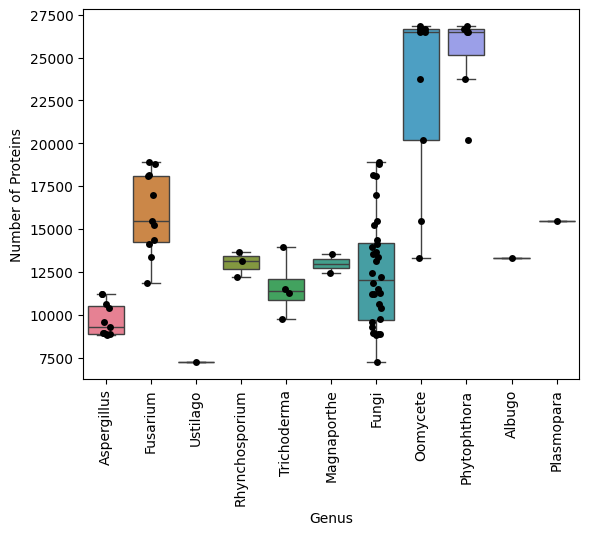

In [9]:
ax = sns.boxplot(x="Genus", y="Number of Proteins", data=proteom_sns_df, hue='Genus', showfliers=False);
sns.stripplot(x="Genus", y="Number of Proteins", data=proteom_sns_df, color='black', jitter=True, ax=ax);
plt.xticks(rotation=90);
plt.savefig('../data/proteins/proteomesScatterPlot.pdf', bbox_inches='tight', format='pdf')

Run a t-test to test for statistically signficant differences in proteome sizes between oomycetes and fungi.

In [10]:
fungi_proteomes = []
oomycete_proteomes = []
for genome in proteome_dict:
    if proteome_dict[genome]['genus'] in FUNGI:
        fungi_proteomes.append(proteome_dict[genome]['proteins'])
    elif proteome_dict[genome]['genus'] in OOMYCETE:
        oomycete_proteomes.append(proteome_dict[genome]['proteins'])
    else:
        print('help:', genome)
        
print(len(fungi_proteomes), len(oomycete_proteomes))

t_statistic, p_value, _ = sm.stats.ttest_ind(fungi_proteomes, oomycete_proteomes)

print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")
print(f"Fungi mean: {np.mean(fungi_proteomes)}, sd: {np.std(fungi_proteomes)}")
print(f"Oomycete mean: {np.mean(oomycete_proteomes)}, sd: {np.std(oomycete_proteomes)}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

32 9
t-statistic: -7.299732700824037
p-value: 8.3375460046936e-09
Fungi mean: 12522.15625, sd: 3191.8302655899383
Oomycete mean: 22874.777777777777, sd: 5000.018683915709
Reject the null hypothesis. There is a significant difference between the groups.


## Number of CAZymes

In [11]:
# Calculate CAZymes per genome
cazome_sizes_dict_lineage, cazome_sizes_df_lineage = count_items_in_cazome(fgp_df, 'Protein', 'Lineage', round_by=2)
cazome_sizes_df_lineage

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 14542.74it/s]
Calculating num of Protein per genome and per Lineage: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 258.71it/s]


Lineage  MeanProteins  SdProteins  NumOfGenomes
0     Fungi        485.38      109.29            32
1  Oomycete        349.22      101.14             9

In [12]:
# lineage: genome: numOfProteins
fungal_cazymes_count = []
oomycete_cazymes_count = []
for genome in cazome_sizes_dict_lineage['Fungi']:
    fungal_cazymes_count.append(cazome_sizes_dict_lineage['Fungi'][genome]['numOfProteins'])
for genome in cazome_sizes_dict_lineage['Oomycete']:
    oomycete_cazymes_count.append(cazome_sizes_dict_lineage['Oomycete'][genome]['numOfProteins'])
    
t_statistic, p_value, _ = sm.stats.ttest_ind(fungal_cazymes_count, oomycete_cazymes_count)

print(len(fungal_cazymes_count), len(oomycete_cazymes_count))
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")
print(f"Fungi mean: {np.mean(fungal_cazymes_count)}, sd: {np.std(fungal_cazymes_count)}")
print(f"Oomycete mean: {np.mean(oomycete_cazymes_count)}, sd: {np.std(oomycete_cazymes_count)}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

32 9
t-statistic: 3.2722406569345424
p-value: 0.00223819463126838
Fungi mean: 485.375, sd: 109.28882319340802
Oomycete mean: 349.22222222222223, sd: 101.14431689178672
Reject the null hypothesis. There is a significant difference between the groups.


In [13]:
# Calculate CAZymes per genome
cazome_sizes_dict, cazome_sizes_df = count_items_in_cazome(fgp_df, 'Protein', 'Genus', round_by=2)
cazome_sizes_df

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 15530.62it/s]
Calculating num of Protein per genome and per Genus: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 7918.76it/s]


Genus  MeanProteins  SdProteins  NumOfGenomes
0        Fusarium        606.82       65.92            11
1     Aspergillus        435.82       12.65            11
2    Phytophthora        400.00       39.35             7
3     Trichoderma        386.00       32.76             4
4     Magnaporthe        528.00       22.00             2
5  Rhynchosporium        421.67        8.96             3
6          Albugo        174.00        0.00             1
7        Ustilago        198.00        0.00             1
8      Plasmopara        169.00        0.00             1

In [14]:
# Calculate CAZymes per genome
cazome_sizes_dict_sp, cazome_sizes_df_sp = count_items_in_cazome(fgp_df, 'Protein', 'Species', round_by=2)
cazome_sizes_df_sp

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 15730.92it/s]
Calculating num of Protein per genome and per Species: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 7111.00it/s]


Species  MeanProteins  SdProteins  NumOfGenomes
0    proliferatum        599.67        5.91             3
1     graminearum        511.33       10.40             3
2       oxysporum        668.40       13.48             5
3           niger        450.25       10.01             4
4      parasitica        418.25        3.27             4
5       harzianum        403.00       16.57             3
6       fumigatus        427.57        2.66             7
7   citrinoviride        335.00        0.00             1
8       infestans        341.50       18.50             2
9          grisea        506.00        0.00             1
10        secalis        409.00        0.00             1
11       agropyri        428.00        0.00             1
12        candida        174.00        0.00             1
13        commune        428.00        0.00             1
14      bromivora        198.00        0.00             1
15          sojae        444.00        0.00             1
16      halstedii        169.00        0.00             1
17         oryzae        550.00        0.00             1

In [15]:
# plot the counts
# cazome_sizes_dict_lineage = lineage : genome : numOfProteins
# cazome_sizes_dict = genus : genome : numOfProteins

cazome_df_data = []

fungi_cazomes_list, oomycete_cazomes_list = [], []

# add fungal genera
for genus in cazome_sizes_dict:
    if genus in FUNGI:
        for genome in cazome_sizes_dict[genus]:
            cazome_df_data.append([genus, cazome_sizes_dict[genus][genome]['numOfProteins']])
            fungi_cazomes_list.append(cazome_sizes_dict[genus][genome]['numOfProteins'])

# add fungi
for value in fungi_cazomes_list:
    cazome_df_data.append(['Fungi', value])
    
for genus in cazome_sizes_dict:
    if genus in OOMYCETE:
        for genome in cazome_sizes_dict[genus]:
            oomycete_cazomes_list.append(cazome_sizes_dict[genus][genome]['numOfProteins'])

# add oomycete
for value in oomycete_cazomes_list:
    cazome_df_data.append(['Oomycete', value])
    
# add oomycete genera
for genus in cazome_sizes_dict:
    if genus in OOMYCETE:
        for genome in cazome_sizes_dict[genus]:
            cazome_df_data.append([genus, cazome_sizes_dict[genus][genome]['numOfProteins']])
        
cazome_sns_df = pd.DataFrame(cazome_df_data, columns=['Genus', 'Number of CAZymes'])
cazome_sns_df.to_csv("../data/cazome/cazome_sizes.csv")

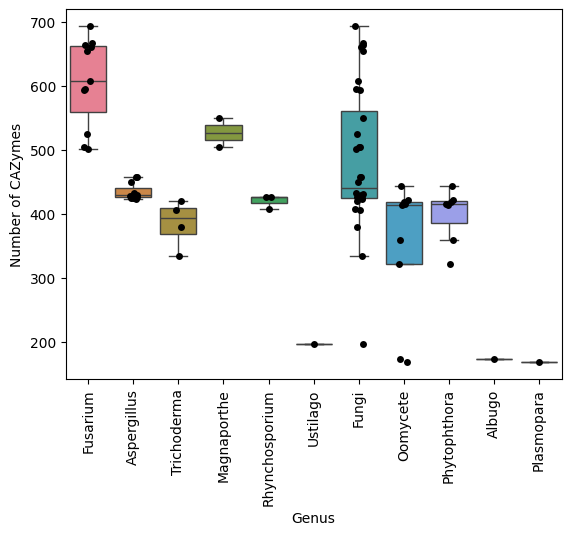

In [16]:
ax = sns.boxplot(x="Genus", y="Number of CAZymes", data=cazome_sns_df, hue='Genus', showfliers=False);
sns.stripplot(x="Genus", y="Number of CAZymes", data=cazome_sns_df, color='black', jitter=True, ax=ax);
plt.xticks(rotation=90);
plt.savefig('../data/cazome/cazomesScatterPlot.pdf', bbox_inches='tight', format='pdf')

In [17]:
proteome_dict

{'GCF_000149755.1': {'proteins': 26490,
  'genus': 'Phytophthora',
  'species': 'sojae'},
 'GCA_002234985.1': {'proteins': 9285,
  'genus': 'Aspergillus',
  'species': 'fumigatus'},
 'GCA_900044135.1': {'proteins': 14144,
  'genus': 'Fusarium',
  'species': 'graminearum'},
 'GCA_900080155.1': {'proteins': 7227,
  'genus': 'Ustilago',
  'species': 'bromivora'},
 'GCA_003615215.1': {'proteins': 15449,
  'genus': 'Fusarium',
  'species': 'proliferatum'},
 'GCF_000002855.3': {'proteins': 10609,
  'genus': 'Aspergillus',
  'species': 'niger'},
 'GCA_900074905.1': {'proteins': 13673,
  'genus': 'Rhynchosporium',
  'species': 'agropyri'},
 'GCA_003290285.1': {'proteins': 14379,
  'genus': 'Fusarium',
  'species': 'proliferatum'},
 'GCA_900029915.1': {'proteins': 15254,
  'genus': 'Fusarium',
  'species': 'proliferatum'},
 'GCA_000988865.1': {'proteins': 11498,
  'genus': 'Trichoderma',
  'species': 'harzianum'},
 'GCA_001078535.1': {'proteins': 13311,
  'genus': 'Albugo',
  'species': 'candid

## CAZome versus Proteome

In [18]:
cazome_sizes_dict_genome, cazome_sizes_df_genome = count_items_in_cazome(fgp_df, 'Protein', 'Genome', round_by=2)

c_p_data = []
for genome in cazome_sizes_dict_genome:
    genus = proteome_dict[genome]['genus']
    proteome_size = proteome_dict[genome]['proteins']
    cazome_size = cazome_sizes_dict_genome[genome][genome]['numOfProteins']
    c_p_data.append([genus,proteome_size,cazome_size])

c_p_df = pd.DataFrame(c_p_data, columns=['Genus','Proteome Size', 'CAZome Size'])

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 15757.61it/s]
Calculating num of Protein per genome and per Genome: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 8344.24it/s]


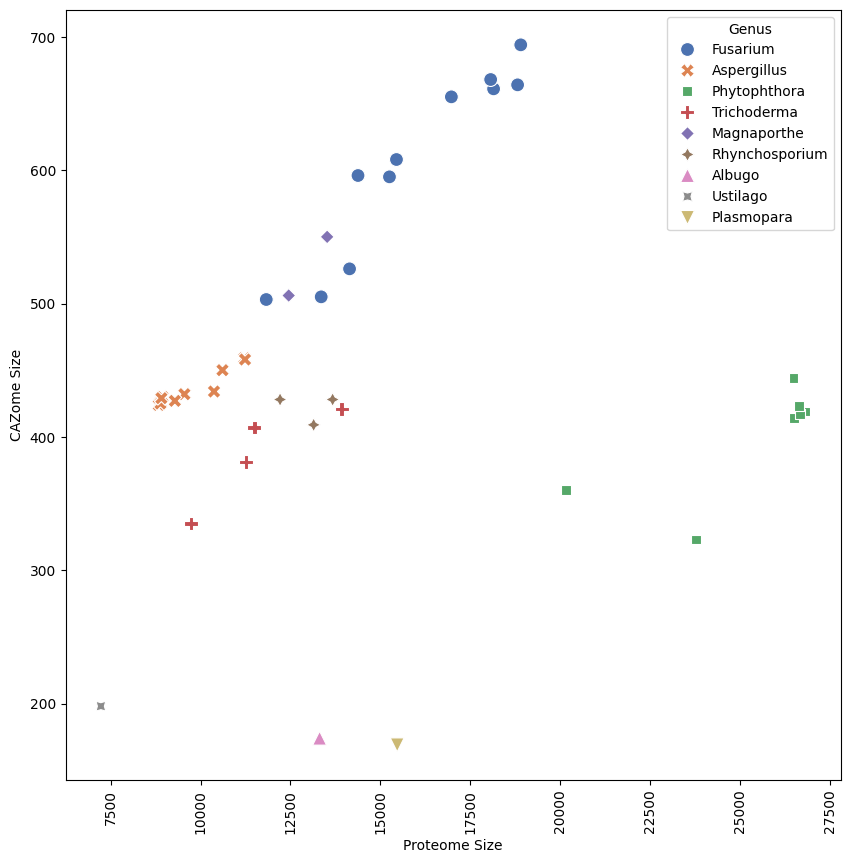

In [19]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=c_p_df, x="Proteome Size", y="CAZome Size",  hue="Genus", style="Genus", palette="deep", s=100)
plt.xticks(rotation=90);
plt.savefig('../data/cazome/cazomeVsproteome.pdf', bbox_inches='tight', format='pdf')

## Number of CAZy families

In [20]:
# Calculate CAZy families per genome
cazome_fam_dict_lineage, cazome_fams_df_lineage = count_items_in_cazome(fgp_df, 'Family', 'Lineage', round_by=2)
cazome_fams_df_lineage

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 14917.83it/s]
Calculating num of Family per genome and per Lineage: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 4339.68it/s]


Lineage  MeanFamilys  SdFamilys  NumOfGenomes
0     Fungi       134.56      12.56            32
1  Oomycete        67.33       8.01             9

In [21]:
# Calculate CAZy families per genome
cazome_fam_dict, cazome_fams_df = count_items_in_cazome(fgp_df, 'Family', 'Genus', round_by=2)
cazome_fams_df

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 16150.99it/s]
Calculating num of Family per genome and per Genus: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 4365.53it/s]


Genus  MeanFamilys  SdFamilys  NumOfGenomes
0        Fusarium       146.27       2.77            11
1     Aspergillus       130.64       6.65            11
2    Phytophthora        71.29       2.55             7
3     Trichoderma       122.75       4.92             4
4     Magnaporthe       144.00       1.00             2
5  Rhynchosporium       130.00       1.41             3
6          Albugo        49.00       0.00             1
7        Ustilago        91.00       0.00             1
8      Plasmopara        58.00       0.00             1

In [22]:
# Calculate CAZy families per genome
cazome_fam_dict_sp, cazome_fams_df_sp = count_items_in_cazome(fgp_df, 'Family', 'Species', round_by=2)
cazome_fams_df_sp

Gathering CAZy families per genome: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 20208/20208 [00:01<00:00, 16285.89it/s]
Calculating num of Family per genome and per Species: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 7881.56it/s]


Species  MeanFamilys  SdFamilys  NumOfGenomes
0    proliferatum       148.00       1.41             3
1     graminearum       142.33       1.89             3
2       oxysporum       147.60       0.80             5
3           niger       122.00       1.22             4
4      parasitica        73.25       1.09             4
5       harzianum       125.33       2.36             3
6       fumigatus       135.57       1.29             7
7   citrinoviride       115.00       0.00             1
8       infestans        69.50       0.50             2
9          grisea       143.00       0.00             1
10        secalis       129.00       0.00             1
11       agropyri       129.00       0.00             1
12        candida        49.00       0.00             1
13        commune       132.00       0.00             1
14      bromivora        91.00       0.00             1
15          sojae        67.00       0.00             1
16      halstedii        58.00       0.00             1
17         oryzae       145.00       0.00             1

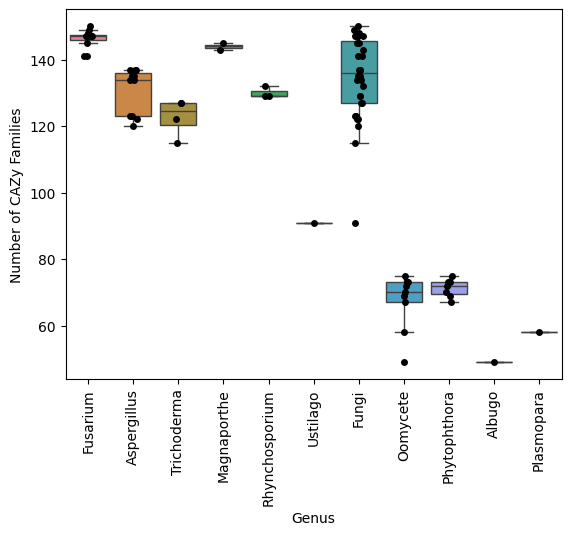

In [23]:
# plot the counts
# cazome_fam_dict_lineage = lineage : genome : numOfProteins
# cazome_fam_dict = genus : genome : numOfProteins

cazyFam_df_data = []
fungi_cazyFams_list, oomycete_cazyFams_list = [], []

# add fungal genera
for genus in cazome_fam_dict:
    if genus in FUNGI:
        for genome in cazome_fam_dict[genus]:
            cazyFam_df_data.append([genus, cazome_fam_dict[genus][genome]['numOfFamilys']])
            fungi_cazyFams_list.append(cazome_fam_dict[genus][genome]['numOfFamilys'])

# add fungi
for value in fungi_cazyFams_list:
    cazyFam_df_data.append(['Fungi', value])
    
for genus in cazome_fam_dict:
    if genus in OOMYCETE:
        for genome in cazome_fam_dict[genus]:
            oomycete_cazyFams_list.append(cazome_fam_dict[genus][genome]['numOfFamilys'])

# add oomycete
for value in oomycete_cazyFams_list:
    cazyFam_df_data.append(['Oomycete', value])
    
# add oomycete genera
for genus in cazome_fam_dict:
    if genus in OOMYCETE:
        for genome in cazome_fam_dict[genus]:
            cazyFam_df_data.append([genus, cazome_fam_dict[genus][genome]['numOfFamilys']])
        
cazyFam_sns_df = pd.DataFrame(cazyFam_df_data, columns=['Genus', 'Number of CAZy Families'])
cazyFam_sns_df.to_csv("../data/cazome/cazyFam_sizes.csv")

ax = sns.boxplot(x="Genus", y="Number of CAZy Families", data=cazyFam_sns_df, hue='Genus', showfliers=False);
sns.stripplot(x="Genus", y="Number of CAZy Families", data=cazyFam_sns_df, color='black', jitter=True, ax=ax);
plt.xticks(rotation=90);
plt.savefig('../data/cazome/cazyFamiliesScatterPlot.pdf', bbox_inches='tight', format='pdf')

In [24]:
# fungi_cazyFams_list, oomycete_cazyFams_list
    
t_statistic, p_value, _ = sm.stats.ttest_ind(fungi_cazyFams_list, oomycete_cazyFams_list)

print(len(fungi_cazyFams_list), len(oomycete_cazyFams_list))
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")
print(f"Fungi mean: {np.mean(fungi_cazyFams_list)}, sd: {np.std(fungi_cazyFams_list)}")
print(f"Oomycete mean: {np.mean(oomycete_cazyFams_list)}, sd: {np.std(oomycete_cazyFams_list)}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

32 9
t-statistic: 14.832765325667074
p-value: 1.2684090064481346e-17
Fungi mean: 134.5625, sd: 12.562189050878036
Oomycete mean: 67.33333333333333, sd: 8.013876853447538
Reject the null hypothesis. There is a significant difference between the groups.


## Percentage of the proteome in the CAZome

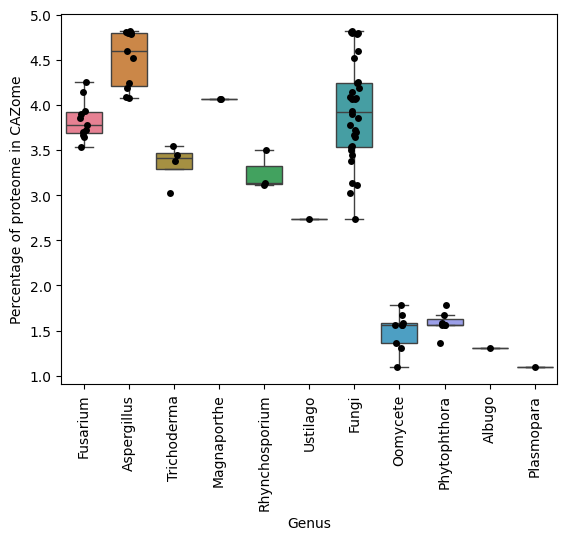

In [25]:
# proteome_dict {genome: 'genus', 'species', 'proteins'}
# cazome_sizes_dict {genus : genomes : 'numOfProteins'}
fungi_perc, oomycete_perc, all_perc = [], [], []

perc_dict = {}  # genus: [percentages]

for genus in cazome_sizes_dict:
    for genome in cazome_sizes_dict[genus]:
        proteome = proteome_dict[genome]['proteins']
        cazymes = cazome_sizes_dict[genus][genome]['numOfProteins']
        perc = (cazymes/proteome)*100
        try:
            perc_dict[genus].append(perc)
        except KeyError:
            perc_dict[genus]=[perc]
    
    if genus in FUNGI:
        for genome in cazome_sizes_dict[genus]:
            proteome = proteome_dict[genome]['proteins']
            cazymes = cazome_sizes_dict[genus][genome]['numOfProteins']
            perc = (cazymes/proteome)*100
            fungi_perc.append(perc)
            all_perc.append([genus, perc])
            
for value in fungi_perc:
    all_perc.append(['Fungi', value])
    
for genus in cazome_sizes_dict:
    if genus in OOMYCETE:
        for genome in cazome_sizes_dict[genus]:
            proteome = proteome_dict[genome]['proteins']
            cazymes = cazome_sizes_dict[genus][genome]['numOfProteins']
            perc = (cazymes/proteome)*100
            oomycete_perc.append(perc)
            
for value in oomycete_perc:
    all_perc.append(['Oomycete', value])
    
for genus in cazome_sizes_dict:
    if genus in OOMYCETE:
        for genome in cazome_sizes_dict[genus]:
            proteome = proteome_dict[genome]['proteins']
            cazymes = cazome_sizes_dict[genus][genome]['numOfProteins']
            perc = (cazymes/proteome)*100
            all_perc.append([genus, perc])
            
perc_sns_df = pd.DataFrame(all_perc, columns=['Genus', 'Percentage of proteome in CAZome'])
perc_sns_df.to_csv("../data/cazome/percentage_of_proteome_in_cazome.csv")

ax = sns.boxplot(x="Genus", y="Percentage of proteome in CAZome", data=perc_sns_df, hue='Genus', showfliers=False);
sns.stripplot(x="Genus", y="Percentage of proteome in CAZome", data=perc_sns_df, color='black', jitter=True, ax=ax);
plt.xticks(rotation=90);
plt.savefig('../data/cazome/percCazomeScatterPlot.pdf', bbox_inches='tight', format='pdf')

In [26]:
perc_data=[]
for genus in perc_dict:
    perc_data.append([genus, np.mean(perc_dict[genus]), np.std(perc_dict[genus])])
pd.DataFrame(perc_data, columns=['Genus', 'Mean percentage of proteome in the CAZome', 'SD'])

Genus  Mean percentage of proteome in the CAZome        SD
0        Fusarium                                   3.830076  0.208689
1     Aspergillus                                   4.519512  0.296740
2    Phytophthora                                   1.584816  0.120051
3     Trichoderma                                   3.346684  0.194959
4     Magnaporthe                                   4.065675  0.002071
5  Rhynchosporium                                   3.248914  0.181269
6          Albugo                                   1.307190  0.000000
7        Ustilago                                   2.739726  0.000000
8      Plasmopara                                   1.092508  0.000000

In [27]:
# fungi_perc, oomycete_perc  
t_statistic, p_value, _ = sm.stats.ttest_ind(fungi_perc, oomycete_perc)

print(len(fungi_perc), len(oomycete_perc))
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")
print(f"Fungi mean: {np.mean(fungi_perc)}, sd: {np.std(fungi_perc)}")
print(f"Oomycete mean: {np.mean(oomycete_perc)}, sd: {np.std(oomycete_perc)}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the groups.")

32 9
t-statistic: 12.617138451823344
p-value: 2.4055801275278708e-15
Fungi mean: 3.932813152099947, sd: 0.5544383261400456
Oomycete mean: 1.4992674354950013, sd: 0.19845583288890525
Reject the null hypothesis. There is a significant difference between the groups.


<a name="classes"></a>
# CAZy classes

In [28]:
# make output dir for results, will not delete data if dir already exists
make_output_directory(Path('../results/cazy_classes/'), force=True, nodelete=True)

class_df_L, class_size_dict_L = calculate_class_sizes(fgp_df, 'Lineage', round_by=2)
class_df_L.to_csv("../results/cazy_classes/cazy_class_freqs.csv")
class_df_L

Output directory ../results/cazy_classes exists, nodelete is True. Adding output to output directory.
Calculating CAZy class sizes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1906.50it/s]


CAZyClass   Lineage  MeanCazyClass  SdCazyClass  MeanClassPerc  \
0         GH     Fungi         271.97        59.32          56.21   
1         GH  Oomycete         178.67        55.08          51.15   
2         GT     Fungi          99.03        13.45          20.95   
3         GT  Oomycete         101.11        21.05          30.54   
4         PL     Fungi          15.00         8.05           2.93   
5         PL  Oomycete          31.89        21.49           8.14   
6         CE     Fungi          32.00        12.66           6.39   
7         CE  Oomycete          20.00         9.45           5.36   
8         AA     Fungi          60.84        22.66          12.24   
9         AA  Oomycete          13.78         5.41           3.77   
10       CBM     Fungi          48.62        13.78           9.95   
11       CBM  Oomycete          10.89         3.21           3.14   

    SdClassPerc  NumOfGenomes  
0          3.59            32  
1          3.66             9  
2          2.89            32  
3          6.20             9  
4          1.15            32  
5          5.41             9  
6          1.47            32  
7          2.00             9  
8          2.84            32  
9          0.91             9  
10         2.11            32  
11         0.31             9

In [29]:
class_df_G, class_size_dict_G = calculate_class_sizes(fgp_df, 'Genus', round_by=2)
class_df_G.to_csv("../results/cazy_classes/cazy_class_freqs_genus.csv")
class_df_G

Calculating CAZy class sizes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 434.48it/s]


CAZyClass           Genus  MeanCazyClass  SdCazyClass  MeanClassPerc  \
0         GH     Aspergillus         254.00         6.18          58.34   
1         GH        Fusarium         331.18        50.76          54.30   
2         GH     Magnaporthe         263.00         5.00          49.86   
3         GH     Trichoderma         232.75        24.65          60.18   
4         GH    Phytophthora         203.86        32.31          50.69   
5         GH  Rhynchosporium         235.67         5.56          55.89   
6         GH          Albugo          92.00         0.00          52.87   
7         GH        Ustilago         102.00         0.00          51.52   
8         GH      Plasmopara          89.00         0.00          52.66   
9         GT     Aspergillus          97.18         8.29          22.27   
10        GT        Fusarium         111.91         6.43          18.58   
11        GT     Magnaporthe         101.00         2.00          19.15   
12        GT     Trichoderma          90.25         3.03          23.49   
13        GT    Phytophthora         110.00        14.48          27.61   
14        GT  Rhynchosporium          81.67         0.94          19.37   
15        GT          Albugo          74.00         0.00          42.53   
16        GT        Ustilago          61.00         0.00          30.81   
17        GT      Plasmopara          66.00         0.00          39.05   
18        PL     Aspergillus          13.00         2.49           3.00   
19        PL        Fusarium          25.00         2.00           4.14   
20        PL     Magnaporthe           6.50         0.50           1.23   
21        PL     Trichoderma           4.75         0.43           1.23   
22        PL    Phytophthora          40.57        15.95          10.21   
23        PL  Rhynchosporium           9.00         0.00           2.14   
24        PL          Albugo           1.00         0.00           0.57   
25        PL        Ustilago           3.00         0.00           1.52   
26        PL      Plasmopara           2.00         0.00           1.18   
27        CE     Aspergillus          23.45         1.30           5.39   
28        CE        Fusarium          45.73         3.82           7.58   
29        CE     Magnaporthe          50.00         1.00           9.48   
30        CE     Trichoderma          17.50         3.04           4.50   
31        CE    Phytophthora          24.43         4.81           6.13   
32        CE  Rhynchosporium          27.67         1.25           6.56   
33        CE          Albugo           1.00         0.00           0.57   
34        CE        Ustilago          10.00         0.00           5.05   
35        CE      Plasmopara           8.00         0.00           4.73   
36        AA     Aspergillus          45.18        13.60          10.30   
37        AA        Fusarium          83.00         6.77          13.73   
38        AA     Magnaporthe          90.50         4.50          17.13   
39        AA     Trichoderma          37.00         2.74           9.60   
40        AA    Phytophthora          16.57         1.59           4.18   
41        AA  Rhynchosporium          62.67         1.89          14.86   
42        AA          Albugo           4.00         0.00           2.30   
43        AA        Ustilago          20.00         0.00          10.10   
44        AA      Plasmopara           4.00         0.00           2.37   
45       CBM     Aspergillus          41.64         8.55           9.61   
46       CBM        Fusarium          58.64         8.03           9.66   
47       CBM     Magnaporthe          65.50        11.50          12.34   
48       CBM     Trichoderma          45.50         6.87          11.72   
49       CBM    Phytophthora          12.43         1.59           3.12   
50       CBM  Rhynchosporium          44.67         0.47          10.60   
51       CBM          Albugo           6.00         0.00           3.45   
52       CBM        Ustilago

In [30]:
class_df_S, class_size_dict_S = calculate_class_sizes(fgp_df, 'Species', round_by=2)

class_df_S

Calculating CAZy class sizes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 253.86it/s]


CAZyClass       Species  MeanCazyClass  SdCazyClass  MeanClassPerc  \
0          GH     infestans         153.50         3.50          45.14   
1          GH  proliferatum         326.67         5.56          54.47   
2          GH     oxysporum         378.40        10.29          56.61   
3          GH         niger         248.25         6.87          55.13   
4          GH       commune         238.00         0.00          55.61   
..        ...           ...            ...          ...            ...   
103       CBM      agropyri          45.00         0.00          10.51   
104       CBM    parasitica          12.00         0.71           2.87   
105       CBM       candida           6.00         0.00           3.45   
106       CBM         sojae          16.00         0.00           3.60   
107       CBM     halstedii           5.00         0.00           2.96   

     SdClassPerc  NumOfGenomes  
0           3.47             2  
1           0.65             3  
2           0.52             5  
3           0.68             4  
4           0.00             1  
..           ...           ...  
103         0.00             1  
104         0.18             4  
105         0.00             1  
106         0.00             1  
107         0.00             1  

[108 rows x 7 columns]

Test for mean differences between the lineages (fungi and oomycete) and CAZy classes using a two-way ANOVA.

In [31]:
class_size_dict_L
cazy_class_anova_data = []  # [cazy class, lineage, cazy class freq]  # not means
for cazyclass in class_size_dict_L:
    for lineage in class_size_dict_L[cazyclass]:
        for genome in class_size_dict_L[cazyclass][lineage]:
            class_freq = class_size_dict_L[cazyclass][lineage][genome]['numOfProteins']
            cazy_class_anova_data.append([cazyclass, lineage, class_freq])
cazy_class_anova_df = pd.DataFrame(cazy_class_anova_data, columns=['CAZyClass','Lineage','Frequency'])

model = ols('Frequency ~ CAZyClass * Lineage', data=cazy_class_anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)

                         sum_sq     df           F         PR(>F)
CAZyClass          1.579912e+06    5.0  400.272458  1.732702e-112
Lineage            3.428761e+04    1.0   43.434017   2.875375e-10
CAZyClass:Lineage  5.547047e+04    5.0   14.053504   5.086415e-12
Residual           1.847239e+05  234.0         NaN            NaN


In [32]:
cazy_class_anova_df_2 = []
for ri in range(len(cazy_class_anova_df)):
    cazy_class_anova_df_2.append([
        f"{cazy_class_anova_df.iloc[ri]['CAZyClass']}-{cazy_class_anova_df.iloc[ri]['Lineage']}",
        cazy_class_anova_df.iloc[ri]['Frequency'],
    ])
cazy_class_anova_df_2 = pd.DataFrame(cazy_class_anova_df_2, columns=['CAZyClass-Lineage', 'Frequency'])

In [33]:
tukey_result = pairwise_tukeyhsd(cazy_class_anova_df_2['Frequency'], cazy_class_anova_df_2['CAZyClass-Lineage'], alpha=0.05)
pd.DataFrame(
    tukey_result._results_table[1:],
    columns=tukey_result._results_table.data[0]
).to_csv("../results/cazy_classes/class-two-way-anova-tukeyHSD.tsv", sep="\t")

In [34]:
tukey_result = pairwise_tukeyhsd(cazy_class_anova_df['Frequency'], cazy_class_anova_df['CAZyClass'], alpha=0.05)
pd.DataFrame(
    tukey_result._results_table[1:],
    columns=tukey_result._results_table.data[0]
)

group1 group2   meandiff   p-adj      lower      upper reject
0      AA    CBM   -10.1707  0.7498   -31.6289    11.2875  False
1      AA     CE   -21.1463   0.056   -42.6045     0.3119  False
2      AA     GH   200.9756     0.0   179.5174   222.4338   True
3      AA     GT    48.9756     0.0    27.5174    70.4338   True
4      AA     PL   -31.8049  0.0004   -53.2631   -10.3467   True
5     CBM     CE   -10.9756  0.6841   -32.4338    10.4826  False
6     CBM     GH   211.1463     0.0   189.6881   232.6045   True
7     CBM     GT    59.1463     0.0    37.6881    80.6045   True
8     CBM     PL   -21.6341  0.0469   -43.0924    -0.1759   True
9      CE     GH    222.122     0.0   200.6637   243.5802   True
10     CE     GT     70.122     0.0    48.6637    91.5802   True
11     CE     PL   -10.6585  0.7106   -32.1167    10.7997  False
12     GH     GT     -152.0     0.0  -173.4582  -130.5418   True
13     GH     PL  -232.7805     0.0  -254.2387  -211.3223   True
14     GT     PL   -80.7805     0.0  -102.2387   -59.3223   True

In [35]:
tukey_result = pairwise_tukeyhsd(cazy_class_anova_df['Frequency'], cazy_class_anova_df['Lineage'], alpha=0.05)
pd.DataFrame(
    tukey_result._results_table[1:],
    columns=tukey_result._results_table.data[0]
)

group1    group2  meandiff  p-adj     lower    upper reject
0  Fungi  Oomycete  -28.5226  0.033  -54.7274  -2.3178   True

<a name="families"></a>
# CAZy families

In [36]:
# make output directory
# make output dir for results, will not delete data if dir already exists
make_output_directory(Path('../results/cazy_families/'), force=True, nodelete=True)

fam_freq_df = build_fam_freq_df(fgp_df, ['Lineage', 'Genus', 'Species'])
fam_freq_df.to_csv("../results/cazy_families/cazy_fam_freqs.csv")
fam_freq_df.head(5)

Output directory ../results/cazy_families exists, nodelete is True. Adding output to output directory.


The dataset contains 194 CAZy families


Counting fam frequencies: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:03<00:00, 12.81it/s]


Genome   Lineage         Genus       Species  AA0  AA1  AA10  \
0  GCF_000149755.1  Oomycete  Phytophthora         sojae    0    3     0   
1  GCA_002234985.1     Fungi   Aspergillus     fumigatus    0    5     0   
2  GCA_900044135.1     Fungi      Fusarium   graminearum    1   14     0   
3  GCA_900080155.1     Fungi      Ustilago     bromivora    0    5     1   
4  GCA_003615215.1     Fungi      Fusarium  proliferatum    0   14     0   

   AA11  AA12  AA13  ...  PL20  PL26  PL27  PL3  PL35  PL4  PL42  PL7  PL8  \
0     0     0     0  ...     0     0     0   36     0    2     0    0    0   
1     2     0     1  ...     1     1     0    3     0    3     0    0    0   
2     4     2     1  ...     1     1     0    7     0    3     1    0    0   
3     0     0     0  ...     0     0     0    0     1    0     0    0    0   
4     4     3     1  ...     0     1     0    9     0    3     0    0    0   

   PL9  
0    0  
1    1  
2    1  
3    0  
4    2  

[5 rows x 198 columns]

## Clustermap

Build clustermap of CAZy family frequencies, with additional row colours marking the genus classification of each genome (i.e. each row).

In [37]:
# index the taxonomy data and genome (ggs=genome_genus_species)
fam_freq_df_ggs = copy(fam_freq_df)  # so does not alter fam_freq_df
fam_freq_df_ggs = fam_freq_df_ggs.set_index(['Genome','Lineage','Genus','Species'])
fam_freq_df_ggs.head(1)

AA0  AA1  AA10  AA11  AA12  \
Genome          Lineage  Genus        Species                               
GCF_000149755.1 Oomycete Phytophthora sojae      0    3     0     0     0   

                                               AA13  AA14  AA16  AA17  AA2  \
Genome          Lineage  Genus        Species                                
GCF_000149755.1 Oomycete Phytophthora sojae       0     0     0     0    0   

                                               ...  PL20  PL26  PL27  PL3  \
Genome          Lineage  Genus        Species  ...                          
GCF_000149755.1 Oomycete Phytophthora sojae    ...     0     0     0   36   

                                               PL35  PL4  PL42  PL7  PL8  PL9  
Genome          Lineage  Genus        Species                                  
GCF_000149755.1 Oomycete Phytophthora sojae       0    2     0    0    0    0  

[1 rows x 194 columns]

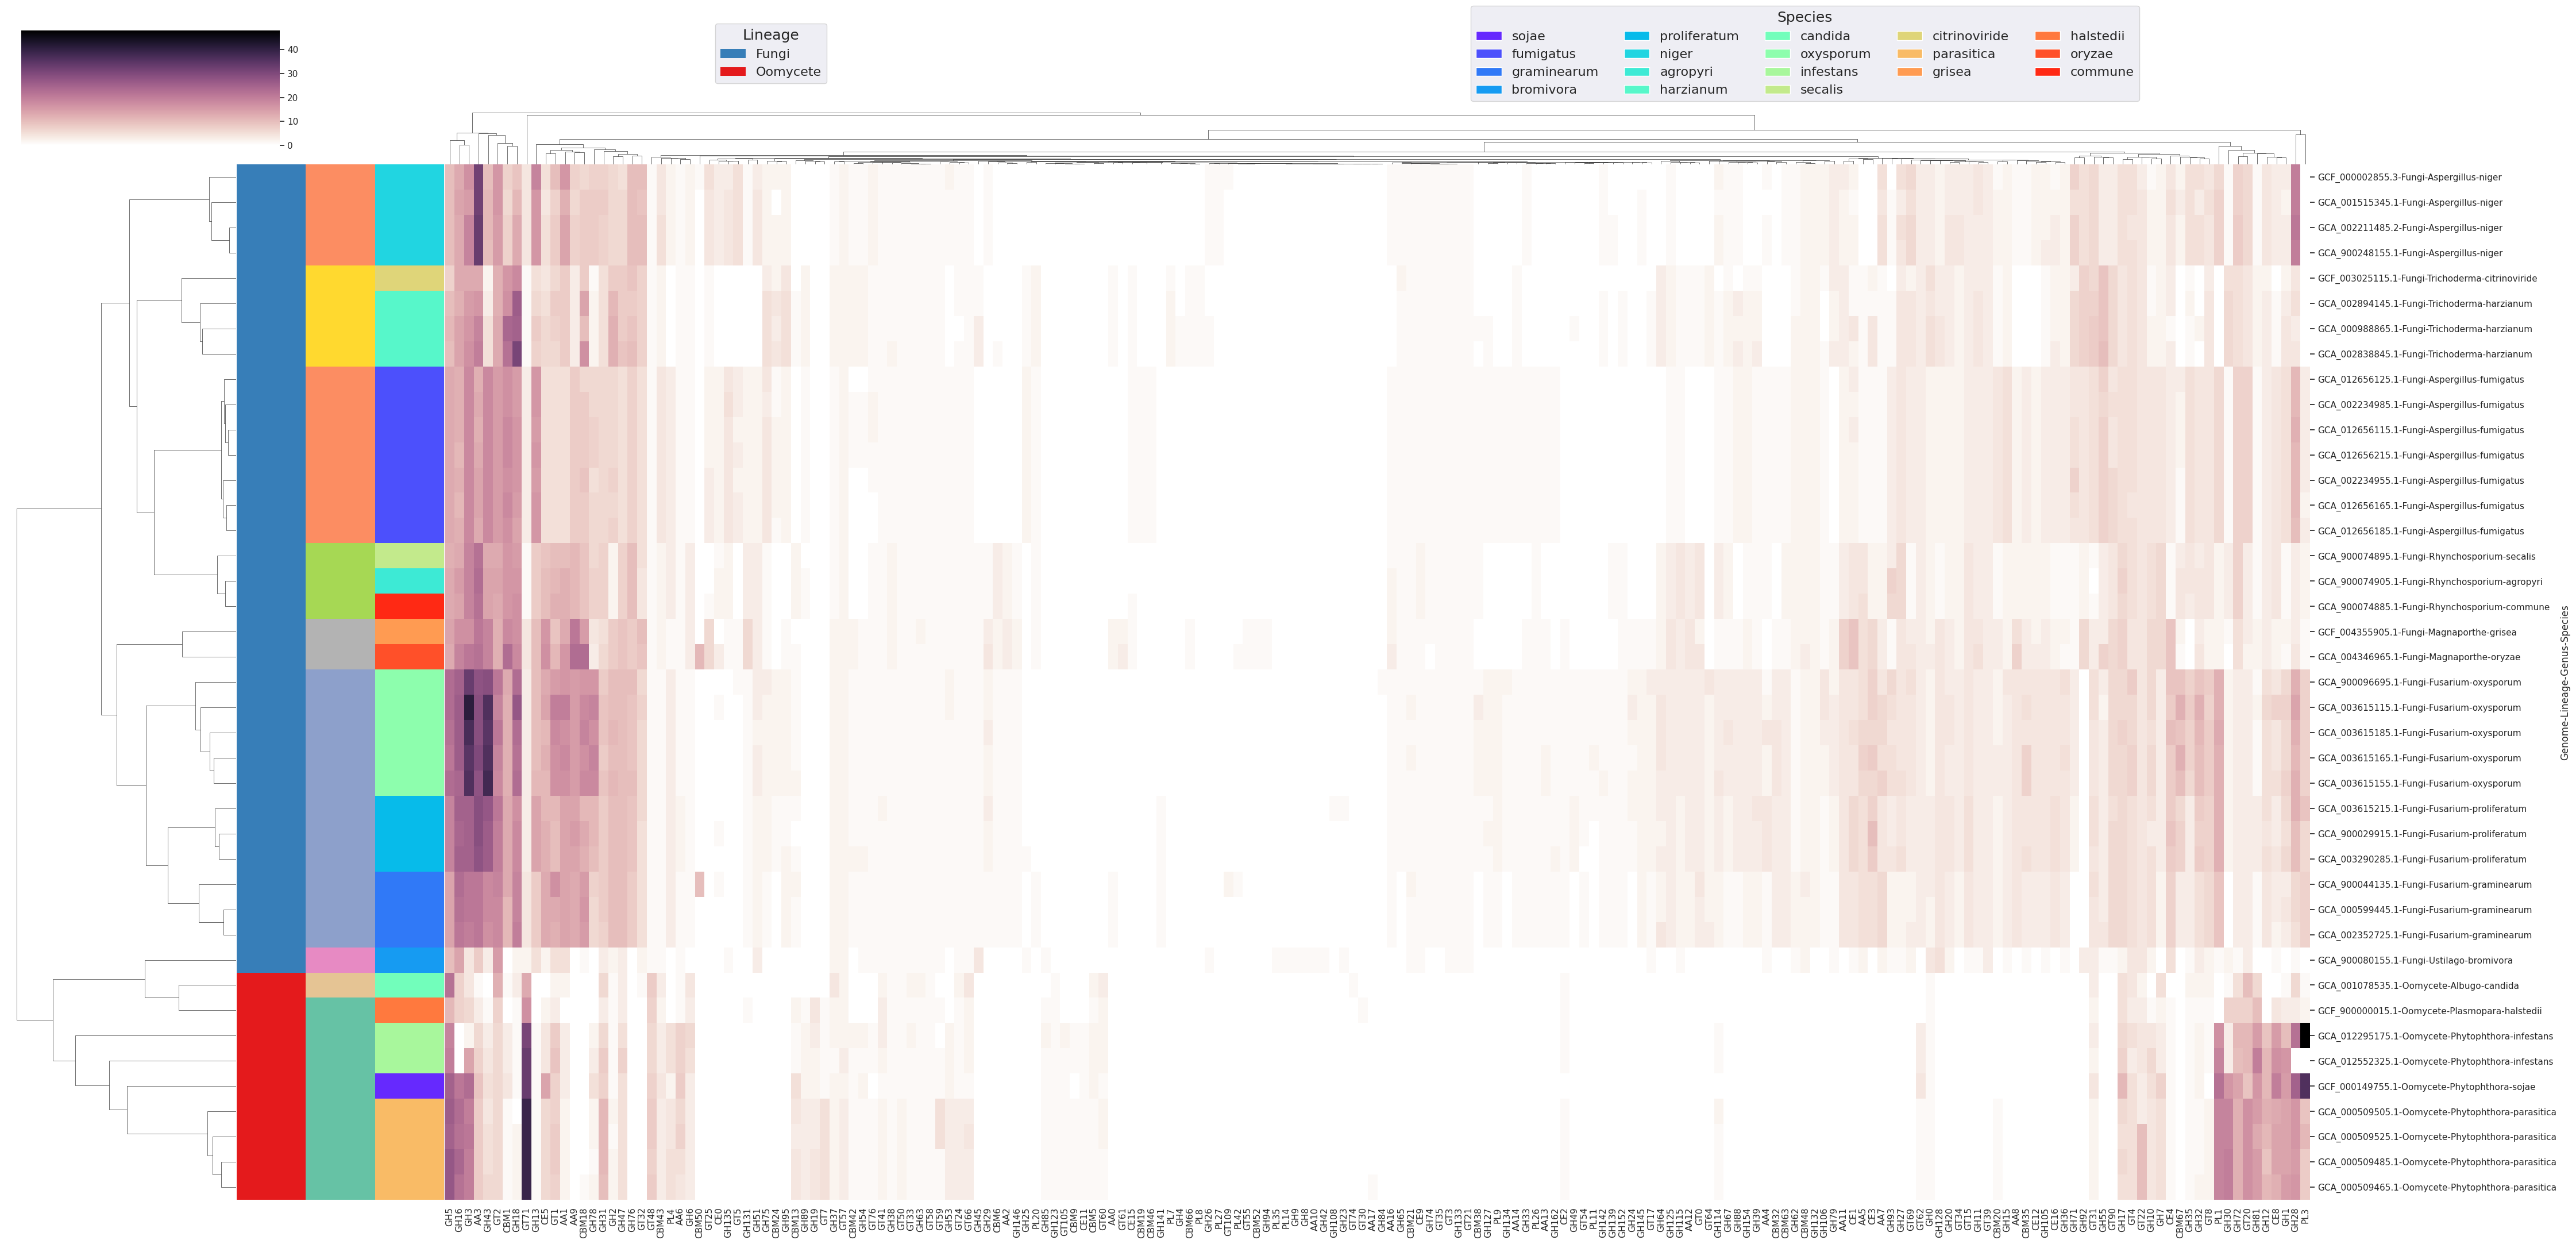

In [38]:
# define a colour scheme to colour code rows by Lineage
fam_freq_df_ggs['Lineage'] = list(fam_freq_df['Lineage'])  # add column to use for colour scheme, is removed
fam_freq_lineage_row_colours, fam_l_lut = build_row_colours(fam_freq_df_ggs, 'Lineage', 'Set1')

# define a colour scheme to colour code rows by genus
fam_freq_df_ggs['Genus'] = list(fam_freq_df['Genus'])  # add column to use for colour scheme, is removed
fam_freq_genus_row_colours, fam_g_lut = build_row_colours(fam_freq_df_ggs, 'Genus', 'Set2')

# define a colour scheme to colour code rows by SPECIES
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme, is removed
fam_freq_species_row_colours, fam_s_lut = build_row_colours(fam_freq_df_ggs, 'Species', 'rainbow')

build_family_clustermap_multi_legend(
    df=fam_freq_df_ggs,
    row_colours=[fam_freq_lineage_row_colours, fam_freq_genus_row_colours, fam_freq_species_row_colours],
    luts=[fam_l_lut, fam_g_lut, fam_s_lut],
    legend_titles=['Lineage', 'Genus', 'Species'],
    bbox_to_anchors=[(0.3,1.04), (0.5,1.04), (0.7,1.04)],
    legend_cols=[1,3,5],
    fig_size=(45,20),
    file_path="../results/cazy_families/fam_freq_clustermap.pdf",
    file_format='pdf',
    font_scale=1,
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.96, 0.1, 0.1),  #left, bottom, width, height
);

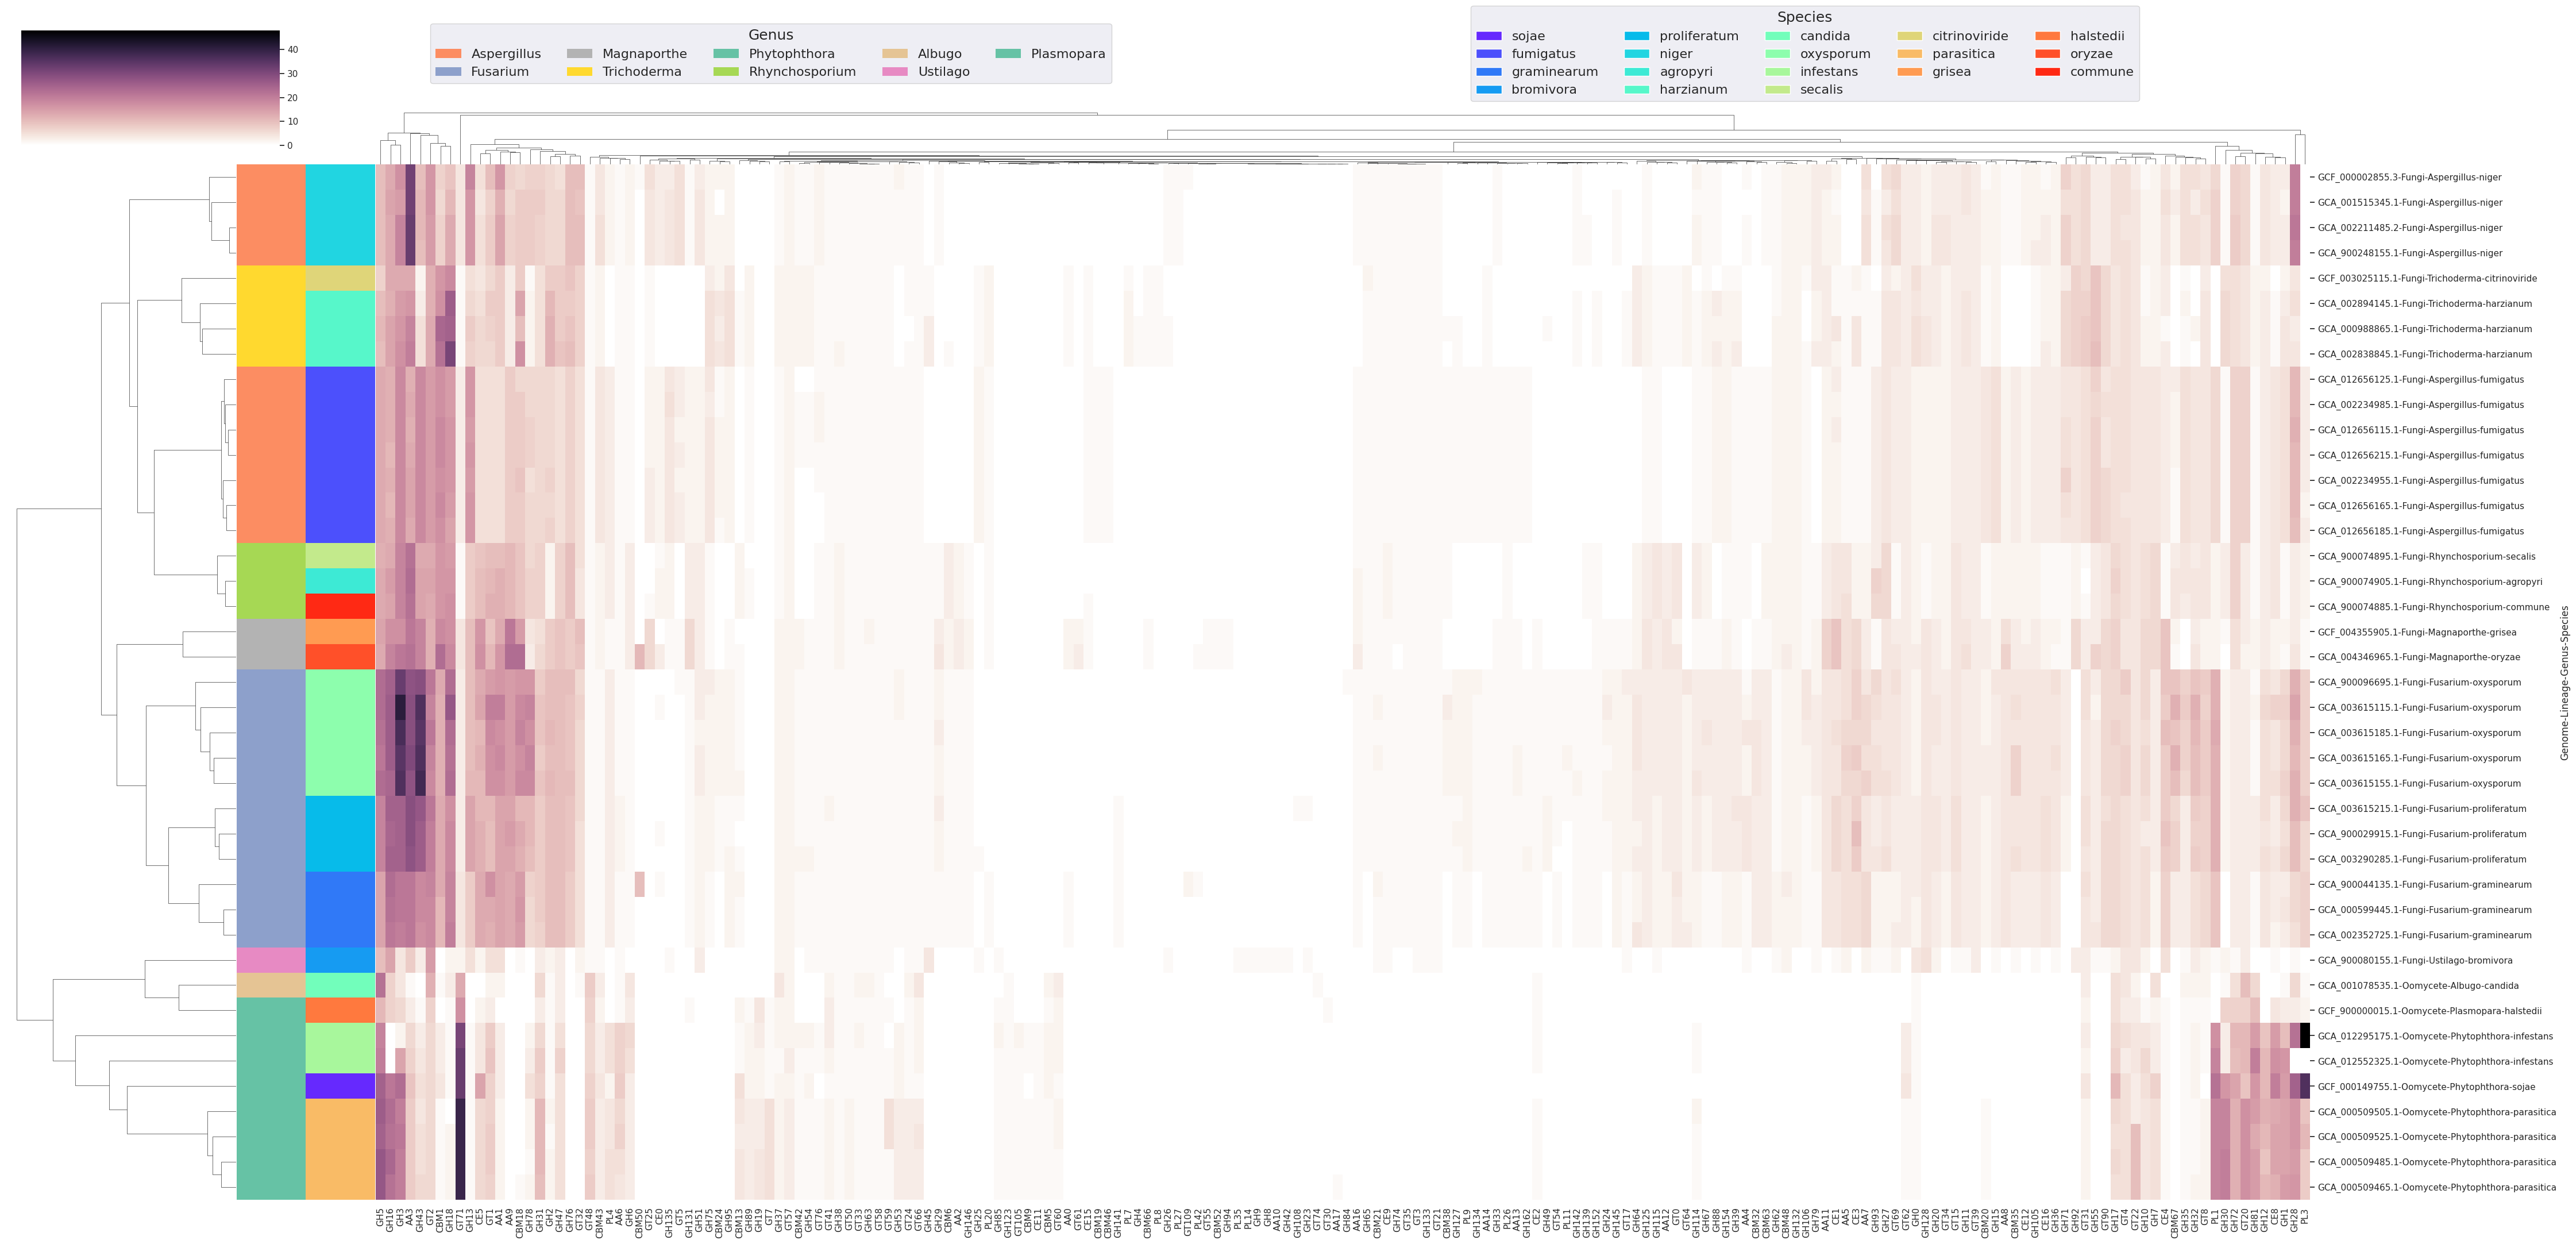

In [39]:
# define a colour scheme to colour code rows by Lineage
fam_freq_df_ggs['Lineage'] = list(fam_freq_df['Lineage'])  # add column to use for colour scheme, is removed
fam_freq_lineage_row_colours, fam_l_lut = build_row_colours(fam_freq_df_ggs, 'Lineage', 'Set1')

# define a colour scheme to colour code rows by genus
fam_freq_df_ggs['Genus'] = list(fam_freq_df['Genus'])  # add column to use for colour scheme, is removed
fam_freq_genus_row_colours, fam_g_lut = build_row_colours(fam_freq_df_ggs, 'Genus', 'Set2')

# define a colour scheme to colour code rows by SPECIES
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme, is removed
fam_freq_species_row_colours, fam_s_lut = build_row_colours(fam_freq_df_ggs, 'Species', 'rainbow')

build_family_clustermap_multi_legend(
    df=fam_freq_df_ggs,
    row_colours=[fam_freq_genus_row_colours, fam_freq_species_row_colours],
    luts=[ fam_g_lut, fam_s_lut],
    legend_titles=['Genus', 'Species'],
    bbox_to_anchors=[(0.3,1.04), (0.7,1.04)],
    legend_cols=[5,5],
    fig_size=(45,20),
    file_path="../results/cazy_families/fam_freq_clustermap_genus_species.pdf",
    file_format='pdf',
    font_scale=1,
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.96, 0.1, 0.1),  #left, bottom, width, height
);

## Lineage specific families

In [40]:
all_families = list(fam_freq_df.columns)[3:]
# dict {group: {only unique fams}} and dict {group: {all fams}}
unique_grp_fams, group_fams = get_group_specific_fams(fam_freq_df, 'Lineage', all_families)
unique_grp_fams['Both'] = set()
for fam in all_families:
    if (fam not in unique_grp_fams['Fungi']) and (fam not in unique_grp_fams['Oomycete']):
        unique_grp_fams['Both'].add(fam)
        
unique_grp_data = []
for lineage in unique_grp_fams:
    for cazyClass in ['GH','GT','PL','CE','AA','CBM']:
        for fam in unique_grp_fams[lineage]:
            if fam.startswith(cazyClass):
                unique_grp_data.append([lineage,cazyClass,fam])
        
pd.DataFrame(unique_grp_data, columns=['Lineage','CAZyClass', 'Family']).to_csv("../results/cazy_families/cazy_families.csv")

Identifying Lineage specific fams: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12520.31it/s]


## Genus specific families

In [41]:
all_families = list(fam_freq_df.columns)[3:]
# dict {group: {only unique fams}} and dict {group: {all fams}}
unique_grp_fams, group_fams = get_group_specific_fams(fam_freq_df, 'Genus', all_families)
unique_grp_fams

Identifying Genus specific fams: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 6483.81it/s]


{'Phytophthora': {'AA17', 'CBM9', 'CE11', 'GT105'},
 'Aspergillus': {'CBM19', 'CBM46', 'PL27'},
 'Fusarium': {'GH108', 'GH141', 'GH84', 'GT54', 'PL11'},
 'Ustilago': {'AA10', 'GH42', 'GH8', 'GH9', 'PL14', 'PL35'},
 'Trichoderma': {'GH4', 'PL7', 'PL8'},
 'Albugo': {'GT74'},
 'Magnaporthe': {'CBM52', 'GH94', 'GT55', 'GT61'},
 'Plasmopara': {'GT30'}}

## Species specific families

In [42]:
all_families = list(fam_freq_df.columns)[3:]
# dict {group: {only unique fams}} and dict {group: {all fams}}
unique_grp_fams, group_fams = get_group_specific_fams(fam_freq_df, 'Species', all_families)
unique_grp_fams

Identifying Species specific fams: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 3850.73it/s]


{'fumigatus': {'CBM19', 'CBM46'},
 'bromivora': {'AA10', 'GH42', 'GH8', 'GH9', 'PL14', 'PL35'},
 'proliferatum': {'GH108'},
 'niger': {'PL27'},
 'harzianum': {'GH4'},
 'candida': {'GT74'},
 'oxysporum': {'GH84'},
 'parasitica': {'AA17'},
 'halstedii': {'GT30'}}

<a name="core"></a>
# Core Families

In [43]:
make_output_directory(Path('../results/core_cazome/'), force=True, nodelete=True)

core_cazome = identify_core_cazome(fam_freq_df_ggs)

core_cazome = list(core_cazome)
core_cazome.sort()

print(f"Total families: {len(all_families)}")
print("The core CAZy families are:")
for fam in core_cazome:
    print('-', fam)

Output directory ../results/core_cazome exists, nodelete is True. Adding output to output directory.
Identifying core CAZome: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 18052.82it/s]

Total families: 195
The core CAZy families are:
- AA3
- AA6
- CBM43
- GH0
- GH17
- GH2
- GH3
- GH31
- GH37
- GH38
- GH47
- GH5
- GH63
- GH72
- GT1
- GT2
- GT20
- GT22
- GT33
- GT4
- GT41
- GT48
- GT50
- GT57
- GT58
- GT66
- GT71


In [44]:
core_cazome_df = fam_freq_df_ggs[core_cazome]
core_cazome_df_genus = copy(core_cazome_df)  # to ensure core_cazome_df is not alterete
# core_cazome_df_genus = add_tax_column_from_row_index(core_cazome_df_genus, 'Lineage', 1)
core_cazome_df_genus = add_tax_column_from_row_index(core_cazome_df_genus, 'Genus', 2)
# core_cazome_df_genus = add_tax_column_from_row_index(core_cazome_df_genus, 'Species', 3)
core_cazome_df_genus.head(2)

AA3  AA6  CBM43  GH0  GH17  \
Genome          Lineage  Genus        Species                                 
GCF_000149755.1 Oomycete Phytophthora sojae        9    8      4    1    11   
GCA_002234985.1 Fungi    Aspergillus  fumigatus   13    1      4    2     5   

                                                 GH2  GH3  GH31  GH37  GH38  \
Genome          Lineage  Genus        Species                                 
GCF_000149755.1 Oomycete Phytophthora sojae        1   23     7     2     1   
GCA_002234985.1 Fungi    Aspergillus  fumigatus    6   18     6     1     1   

                                                 ...  GT33  GT4  GT41  GT48  \
Genome          Lineage  Genus        Species    ...                          
GCF_000149755.1 Oomycete Phytophthora sojae      ...     1    5     1     7   
GCA_002234985.1 Fungi    Aspergillus  fumigatus  ...     1    5     1     1   

                                                 GT50  GT57  GT58  GT66  GT71  \
Genome          Lineage  Genus        Species                                   
GCF_000149755.1 Oomycete Phytophthora sojae         1     2     1     1    33   
GCA_002234985.1 Fungi    Aspergillus  fumigatus     1     2     1     1     3   

                                                        Genus  
Genome          Lineage  Genus        Species                  
GCF_000149755.1 Oomycete Phytophthora sojae      Phytophthora  
GCA_002234985.1 Fungi    Aspergillus  fumigatus   Aspergillus  

[2 rows x 28 columns]

In [45]:
core_cazome_fggf_df, core_cazome_mean_freq_df = build_fam_mean_freq_df(
    core_cazome_df_genus,
    'Genus',
    round_by=2,
)

core_cazome_fggf_df.to_csv("../results/core_cazome/core_cazome_freqs.csv")

core_cazome_fggf_df

Building [Fam, grp, mean freq, sd freq] df: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 61.80it/s]


Family         Genus                                            Genome  \
0       AA3  Phytophthora  (GCF_000149755.1, Oomycete, Phytophthora, sojae)   
1       AA6  Phytophthora  (GCF_000149755.1, Oomycete, Phytophthora, sojae)   
2     CBM43  Phytophthora  (GCF_000149755.1, Oomycete, Phytophthora, sojae)   
3       GH0  Phytophthora  (GCF_000149755.1, Oomycete, Phytophthora, sojae)   
4      GH17  Phytophthora  (GCF_000149755.1, Oomycete, Phytophthora, sojae)   
...     ...           ...                                               ...   
1102   GT50      Fusarium   (GCA_002352725.1, Fungi, Fusarium, graminearum)   
1103   GT57      Fusarium   (GCA_002352725.1, Fungi, Fusarium, graminearum)   
1104   GT58      Fusarium   (GCA_002352725.1, Fungi, Fusarium, graminearum)   
1105   GT66      Fusarium   (GCA_002352725.1, Fungi, Fusarium, graminearum)   
1106   GT71      Fusarium   (GCA_002352725.1, Fungi, Fusarium, graminearum)   

      Frequency  
0             9  
1             8  
2             4  
3             1  
4            11  
...         ...  
1102          1  
1103          2  
1104          1  
1105          1  
1106          4  

[1107 rows x 4 columns]

In [46]:
genera_of_interest = FUNGI + OOMYCETE
all_families = fam_freq_df_ggs.columns

core_cazomes = {}  # {genus: {fams}}
for genus in genera_of_interest:
    filtered_df = fam_freq_df[fam_freq_df['Genus'] == genus]
    if len(filtered_df) == 1:  # only use genera represented by multiple genomes
        continue
    temp_core_cazome = identify_core_cazome(filtered_df[all_families])
    temp_core_cazome = list(temp_core_cazome)
    temp_core_cazome.sort()
    core_cazomes[genus] = {'fams': temp_core_cazome, 'freqs': {len(filtered_df)}}
    
core_cazomes

Identifying core CAZome: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 18463.69it/s]


{'Aspergillus': {'fams': ['AA1',
   'AA11',
   'AA16',
   'AA3',
   'AA6',
   'AA7',
   'AA8',
   'AA9',
   'CBM1',
   'CBM18',
   'CBM20',
   'CBM21',
   'CBM35',
   'CBM43',
   'CBM48',
   'CBM63',
   'CBM67',
   'CE0',
   'CE1',
   'CE12',
   'CE16',
   'CE4',
   'CE5',
   'CE8',
   'CE9',
   'GH0',
   'GH1',
   'GH10',
   'GH105',
   'GH106',
   'GH11',
   'GH114',
   'GH12',
   'GH125',
   'GH128',
   'GH13',
   'GH131',
   'GH132',
   'GH133',
   'GH135',
   'GH15',
   'GH16',
   'GH17',
   'GH18',
   'GH2',
   'GH20',
   'GH27',
   'GH28',
   'GH3',
   'GH30',
   'GH31',
   'GH32',
   'GH33',
   'GH35',
   'GH36',
   'GH37',
   'GH38',
   'GH43',
   'GH47',
   'GH5',
   'GH51',
   'GH53',
   'GH55',
   'GH6',
   'GH62',
   'GH63',
   'GH65',
   'GH67',
   'GH7',
   'GH71',
   'GH72',
   'GH74',
   'GH75',
   'GH76',
   'GH78',
   'GH81',
   'GH88',
   'GH92',
   'GH95',
   'GT1',
   'GT15',
   'GT2',
   'GT20',
   'GT21',
   'GT22',
   'GT24',
   'GT25',
   'GT3',
   'GT31',
   

In [47]:
core_cazomes_data = []
for genus in core_cazomes:
    for fam in core_cazomes[genus]['fams']:
        core_cazomes_data.append([genus])
core_cazomes

{'Aspergillus': {'fams': ['AA1',
   'AA11',
   'AA16',
   'AA3',
   'AA6',
   'AA7',
   'AA8',
   'AA9',
   'CBM1',
   'CBM18',
   'CBM20',
   'CBM21',
   'CBM35',
   'CBM43',
   'CBM48',
   'CBM63',
   'CBM67',
   'CE0',
   'CE1',
   'CE12',
   'CE16',
   'CE4',
   'CE5',
   'CE8',
   'CE9',
   'GH0',
   'GH1',
   'GH10',
   'GH105',
   'GH106',
   'GH11',
   'GH114',
   'GH12',
   'GH125',
   'GH128',
   'GH13',
   'GH131',
   'GH132',
   'GH133',
   'GH135',
   'GH15',
   'GH16',
   'GH17',
   'GH18',
   'GH2',
   'GH20',
   'GH27',
   'GH28',
   'GH3',
   'GH30',
   'GH31',
   'GH32',
   'GH33',
   'GH35',
   'GH36',
   'GH37',
   'GH38',
   'GH43',
   'GH47',
   'GH5',
   'GH51',
   'GH53',
   'GH55',
   'GH6',
   'GH62',
   'GH63',
   'GH65',
   'GH67',
   'GH7',
   'GH71',
   'GH72',
   'GH74',
   'GH75',
   'GH76',
   'GH78',
   'GH81',
   'GH88',
   'GH92',
   'GH95',
   'GT1',
   'GT15',
   'GT2',
   'GT20',
   'GT21',
   'GT22',
   'GT24',
   'GT25',
   'GT3',
   'GT31',
   

/home/hobnobmancer/anaconda3/envs/pectobacteriaceae/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' 'black' 'black' ... '#0000002e' '#0000002e' '#0000002e']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/home/hobnobmancer/anaconda3/envs/pectobacteriaceae/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


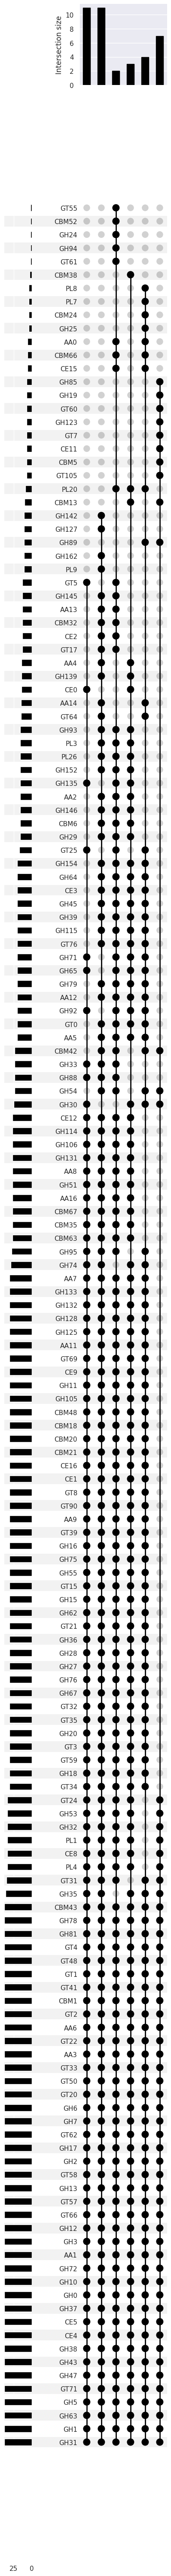

In [48]:
core_cazome_upsetplot_membership = []
core_cazome_upsetplot_membership = add_to_upsetplot_membership(
    core_cazome_upsetplot_membership,
    core_cazomes,
)
core_cazome_upsetplot = build_upsetplot(
    core_cazome_upsetplot_membership,
    sort_by='input',
    file_path='../results/core_cazome/genera_core_cazome.svg',
)

In [49]:
core_cazomes = {}  # {lineage: {fams}}
for lineage in ['Fungi', 'Oomycete']:
    filtered_df = fam_freq_df[fam_freq_df['Lineage'] == lineage]
    temp_core_cazome = identify_core_cazome(filtered_df[all_families])
    temp_core_cazome = list(temp_core_cazome)
    temp_core_cazome.sort()
    core_cazomes[lineage] = {'fams': temp_core_cazome, 'freqs': {len(filtered_df)}}
core_cazomes

Identifying core CAZome: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 20346.44it/s]


{'Fungi': {'fams': ['AA1',
   'AA3',
   'AA6',
   'AA7',
   'CBM18',
   'CBM21',
   'CBM43',
   'CBM48',
   'CE1',
   'CE4',
   'CE5',
   'CE9',
   'GH0',
   'GH10',
   'GH105',
   'GH11',
   'GH128',
   'GH13',
   'GH133',
   'GH15',
   'GH16',
   'GH17',
   'GH18',
   'GH2',
   'GH20',
   'GH27',
   'GH28',
   'GH3',
   'GH31',
   'GH36',
   'GH37',
   'GH38',
   'GH43',
   'GH47',
   'GH5',
   'GH55',
   'GH62',
   'GH63',
   'GH72',
   'GT1',
   'GT15',
   'GT2',
   'GT20',
   'GT21',
   'GT22',
   'GT3',
   'GT32',
   'GT33',
   'GT39',
   'GT4',
   'GT41',
   'GT48',
   'GT50',
   'GT57',
   'GT58',
   'GT59',
   'GT66',
   'GT69',
   'GT71',
   'GT8',
   'GT90'],
  'freqs': {32}},
 'Oomycete': {'fams': ['AA3',
   'AA6',
   'CBM43',
   'CBM5',
   'GH0',
   'GH1',
   'GH123',
   'GH17',
   'GH2',
   'GH3',
   'GH30',
   'GH31',
   'GH32',
   'GH35',
   'GH37',
   'GH38',
   'GH47',
   'GH5',
   'GH6',
   'GH63',
   'GH7',
   'GH72',
   'GH81',
   'GT1',
   'GT2',
   'GT20',
   'GT

/home/hobnobmancer/anaconda3/envs/pectobacteriaceae/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e'
 '#0000002e' '#0000002e' '#0000002e' '#0000002e' '#0000002e' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black' 'black'
 'black' 'black' 'black' 'black' 'black' 'black' 'bl

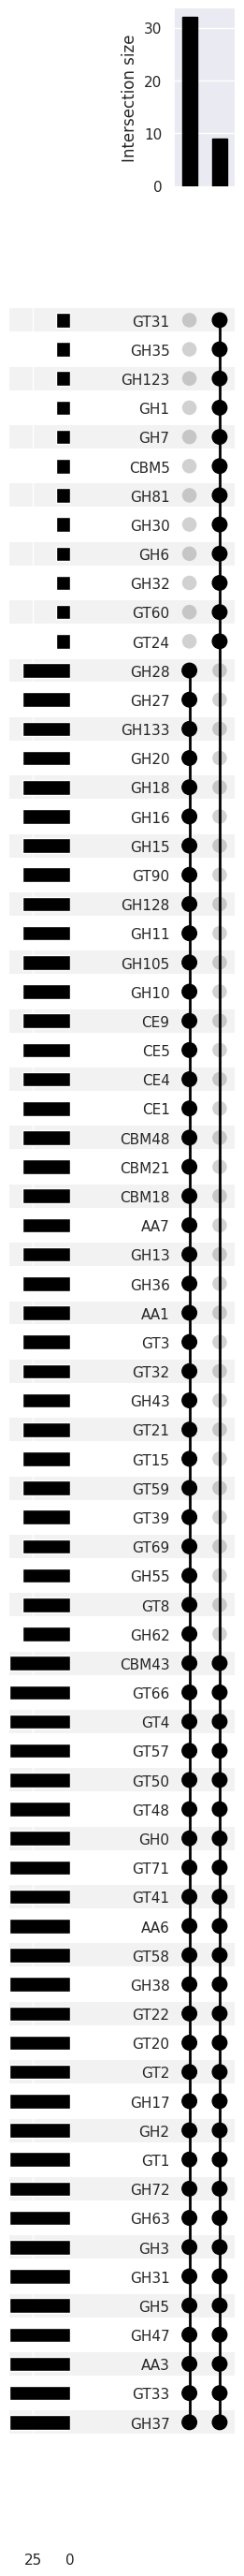

In [50]:
core_cazome_upsetplot_membership = []
core_cazome_upsetplot_membership = add_to_upsetplot_membership(
    core_cazome_upsetplot_membership,
    core_cazomes,
)
core_cazome_upsetplot = build_upsetplot(
    core_cazome_upsetplot_membership,
    sort_by='input',
    file_path='../results/core_cazome/lineage_core_cazome.svg',
)

<a name="co-occur"></a>
# Families that always co-occur

In [51]:
# make output dir for results, will not delete data if dir already exists
make_output_directory(Path('../results/cooccurring_families/'), force=True, nodelete=True)

cooccurring_fams_dict = calc_cooccuring_fam_freqs(
    fam_freq_df,
    list(all_families),
    exclude_core_cazome=False,
)
cooccurring_fams_dict

Output directory ../results/cooccurring_families exists, nodelete is True. Adding output to output directory.
Combining pairs of co-occurring families: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 672/672 [00:00<00:00, 244434.33it/s]


{0: {'fams': {'AA10', 'GH42', 'GH8', 'GH9', 'PL14', 'PL35'}, 'freqs': {1}},
 1: {'fams': {'AA11',
   'AA9',
   'CE16',
   'GH125',
   'GH132',
   'GH67',
   'GH75',
   'GH76',
   'GT34',
   'GT35'},
  'freqs': {31}},
 2: {'fams': {'AA12', 'GH64', 'GT0'}, 'freqs': {20}},
 3: {'fams': {'AA13', 'CBM32'}, 'freqs': {20}},
 4: {'fams': {'AA16', 'AA8', 'CBM63', 'CBM67', 'CE12'}, 'freqs': {27}},
 5: {'fams': {'AA2', 'GH146'}, 'freqs': {16}},
 6: {'fams': {'AA3',
   'AA6',
   'CBM43',
   'GH0',
   'GH17',
   'GH2',
   'GH3',
   'GH31',
   'GH37',
   'GH38',
   'GH47',
   'GH5',
   'GH63',
   'GH72',
   'GT1',
   'GT2',
   'GT20',
   'GT22',
   'GT33',
   'GT4',
   'GT41',
   'GT48',
   'GT50',
   'GT57',
   'GT58',
   'GT66',
   'GT71'},
  'freqs': {41}},
 7: {'fams': {'AA5', 'GH115'}, 'freqs': {28}},
 8: {'fams': {'AA7',
   'CBM21',
   'CBM48',
   'CE1',
   'CE9',
   'GH105',
   'GH11',
   'GH128',
   'GH133',
   'GH15',
   'GH20',
   'GH27',
   'GH36',
   'GH55',
   'GH62',
   'GT15',
   'GT2

In [52]:
# genus specific groups of always co-occurring families
genera_cooccuring_fams = {}  # {genus: cooccurring_fams_dict}

genera = FUNGI + OOMYCETE

for genus in tqdm(genera, desc="Identifying genus specific co-occurring fams"):
    genus_fam_freq_df = fam_freq_df[fam_freq_df['Genus'] == genus]
    if len(genus_fam_freq_df) == 1:
        continue  # need more than one genome
    genus_cooccurring_fams_dict = calc_cooccuring_fam_freqs(
        genus_fam_freq_df,
        list(all_families),
        exclude_core_cazome=False,
    )
    genera_cooccuring_fams[genus] = genus_cooccurring_fams_dict
    
for genus in tqdm(['Fungi', 'Oomycete'], desc="Identifying genus specific co-occurring fams"):
    genus_fam_freq_df = fam_freq_df[fam_freq_df['Lineage'] == genus]
    if len(genus_fam_freq_df) == 1:
        continue  # need more than one genome
    genus_cooccurring_fams_dict = calc_cooccuring_fam_freqs(
        genus_fam_freq_df,
        list(all_families),
        exclude_core_cazome=False,
    )
    genera_cooccuring_fams[genus] = genus_cooccurring_fams_dict
    
genera_cooccuring_fams

Identifying genus specific co-occurring fams:   0%|          | 0/11 [00:00<?, ?it/s]


Identifying pairs of co-occurring families: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 454.25it/s]

Combining pairs of co-occurring families: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 6218/6218 [00:00<00:00, 358249.18it/s]

Identifying pairs of co-occurring families: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 427.30it/s]

Combining pairs of co-occurring families: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 9214/9214 [00:00<00:00, 380613.15it/s]

Identifying pairs of co-occurring families: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 510.70it/s]

Combining pairs of co-occurring families: 100%|██

Identifying genus specific co-occurring fams:   0%|          | 0/2 [00:00<?, ?it/s]


Identifying pairs of co-occurring families: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 347.98it/s]

Combining pairs of co-occurring families: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2073/2073 [00:00<00:00, 176906.80it/s]

Identifying pairs of co-occurring families: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 1052.13it/s]

Combining pairs of co-occurring families: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 850/850 [00:00<00:00, 231203.53it/s]


{'Aspergillus': {0: {'fams': {'AA1',
    'AA11',
    'AA16',
    'AA3',
    'AA6',
    'AA7',
    'AA8',
    'AA9',
    'CBM1',
    'CBM18',
    'CBM20',
    'CBM21',
    'CBM35',
    'CBM43',
    'CBM48',
    'CBM63',
    'CBM67',
    'CE0',
    'CE1',
    'CE12',
    'CE16',
    'CE4',
    'CE5',
    'CE8',
    'CE9',
    'GH0',
    'GH1',
    'GH10',
    'GH105',
    'GH106',
    'GH11',
    'GH114',
    'GH12',
    'GH125',
    'GH128',
    'GH13',
    'GH131',
    'GH132',
    'GH133',
    'GH135',
    'GH15',
    'GH16',
    'GH17',
    'GH18',
    'GH2',
    'GH20',
    'GH27',
    'GH28',
    'GH3',
    'GH30',
    'GH31',
    'GH32',
    'GH33',
    'GH35',
    'GH36',
    'GH37',
    'GH38',
    'GH43',
    'GH47',
    'GH5',
    'GH51',
    'GH53',
    'GH55',
    'GH6',
    'GH62',
    'GH63',
    'GH65',
    'GH67',
    'GH7',
    'GH71',
    'GH72',
    'GH74',
    'GH75',
    'GH76',
    'GH78',
    'GH81',
    'GH88',
    'GH92',
    'GH95',
    'GT1',
    'GT15',
    '

/home/hobnobmancer/anaconda3/envs/pectobacteriaceae/lib/python3.11/site-packages/upsetplot/plotting.py:662: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['#0000002e' '#0000002e' '#0000002e' ... '#0000002e' '#0000002e'
 '#0000002e']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["edgecolor"].fillna(styles["facecolor"], inplace=True)
/home/hobnobmancer/anaconda3/envs/pectobacteriaceae/lib/python3.11/site-packages/upsetplot/plotting.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'solid' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles["linestyle"].fillna("solid", inplace=True)


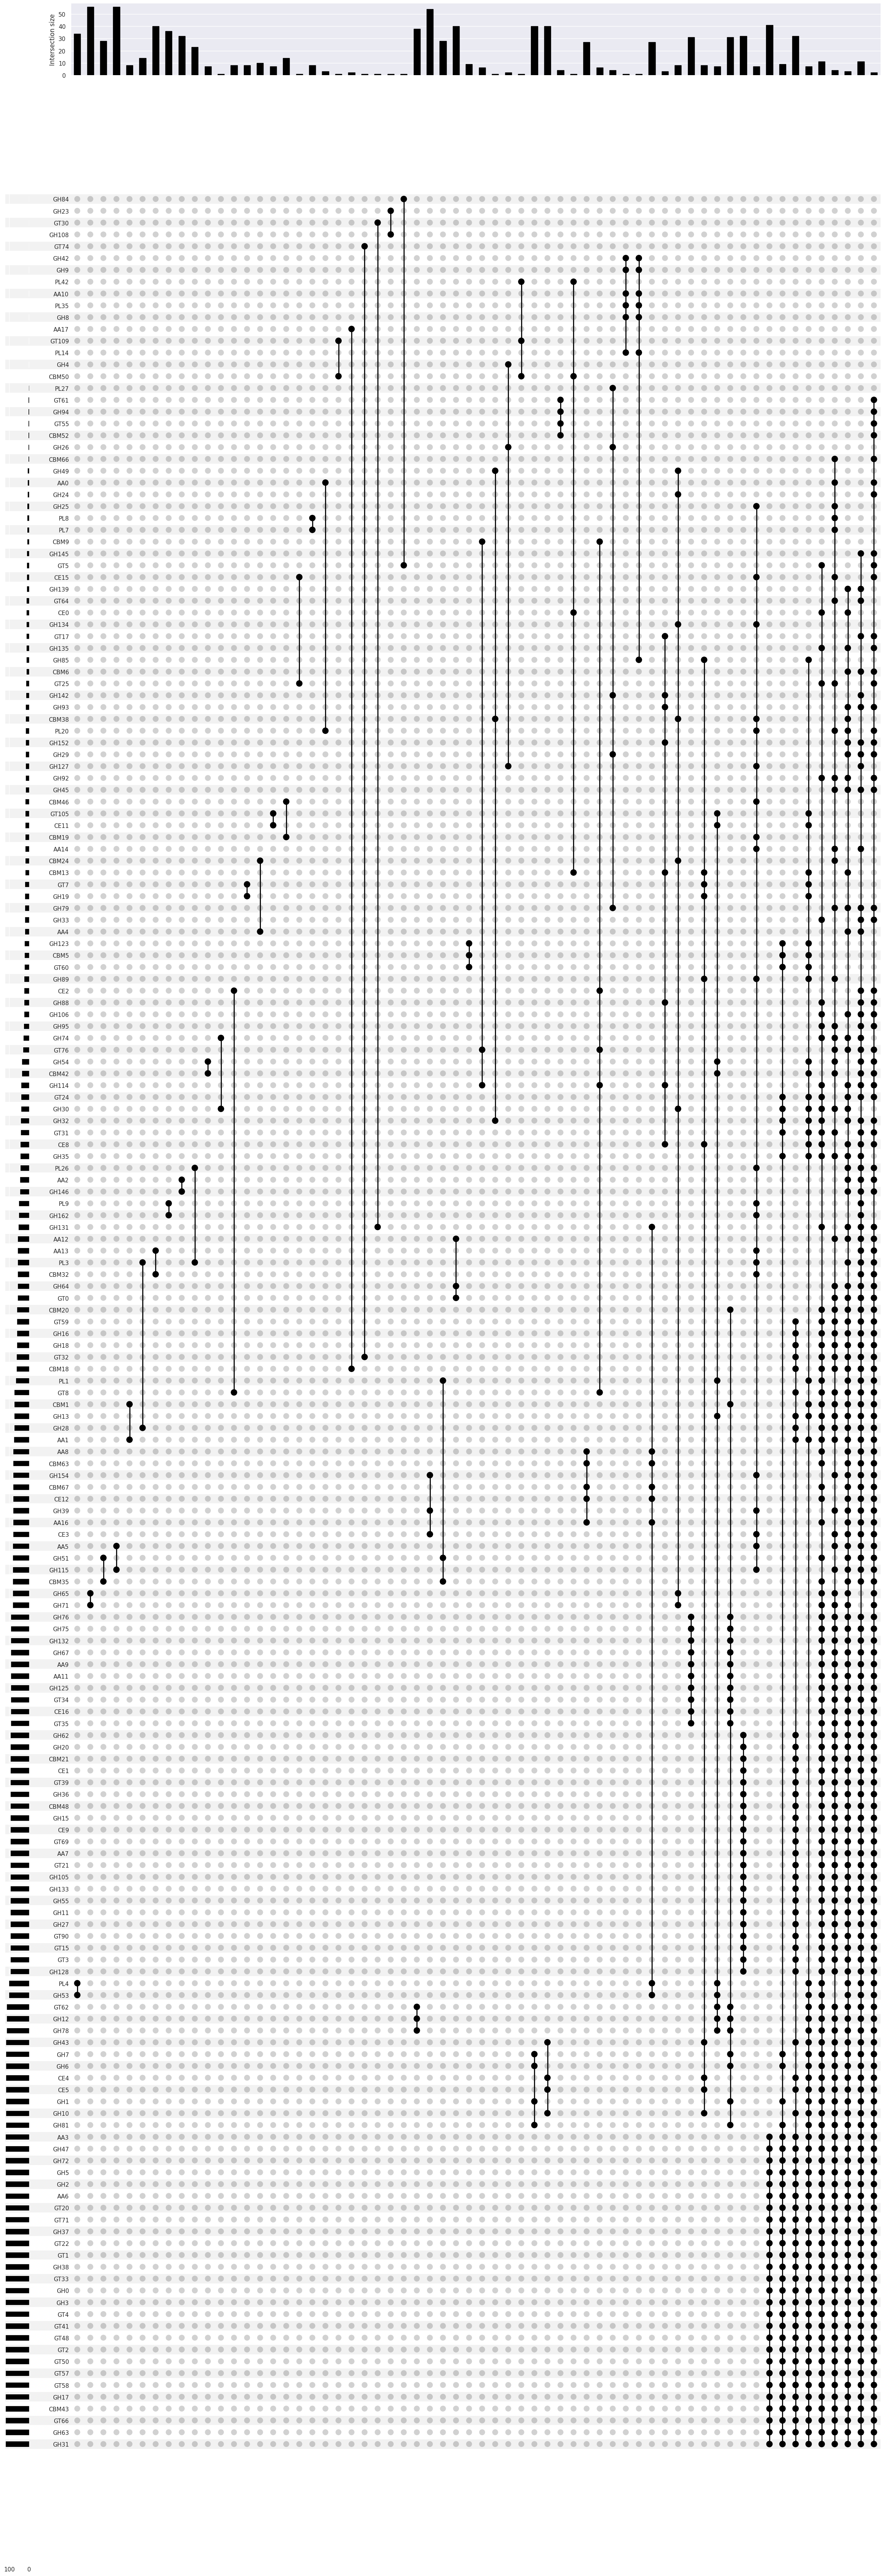

In [53]:
upsetplot_membership = []
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, cooccurring_fams_dict)

for genus in genera_cooccuring_fams:
    upsetplot_membership = add_to_upsetplot_membership(
        upsetplot_membership,
        genera_cooccuring_fams[genus],
    )

pectobact_upsetplot = build_upsetplot(
    upsetplot_membership,
    file_path='../results/cooccurring_families/cooccurring-families.svg',
)

In [54]:
upset_plot_groups = get_upsetplot_grps(upsetplot_membership)

cooccurring_grp_freq_data = []  # empty list to store data for the df

grp_order = ['All', 'Fungi'] + FUNGI + ['Oomycete'] + OOMYCETE
grp_order = [x for x in grp_order if x in ['Aspergillus', 'Fusarium', 'Magnaporthe', 'Rhynchosporium', 'Trichoderma', 'Phytophthora', 'Fungi', 'Oomycete', 'All']]
# add pectobacteriaceae data
genera_cooccuring_fams['All'] = cooccurring_fams_dict

# add data for each genus, all soft plant targeting and hard plant tissue targeting
cooccurring_grp_freq_data = add_upsetplot_grp_freqs(
    upset_plot_groups,
    cooccurring_grp_freq_data,
    genera_cooccuring_fams,
    genus,
    grp_sep=True,
    grp_order=grp_order,
    include_none=True,
)

# build the dataframe
cooccurring_fams_freq_df = build_upsetplot_matrix(
    cooccurring_grp_freq_data,
    'Genus',
    file_path='../results/cooccurring_families/cooccurring_fams_freqs.csv',
)
cooccurring_fams_freq_df

Compiling co-occurring families incidence data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 10583.49it/s]


Families           Genus  \
0                                             GH53+PL4             All   
1                                             GH53+PL4           Fungi   
2                                             GH53+PL4     Aspergillus   
3                                             GH53+PL4        Fusarium   
4                                             GH53+PL4     Magnaporthe   
..                                                 ...             ...   
553  GH31+GH63+GT66+CBM43+GH17+GT58+GT57+GT50+GT2+G...     Magnaporthe   
554  GH31+GH63+GT66+CBM43+GH17+GT58+GT57+GT50+GT2+G...  Rhynchosporium   
555  GH31+GH63+GT66+CBM43+GH17+GT58+GT57+GT50+GT2+G...     Trichoderma   
556  GH31+GH63+GT66+CBM43+GH17+GT58+GT57+GT50+GT2+G...        Oomycete   
557  GH31+GH63+GT66+CBM43+GH17+GT58+GT57+GT50+GT2+G...    Phytophthora   

     Incidence  
0         34.0  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
553        2.0  
554        NaN  
555        NaN  
556        NaN  
557        NaN  

[558 rows x 3 columns]

<a name="pca"></a>
# PCA

In [55]:
# make output dir for results, will not delete data if dir already exists
make_output_directory(Path('../results/pca/'), force=True, nodelete=True)

num_of_components = len(fam_freq_df_ggs)
pca, X_scaled = perform_pca(fam_freq_df_ggs, num_of_components)
pca

Output directory ../results/pca exists, nodelete is True. Adding output to output directory.


PCA(n_components=41)

100.0% of the variance in the data set was catpured by the PCA
Number of features needed to explain 0.95 fraction of total variance is 14. 


<Figure size 640x480 with 0 Axes>

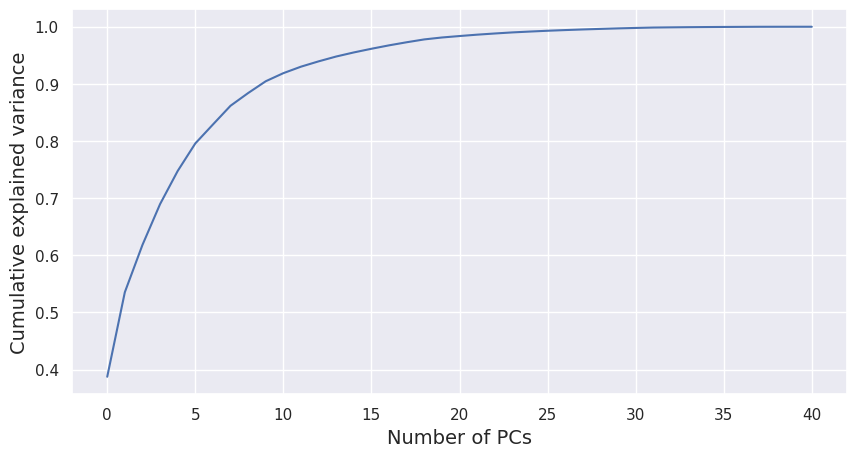

In [56]:
print(
    f"{round(pca.explained_variance_ratio_.sum() * 100, 2)}% "
    "of the variance in the data set was catpured by the PCA"
)

cumExpVar = plot_explained_variance(
    pca,
    num_of_components,
    file_path="../results/pca/pca_explained_variance.png",
);

Explained variance for 1PC: 0.3874307661610387
Explained variance for 2PC: 0.14799717360733938
Explained variance for 3PC: 0.08271413275320456
Explained variance for 4PC: 0.07145387513086777
Explained variance for 5PC: 0.05795313055797177
Explained variance for 6PC: 0.0482065058819142
Explained variance for 7PC: 0.03313296265950686
Explained variance for 8PC: 0.03284034100329097
Explained variance for 9PC: 0.022232961529797562
Explained variance for 10PC: 0.02066430481162001


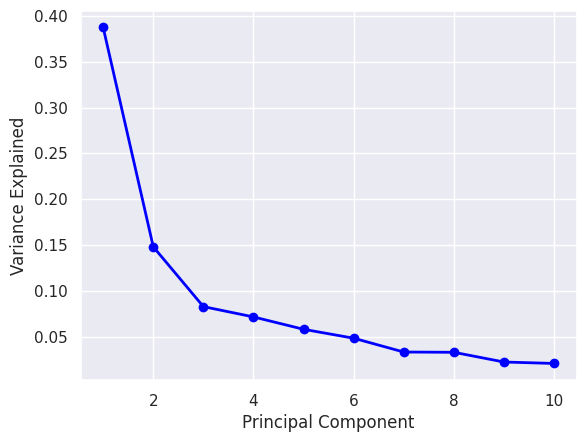

In [57]:
plot_scree(pca, nComp=10, file_path="../results/pca/pca_scree.png")

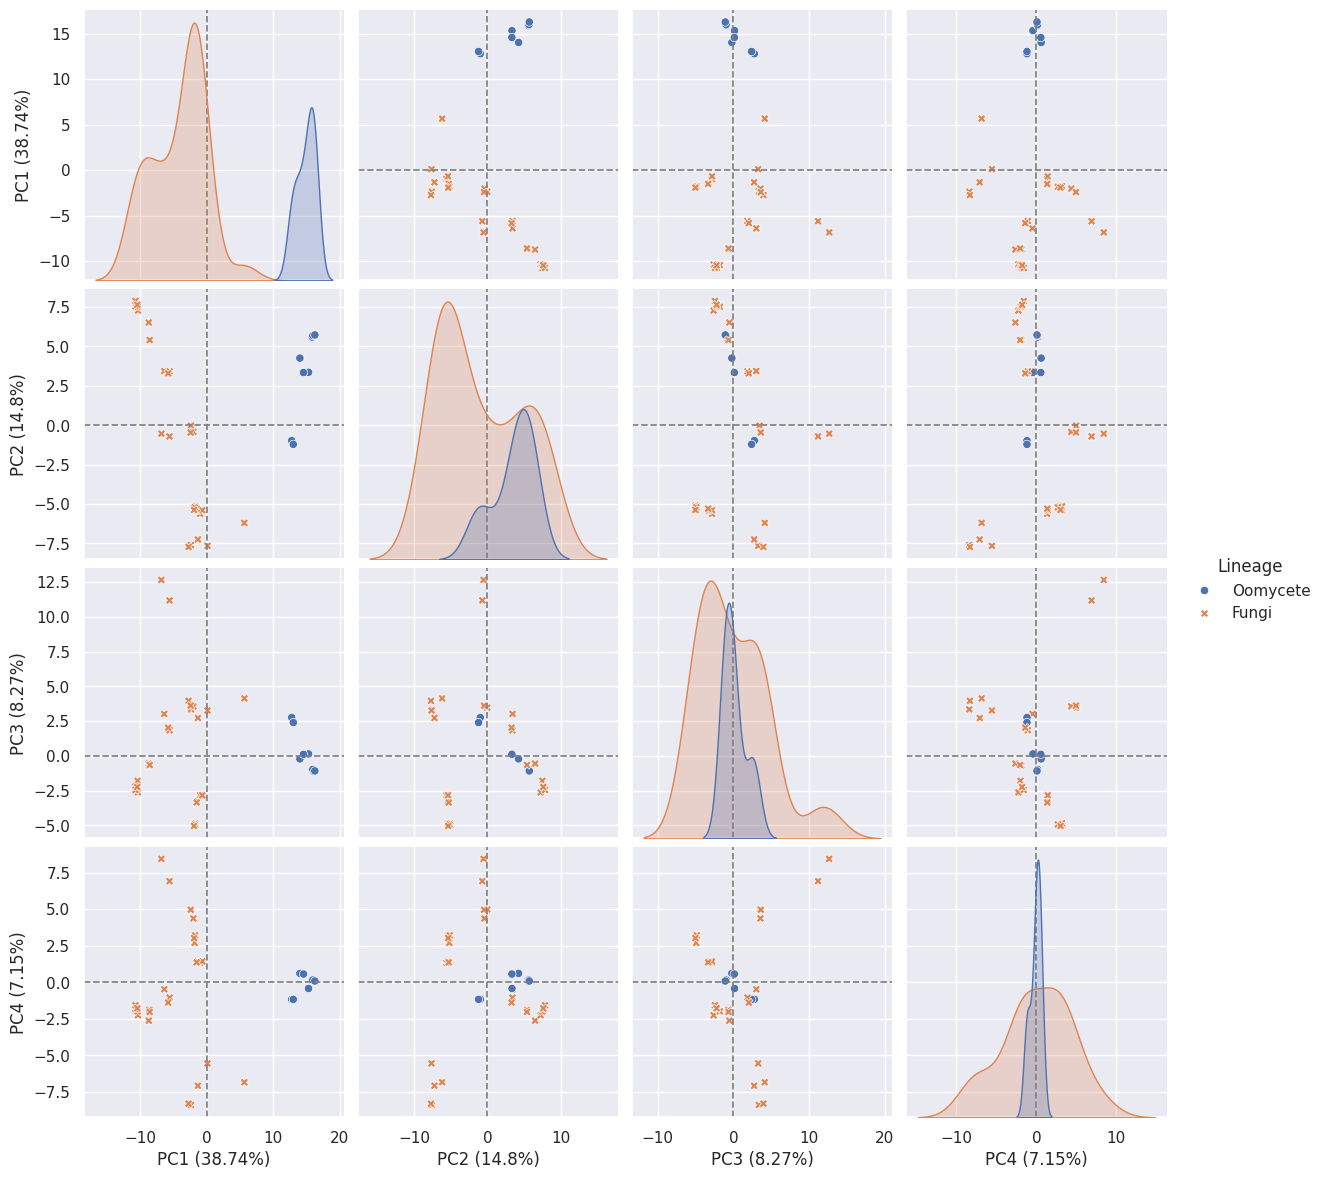

In [58]:
fam_freq_df_ggs['Lineage'] = list(fam_freq_df['Lineage'])
fam_freq_df_ggs['Genus'] = list(fam_freq_df['Genus'])
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])

X_pca = pca.transform(X_scaled)

fam_freq_df_ggs_pc = copy(fam_freq_df_ggs)
colnames = []
for i in range(4):
    fam_freq_df_ggs_pc[f'PC{i+1} ({round(pca.explained_variance_ratio_[i] * 100, 2)}%)'] = X_pca[:,i]
    colnames.append(f'PC{i+1} ({round(pca.explained_variance_ratio_[i] * 100, 2)}%)')

g = sns.pairplot(
    fam_freq_df_ggs_pc,
    vars=colnames,
    hue="Lineage",
    diag_kind="kde",
    markers=['o','X'],
    height=3,
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1
    
plt.savefig(
    '../results/pca/pca_pc_screen_lineage.svg',
    bbox_inches='tight',
    format='svg'
)

In [59]:
len(set(fam_freq_df['Species'])) # == len(['o','X', '^', 'P', 'v', 'D', '<', 's', '*'])

18

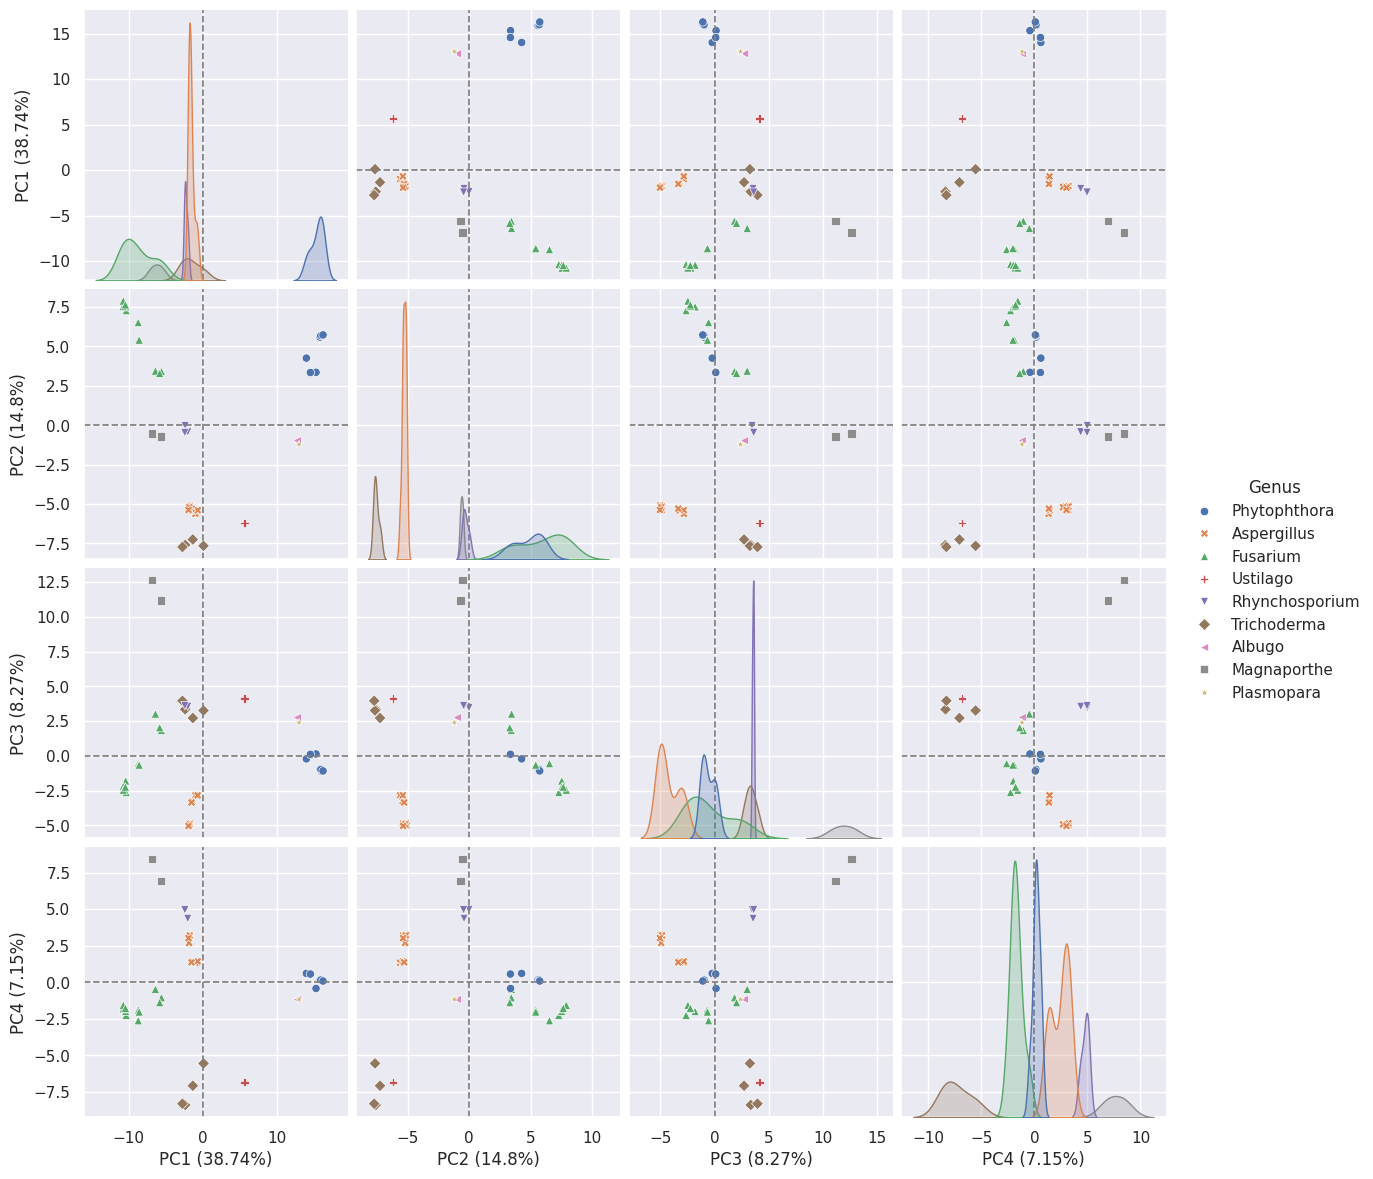

In [60]:
fam_freq_df_ggs_pc = copy(fam_freq_df_ggs)
colnames = []
for i in range(4):
    fam_freq_df_ggs_pc[f'PC{i+1} ({round(pca.explained_variance_ratio_[i] * 100, 2)}%)'] = X_pca[:,i]
    colnames.append(f'PC{i+1} ({round(pca.explained_variance_ratio_[i] * 100, 2)}%)')

g = sns.pairplot(
    fam_freq_df_ggs_pc,
    vars=colnames,
    hue="Genus",
    diag_kind="kde",
    markers=['o','X', '^', 'P', 'v', 'D', '<', 's', '*'],
    height=3,
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1
    
plt.savefig(
    '../results/pca/pca_pc_screen_genus.svg',
    bbox_inches='tight',
    format='svg'
)

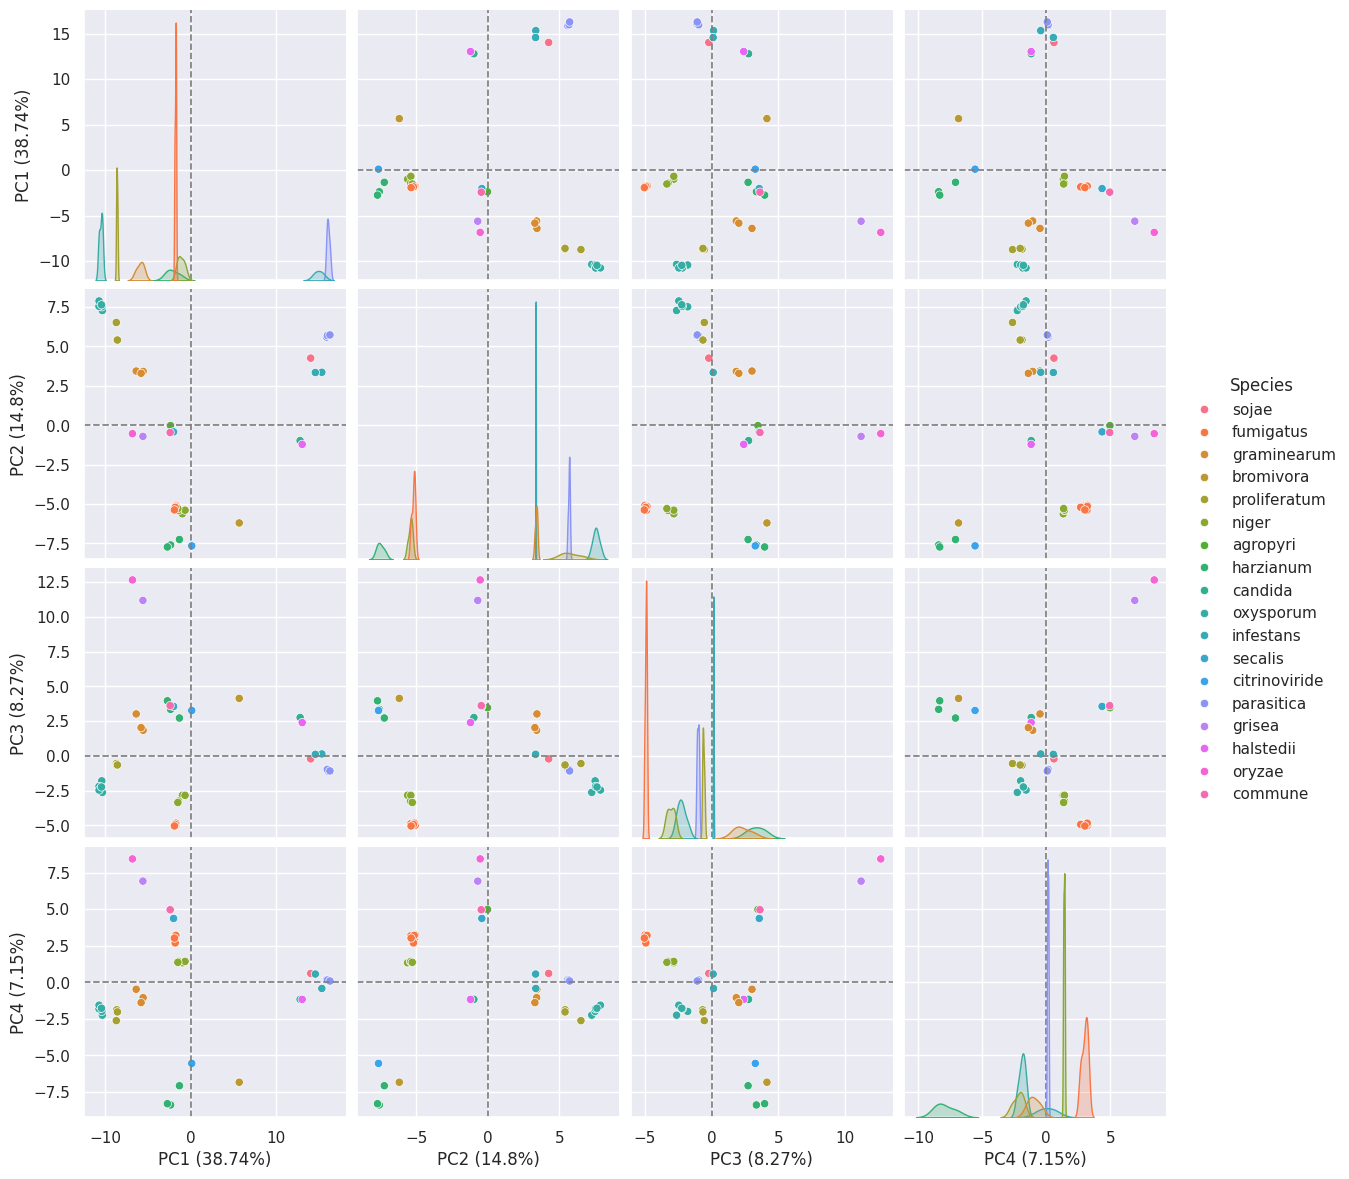

In [61]:
fam_freq_df_ggs_pc = copy(fam_freq_df_ggs)
colnames = []
for i in range(4):
    fam_freq_df_ggs_pc[f'PC{i+1} ({round(pca.explained_variance_ratio_[i] * 100, 2)}%)'] = X_pca[:,i]
    colnames.append(f'PC{i+1} ({round(pca.explained_variance_ratio_[i] * 100, 2)}%)')

g = sns.pairplot(
    fam_freq_df_ggs_pc,
    vars=colnames,
    hue="Species",
    diag_kind="kde",
    height=3,
);

i = 0
for ax in g.axes.ravel():
    if ax is None:
        continue
    if i not in [0,5,10,15]:
        ax.axhline(0, linestyle='--', color='grey', linewidth=1.25);
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    else:
        ax.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    i += 1
    
plt.savefig(
    '../results/pca/pca_pc_screen_species.svg',
    bbox_inches='tight',
    format='svg'
)

## Plot loadings plot and individual plots

In [62]:
plot_loadings?

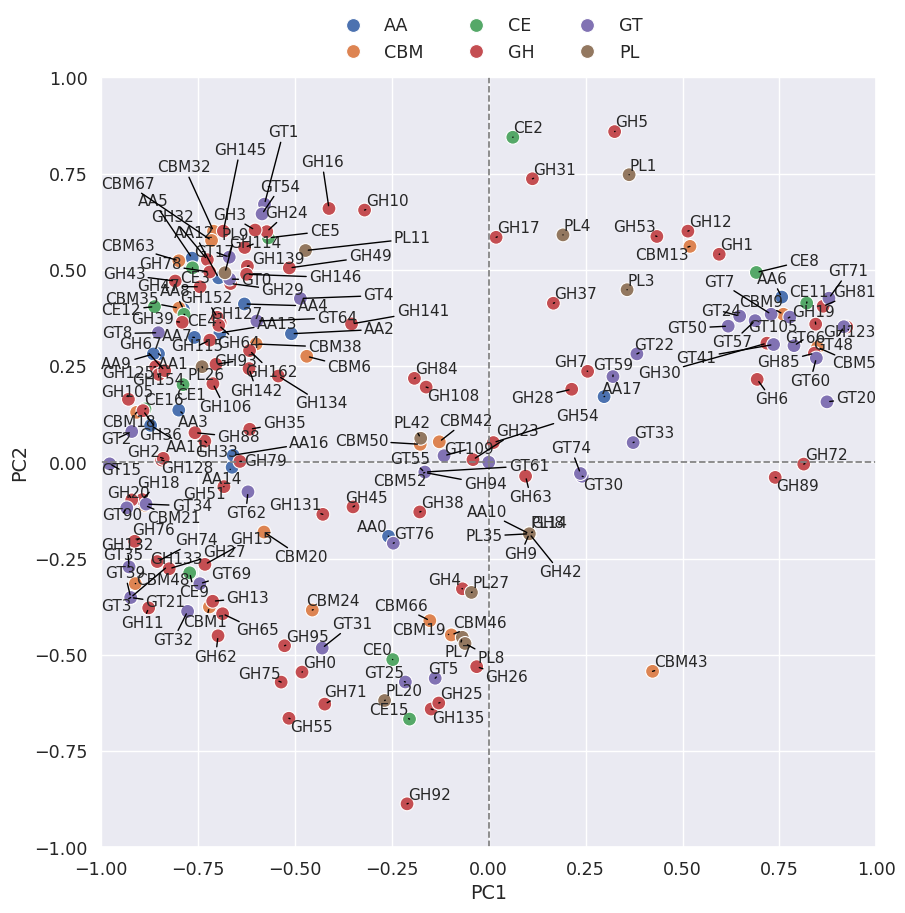

In [63]:
plot_loadings(
        pca,
        fam_freq_df_ggs[all_families],
        1,
        2,
        threshold=0,
        fig_size=(10,10),
        font_size=11,
        file_format='pdf',
        file_path='../results/pca/pcaPc1Pc2Loading.pdf'
    );

Parsing 1 2
Parsing 1 3
Parsing 1 4
Parsing 2 3
Parsing 2 4
Parsing 3 4


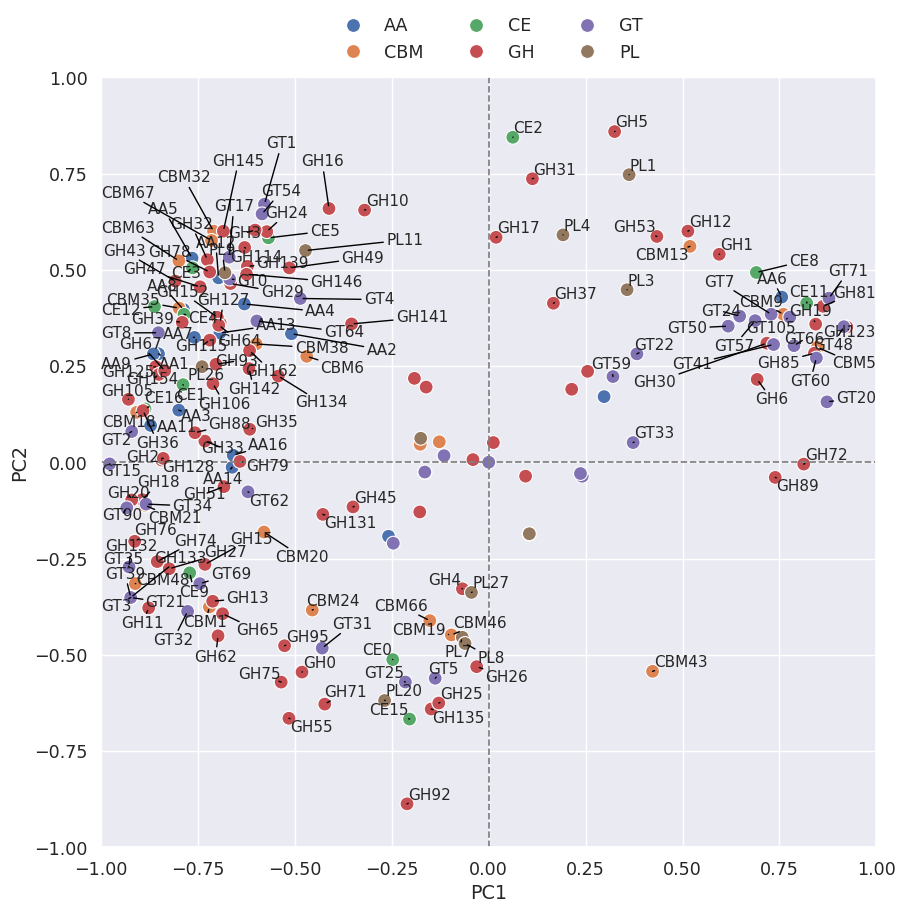

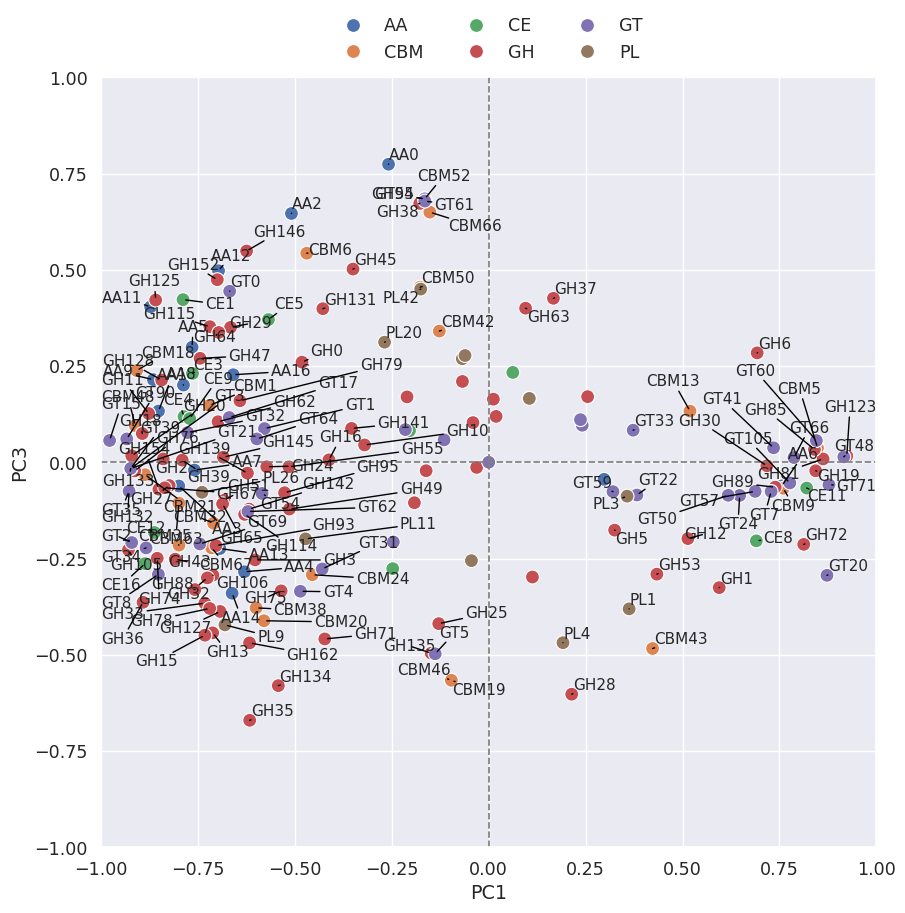

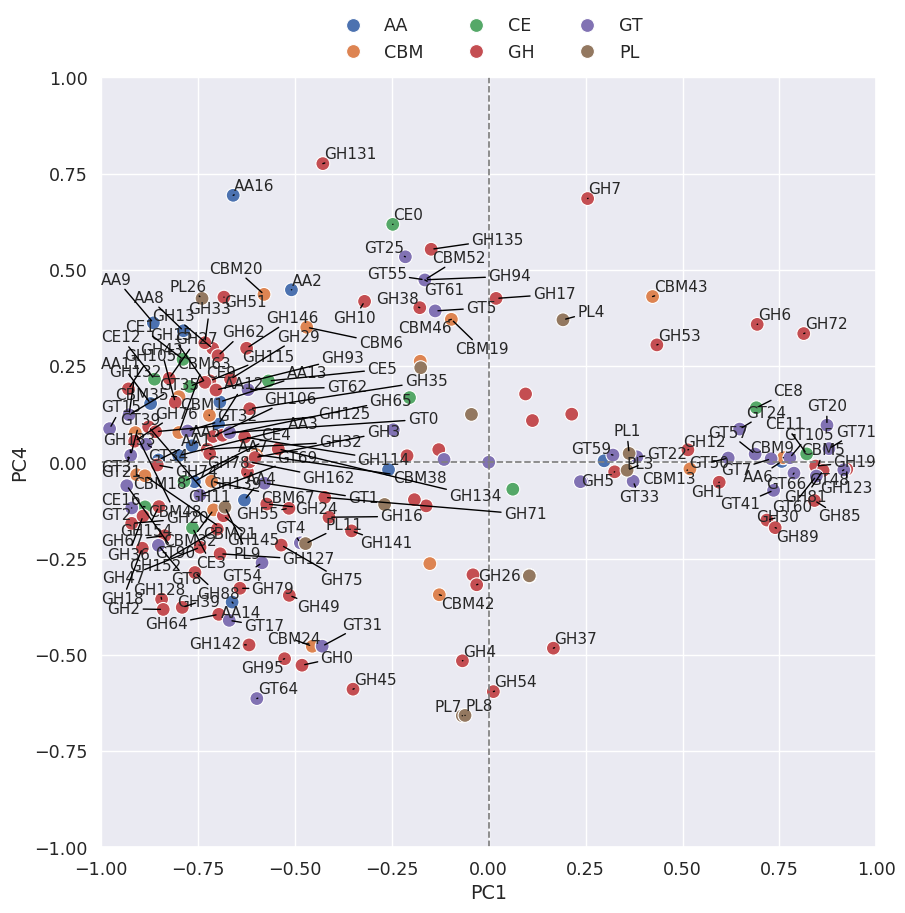

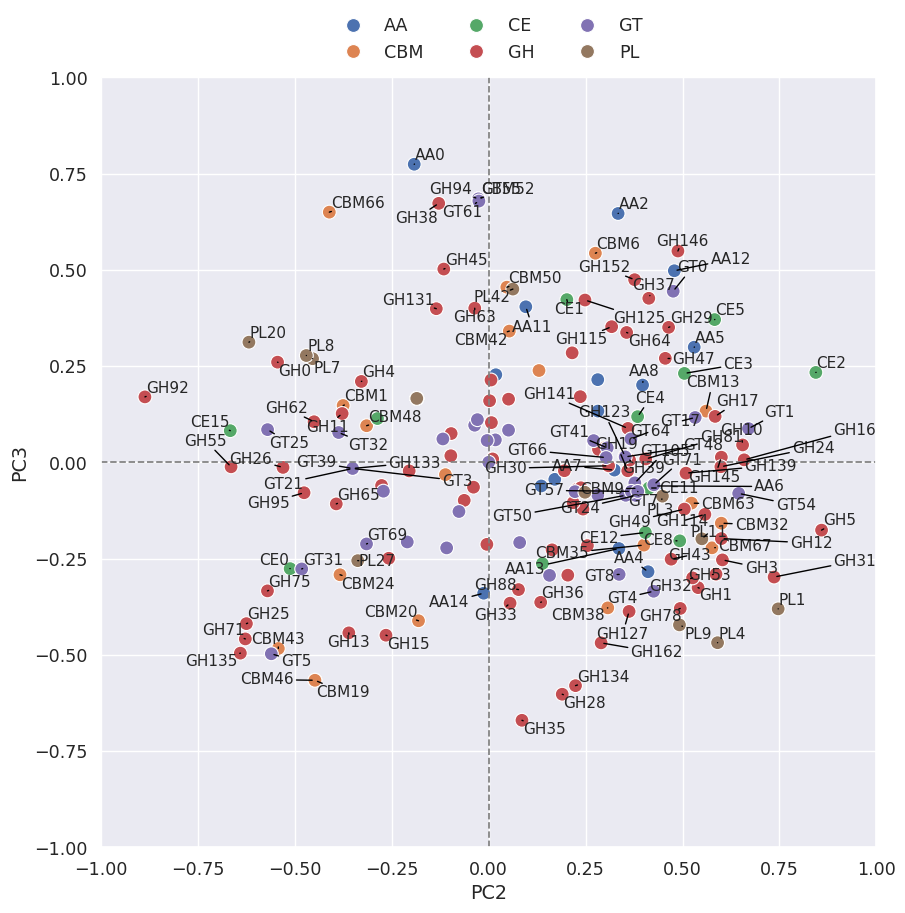

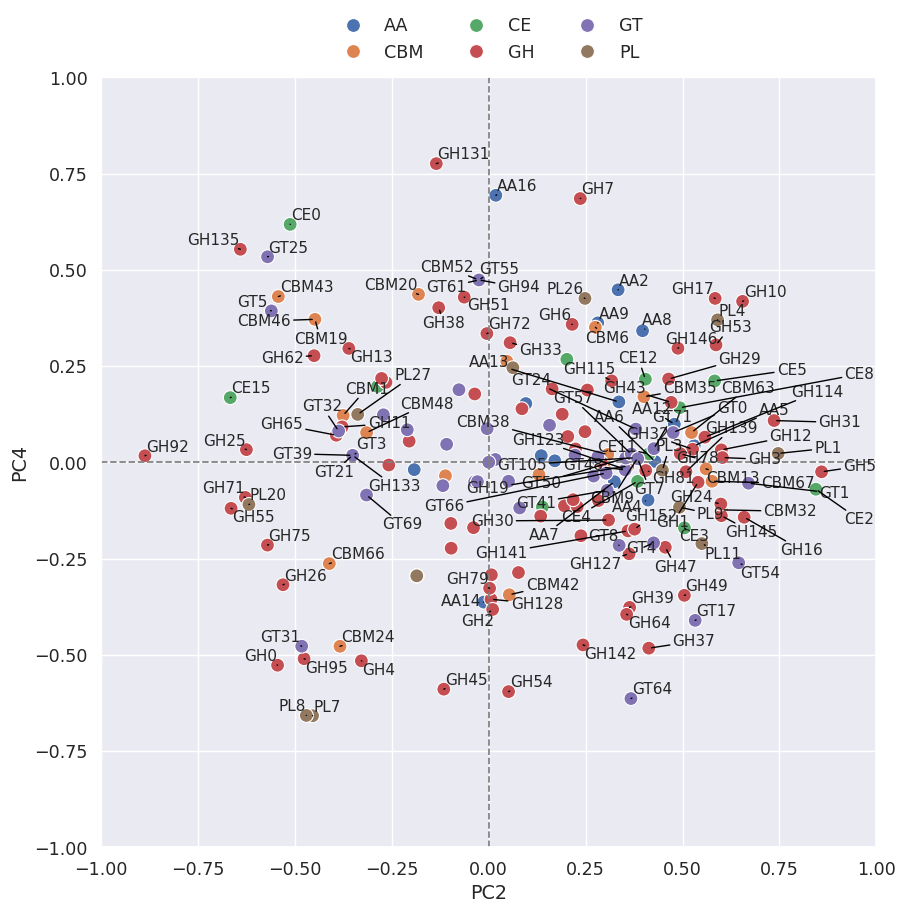

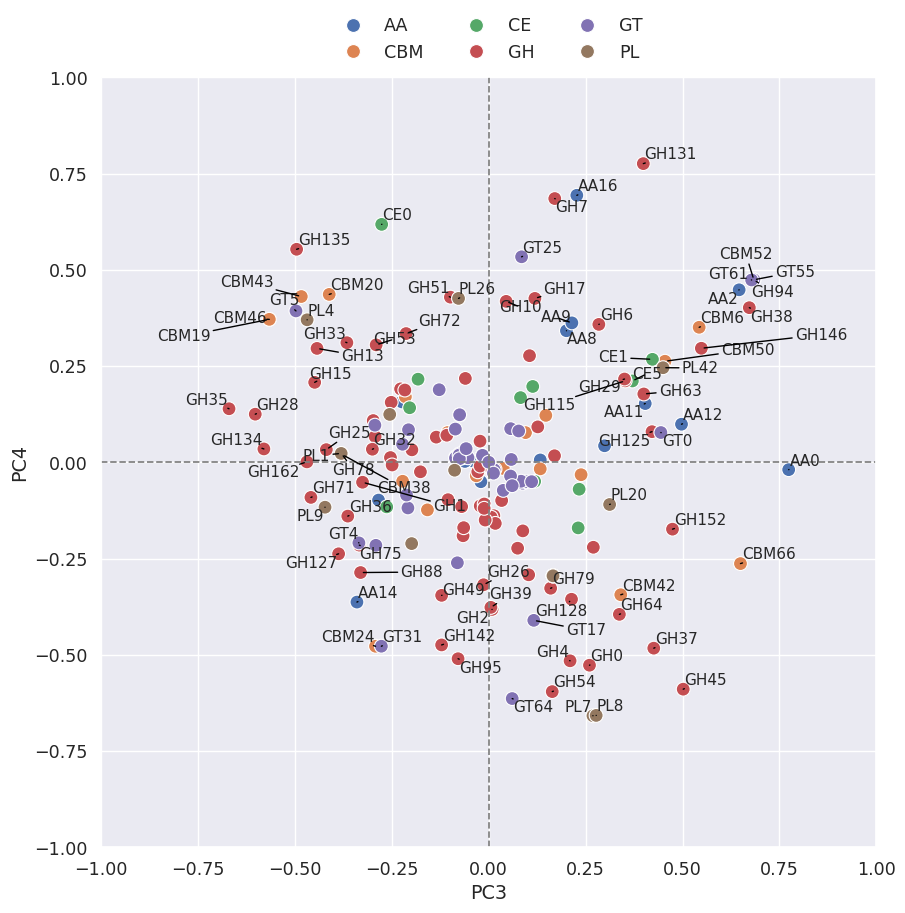

In [64]:
for i in range(1,5):
    for j in range(1,5):
        if j <= i:
            continue
        print('Parsing', i, j)
        out = f'../results/pca/pca_pc{i}_pc{j}_loadings.pdf'
        g = plot_loadings(
            pca,
            fam_freq_df_ggs[all_families],
            i,
            j,
            threshold=0.3,
            fig_size=(10,10),
            file_path=out,
            font_size=11,
        );
        time.sleep(60)

Parsing 1 2
Not applying hue order
Applying style
Not applying style order
Parsing 1 3
Not applying hue order
Applying style
Not applying style order
Parsing 1 4
Not applying hue order
Applying style
Not applying style order
Parsing 2 3
Not applying hue order
Applying style
Not applying style order
Parsing 2 4
Not applying hue order
Applying style
Not applying style order
Parsing 3 4
Not applying hue order
Applying style
Not applying style order


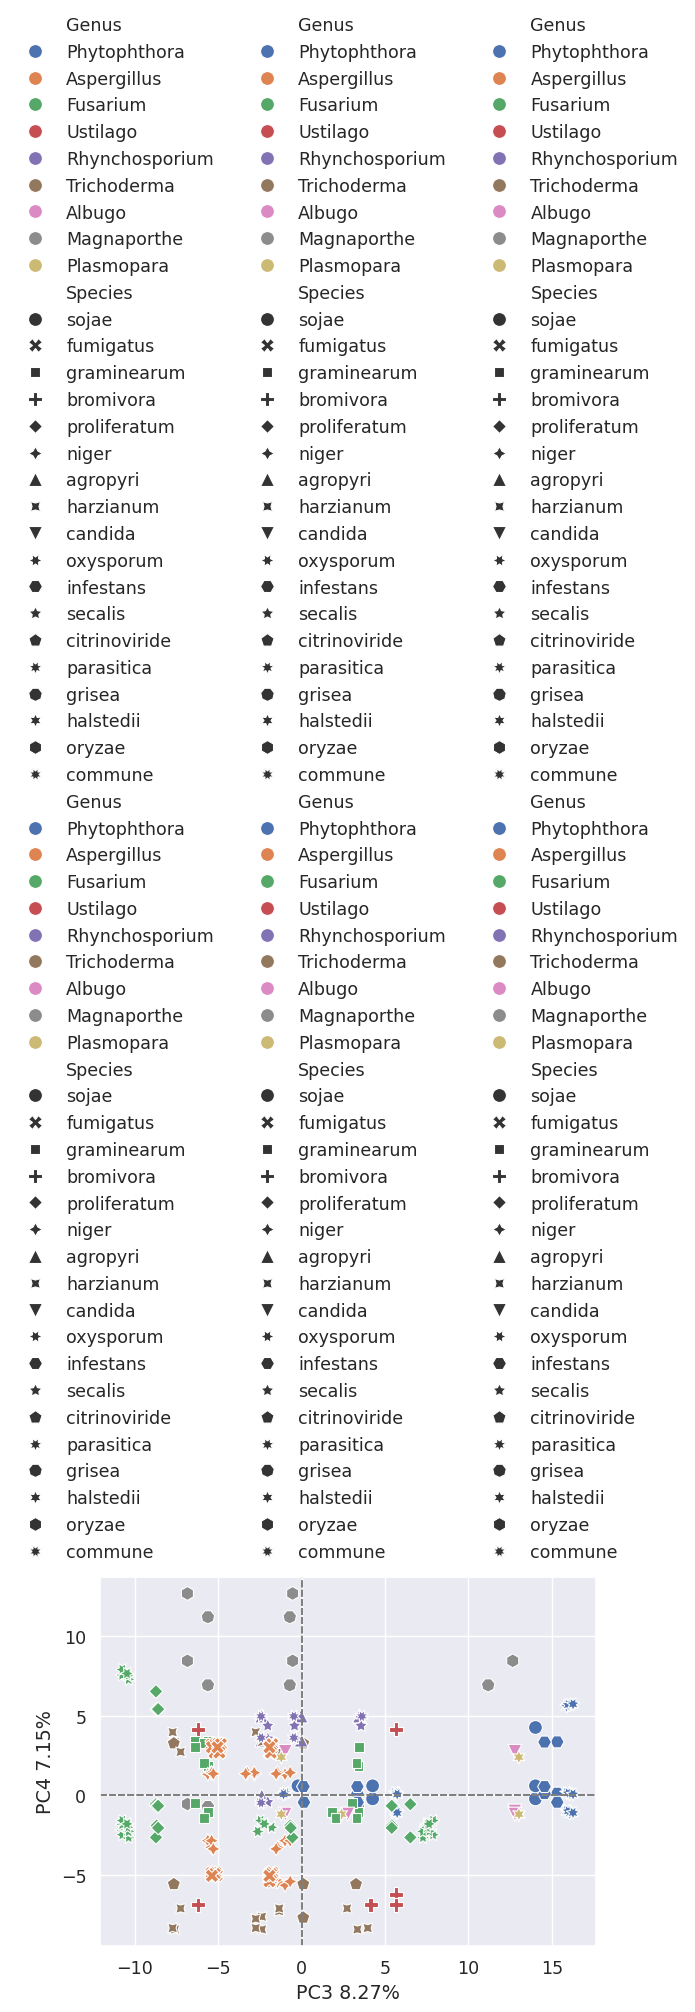

In [65]:
for i in range(1,5):
    for j in range(1,5):
        if j <= i:
            continue
        print('Parsing', i, j)
        out = f'../results/pca/pca_pc{i}_pc{j}.pdf'
        g = plot_pca(
            pca,
            X_scaled,
            fam_freq_df_ggs,
            i,
            j,
            'Genus',
            style='Species',
            file_path=out,
        );
        time.sleep(60)

# RareFaction curves

In [66]:
lineage_col = []
for ri in range(len(og_fgp_df)):
    if og_fgp_df.iloc[ri]['Genus'] in FUNGI:
        lineage_col.append('Fungi')
    else:
        lineage_col.append('Oomycete')

og_fgp_df['Lineage'] = lineage_col

In [67]:
cazy_fgp_df = og_fgp_df[og_fgp_df['Classifier'] == 'CAZy']
dbcan_fgp_df = og_fgp_df[og_fgp_df['Classifier'] == 'dbCAN']
cazy_fam_freq_df = build_fam_freq_df(cazy_fgp_df, ['Lineage', 'Genus', 'Species'])
dbcan_fam_freq_df = build_fam_freq_df(dbcan_fgp_df, ['Lineage', 'Genus', 'Species'])

The dataset contains 166 CAZy families


Counting fam frequencies: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.69it/s]


The dataset contains 190 CAZy families


Counting fam frequencies: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 14.62it/s]


In [68]:
# check for CAZy annotations not found by dbCAN
unique_annotations = []
for protein in tqdm(set(cazy_fgp_df['Protein']), desc="Checking for unique CAZy annotations"):
    c_prot_row = cazy_fgp_df[cazy_fgp_df['Protein'] == protein]
    c_fams = set(c_prot_row['Family'])
    d_prot_row = dbcan_fgp_df[dbcan_fgp_df['Protein'] == protein]
    d_fams = set(d_prot_row['Family'])
    # what is in CAZy but not dbCAN
    if len(c_fams.difference(d_fams)) != 0:
        print(f'{protein}: {c_fams.difference(d_fams)}')
        unique_annotations.append(unique_annotations)
print(f"CAZy contained {len(unique_annotations)} annotations not found by dbCAN")

Checking for unique CAZy annotations:   0%|          | 0/1284 [00:00<?, ?it/s]

CEF85488.1: {'GH16'}
SAM82152.1: {'GT1'}
QBZ57443.1: {'GH16'}
CEF87943.1: {'CBM1'}
QBZ58603.1: {'CBM18'}
SAM81579.1: {'GH26'}
CEF75329.1: {'CBM1'}
QBZ61671.1: {'CBM1'}
QBZ57401.1: {'GT1'}
QBZ64986.1: {'CBM1'}
CEF82863.1: {'CBM18'}
SAM84190.1: {'GT2'}
CEF74496.1: {'CBM50'}
SAM85033.1: {'GH0'}
CEF79695.1: {'CBM50'}
SAM86009.1: {'GH45'}
CEF76012.1: {'CBM50'}
CEF73821.1: {'GT1'}
QBZ60813.1: {'GH18'}
QBZ58410.1: {'GH5'}
QBZ55418.1: {'CBM50'}
CEF85929.1: {'GT1'}
CEF74523.1: {'CBM50'}
QBZ56316.1: {'CBM50'}
QBZ56737.1: {'GH18'}
CEF85049.1: {'CE8'}
SAM84175.1: {'GH0'}
CEF86939.1: {'GT1'}
SAM84191.1: {'GH16'}
XP_001395682.1: {'GT109'}
QBZ60874.1: {'CBM50'}
CEF83616.1: {'CBM50'}
CEF77547.1: {'GT109'}
QBZ62532.1: {'GH55'}
QBZ62738.1: {'GH55'}
QBZ65056.1: {'CBM50'}
QBZ58148.1: {'CBM50'}
QBZ56841.1: {'CBM1'}
SCB64505.1: {'CBM48'}
QBZ57495.1: {'CBM18'}
QBZ64470.1: {'PL42'}
SAM82983.1: {'GH16'}
CEF83009.1: {'CE0'}
CEF88725.1: {'GT109'}
SAM76181.1: {'GT1'}
CEF75431.1: {'GH0'}
CEF86182.1: {'GT2'}
QBZ648

In [69]:
# check for CAZy annotations not found by dbCAN
unique_annotations = []
for protein in tqdm(set(dbcan_fgp_df['Protein']), desc="Checking for unique CAZy annotations"):
    c_prot_row = cazy_fgp_df[cazy_fgp_df['Protein'] == protein]
    c_fams = set(c_prot_row['Family'])
    d_prot_row = dbcan_fgp_df[dbcan_fgp_df['Protein'] == protein]
    d_fams = set(d_prot_row['Family'])
    # what is in CAZy but not dbCAN
    if len(d_fams.difference(c_fams)) != 0:
        print(f'{protein}: {d_fams.difference(c_fams)}')
        unique_annotations.append(unique_annotations)
print(f"dbCAN found {len(unique_annotations)} annotations not found in CAZy")

Checking for unique CAZy annotations:   0%|          | 0/18595 [00:00<?, ?it/s]

OXN23975.1: {'GT25'}
KAF4128126.1: {'GH81'}
KAF4289603.1: {'GT5', 'GH13'}
EYB30995.1: {'AA1'}
SCO91311.1: {'GH35'}
ETL49375.1: {'GT20'}
XP_030984693.1: {'GH38'}
CVK89556.1: {'GH43'}
XP_024579004.1: {'GT48'}
XP_009522009.1: {'PL3'}
OXN06862.1: {'GH17'}
RKL36645.1: {'PL11'}
CEF75300.1: {'CBM18'}
RBA11792.1: {'GH3'}
RKK81822.1: {'CE8'}
PKK50336.1: {'GH18'}
PCD34180.1: {'GT8'}
OXN27495.1: {'GH93'}
SCO87348.1: {'GH39'}
RKL35076.1: {'GH125'}
RKL43687.1: {'GH154'}
KAF4144196.1: {'GH5'}
KAF4258722.1: {'GH114'}
CVL04270.1: {'AA6'}
XP_030986482.1: {'GT1'}
SCO85670.1: {'AA12'}
RKK95231.1: {'CBM35', 'GH43'}
RKL37203.1: {'CE1'}
KAF4255484.1: {'GH16'}
KKP00725.1: {'GT2'}
ETM51328.1: {'GH30'}
CZT53043.1: {'GT15'}
CZT43723.1: {'GH30'}
CZT13634.1: {'CBM1', 'GH5'}
RKL26559.1: {'GT8'}
CVK85309.1: {'GH74'}
SCO76402.1: {'GH43'}
KAF4260238.1: {'GH128'}
ETM56245.1: {'GT20'}
RKL03548.1: {'GH13'}
SCO78330.1: {'GH78', 'CBM67'}
XP_030983821.1: {'GH17'}
CVL09126.1: {'GT2'}
RKL44907.1: {'GH75'}
CZT13635.1: {'GH35'

TPR04146.1: {'CE12'}
KAF4277156.1: {'GH16'}
RBA21713.1: {'GH105'}
KAF4257227.1: {'GH76'}
CZT46026.1: {'AA3'}
CZT45629.1: {'AA1'}
EYB24954.1: {'AA0'}
EYB32511.1: {'GT8'}
XP_001390778.2: {'GH13'}
TPR01846.1: {'CE0'}
CZT12515.1: {'GH5'}
KAF4132156.1: {'GH31'}
EYB24736.1: {'GH43'}
CZS96445.1: {'GT4'}
CVK98936.1: {'CE8'}
XP_001399199.2: {'GH2'}
KAF4272001.1: {'GT5', 'GH13'}
XP_030978617.1: {'GH29'}
PKK41153.1: {'GH47'}
SPB42791.1: {'GH105'}
RKK91706.1: {'GH55'}
SPB46132.1: {'AA3'}
OXN08924.1: {'GT39'}
EYB21727.1: {'CE12'}
KKP06443.1: {'AA1'}
CZT11554.1: {'CBM1', 'GH7'}
CZT49579.1: {'GH67'}
CZS95966.1: {'CE8'}
ETL93694.1: {'GT2'}
GAQ41403.1: {'GH5'}
KKO97602.1: {'AA1'}
CZT46505.1: {'GH18'}
KAF4128113.1: {'GH81'}
XP_024752555.1: {'GH2'}
ETK95113.1: {'GT71'}
TPR10448.1: {'GH28'}
EYB32132.1: {'PL3'}
TPR08843.1: {'GH72'}
XP_001390822.1: {'AA1'}
RKL27473.1: {'GH141'}
RKL16664.1: {'GH43'}
CVL07149.1: {'GT8'}
CZT09638.1: {'GH31'}
XP_024572332.1: {'GH5'}
RKL07739.1: {'GH13'}
RKK66920.1: {'GH30'}
KKP

RKL23387.1: {'GT1'}
CZT12604.1: {'GH43'}
XP_009520587.1: {'PL3'}
KAF4251927.1: {'PL1'}
RKL20474.1: {'GT1'}
ETK93223.1: {'GH30'}
RKK95160.1: {'GH43'}
KKP01590.1: {'GT50'}
EYB25233.1: {'GH125'}
XP_001396571.2: {'GH32'}
ETL39223.1: {'GH31'}
SPB42479.1: {'PL27'}
RKL08749.1: {'GH47'}
RKK84288.1: {'GH12'}
XP_001391117.1: {'GH78'}
KAF4281995.1: {'GT4'}
XP_024578017.1: {'GH81'}
RKK98479.1: {'CBM6', 'GH43'}
XP_001394100.1: {'CE4', 'CBM18'}
KAF4282186.1: {'GT20'}
SCO76041.1: {'AA1'}
SCO78431.1: {'GT64'}
PCD39824.1: {'GH3'}
OXN26002.1: {'GH76'}
CZT41706.1: {'CBM38', 'GH32'}
RKL04196.1: {'AA11'}
PKK53909.1: {'GH71', 'CBM24'}
PCD30049.1: {'PL20'}
XP_024582860.1: {'CE4'}
CVL09737.1: {'GT2'}
XP_009523193.1: {'CE8'}
GAQ43591.1: {'GT2'}
RKK79408.1: {'GH31'}
CVL12466.1: {'CE3'}
RKL51625.1: {'CBM1'}
SPB51747.1: {'GH28'}
PCD39436.1: {'AA11'}
PKK48894.1: {'CBM1', 'GH18'}
XP_001395879.1: {'GH32'}
RKK84020.1: {'CBM63'}
KAF4276720.1: {'GH105'}
PNP55375.1: {'GT25'}
OXN23618.1: {'GH31'}
XP_001400760.1: {'GH79'}

ETL47330.1: {'PL3'}
PCD32075.1: {'GH16'}
KKO99424.1: {'CBM1'}
KAF4256104.1: {'GH62'}
RKK67722.1: {'AA1'}
XP_009538540.1: {'GH1'}
RKK95270.1: {'CE4', 'CBM18'}
PNP49709.1: {'AA3'}
RKL30455.1: {'GH1'}
RKL00456.1: {'AA8', 'AA3'}
KAF4031359.1: {'GH17'}
ETL30143.1: {'GH5'}
KAF4289262.1: {'GH17'}
ETL97237.1: {'CE8'}
XP_024748433.1: {'GH30'}
RKL25846.1: {'CBM1', 'GH6'}
ETK81542.1: {'GT71'}
XP_024746067.1: {'AA3'}
ETL91805.1: {'GH72'}
XP_024750192.1: {'GT20'}
RKL05767.1: {'CE5'}
PCD23101.1: {'GT4'}
KAF4253640.1: {'GH53'}
KAF4145749.1: {'GT1'}
OXN23514.1: {'GH3'}
KKO99033.1: {'GH11'}
RKL29476.1: {'GH16'}
RKL21880.1: {'GH139'}
ETL37941.1: {'GH16'}
CCI42357.1: {'CBM5'}
CZT50279.1: {'GT22'}
XP_009514313.1: {'CE8'}
SCO84296.1: {'GH3'}
RKL45696.1: {'CBM63'}
ETM54788.1: {'GT71'}
CCI44339.1: {'GH37'}
RBA12560.1: {'GH16'}
PCD34378.1: {'GH93'}
PKK50687.1: {'AA11'}
KAF4041689.1: {'GH28'}
PKK46192.1: {'AA3'}
KAF4260199.1: {'GH53'}
ETM01234.1: {'CE5'}
RKL51348.1: {'GT0'}
ETK91583.1: {'GT20'}
CZT53292.1: {'G

CZT07115.1: {'GH17'}
SCO86175.1: {'GH79'}
PNP49954.1: {'GH64'}
PCD28042.1: {'CE4', 'CBM18'}
OXN30092.1: {'CBM1', 'GH10'}
RKL44163.1: {'GH13'}
KAF4260510.1: {'GH16'}
CZT10004.1: {'AA3'}
EYB21902.1: {'GT1'}
RKL03215.1: {'CBM1', 'GH6'}
CZT01539.1: {'GH71'}
KKO98678.1: {'AA3'}
SPB51362.1: {'AA1'}
RKK93123.1: {'GH32'}
KAF4282922.1: {'GH88'}
SCO88672.1: {'GH18'}
PCD22740.1: {'GT2'}
KAF4144995.1: {'GH47'}
KAF4291581.1: {'CE5'}
CZT00016.1: {'GT2'}
RKL42279.1: {'AA3'}
OXN01777.1: {'AA3'}
RKK67992.1: {'GH12'}
ETL24809.1: {'PL3'}
CVK86873.1: {'GH2'}
KAF4286160.1: {'GH1'}
XP_001388574.1: {'GH88'}
CZT01191.1: {'GH16'}
RKK77005.1: {'GT8'}
XP_030978940.1: {'GH15', 'CBM20'}
RKK68564.1: {'AA12'}
PNP59167.1: {'CE4', 'CBM18'}
KAF4256890.1: {'GH88'}
SCO86191.1: {'GH43'}
TPR05819.1: {'GH3'}
PCD36785.1: {'CBM63'}
RKK77290.1: {'GH18'}
ETM53220.1: {'GH3'}
CZT12587.1: {'GT4'}
PCD19129.1: {'GH15', 'CBM20'}
RKL29453.1: {'GT34'}
EYB26490.1: {'GH36'}
SCO89457.1: {'CBM48', 'GH13'}
CZT02885.1: {'GT71'}
ETM34830.1: {

RKK98580.1: {'GT2'}
KAF4260361.1: {'PL20'}
OXN23643.1: {'GH55'}
ETM54794.1: {'GT71'}
KAF4268467.1: {'GH3'}
PCD18484.1: {'GT39'}
KAF4259062.1: {'GH17'}
KAF4037966.1: {'GH12'}
KAF4294193.1: {'CBM1', 'CE1'}
RKL43130.1: {'GH43'}
RKL26383.1: {'CE4'}
KAF4294003.1: {'CE8'}
RKL09237.1: {'GH13'}
XP_030983448.1: {'GH47'}
CZT41533.1: {'GH43'}
RKL23367.1: {'CE1'}
XP_001391027.2: {'GH5'}
KAF4281936.1: {'GH76'}
KAF4040203.1: {'GT71'}
KAF4260949.1: {'GT71'}
XP_009528024.1: {'GH1'}
ETK74852.1: {'GT71'}
KKP02076.1: {'GT15'}
XP_030984228.1: {'GH24'}
RKL52231.1: {'GH74'}
RKL17954.1: {'GH16'}
XP_030985767.1: {'AA9'}
XP_001397151.1: {'GT62'}
RKL43327.1: {'GH51'}
CVK84550.1: {'PL1'}
XP_024586314.1: {'GH17'}
CZT44223.1: {'CE9'}
OXN26117.1: {'GT22'}
XP_030979004.1: {'GH5'}
KAF4292501.1: {'GH13', 'CBM20'}
ETL92142.1: {'GT50'}
GAQ34747.1: {'GH16'}
RKL48923.1: {'CBM38', 'GH32'}
SPB51598.1: {'GH2'}
KAF4290242.1: {'GH28'}
SPB46450.1: {'CBM1', 'GH6'}
SCO83368.1: {'GT62'}
CVL03285.1: {'GH20'}
PNP52306.1: {'GT69'}
XP

RKK90460.1: {'GT15'}
KAF4278300.1: {'GH75'}
XP_001401214.2: {'GT4'}
CZS93026.1: {'AA9'}
CZT01512.1: {'GH29'}
CZT12320.1: {'GT1'}
KAF4041876.1: {'PL1'}
TPR09488.1: {'GH16'}
PCD40393.1: {'GT1'}
TPR04491.1: {'GH13', 'CBM20'}
RKK95115.1: {'GT41'}
PKK47800.1: {'GH18'}
CVL08638.1: {'GH105'}
SPB50985.1: {'GH78', 'CBM67'}
KKP06164.1: {'GT64'}
RKL38581.1: {'GH39'}
KAF4280552.1: {'GH28'}
GAQ35921.1: {'AA1'}
CVL00486.1: {'PL3'}
KKP06491.1: {'CBM1', 'CE5'}
KAF4258656.1: {'GT8'}
RKL00875.1: {'GH18'}
GAQ44750.1: {'GT8'}
ETK82786.1: {'GH28'}
RKL43263.1: {'GH2'}
ETL81649.1: {'GT71'}
SCO87545.1: {'GH106'}
RKK66331.1: {'GH18'}
PNP40919.1: {'GH72', 'CBM43'}
KKP03732.1: {'GT32'}
GAQ44692.1: {'GT39'}
PNP53437.1: {'GH154'}
RKK85299.1: {'CBM42', 'GH54'}
OXN26953.1: {'GH92'}
OXN02146.1: {'PL3'}
PNP57650.1: {'GT2'}
KKP06976.1: {'GT31'}
GAQ42764.1: {'CBM48', 'GH13'}
RKL03731.1: {'AA3'}
RKK88316.1: {'CE8'}
PNP56235.1: {'GH47'}
RKK74896.1: {'GT4'}
KAF4279222.1: {'GH17'}
PCD39802.1: {'GH47'}
SCO82282.1: {'AA3'}
PN

RKK68071.1: {'GH106'}
SPB53218.1: {'GT90'}
KAF4254572.1: {'GH16'}
KAF4251149.1: {'CBM18', 'GH18'}
CZT48233.1: {'GH125'}
PNP59188.1: {'GH92'}
RKL37259.1: {'GH134'}
PCD36694.1: {'AA3'}
ETL99702.1: {'GH3'}
KAF4035980.1: {'PL3'}
RKK84997.1: {'GH36'}
PCD31685.1: {'GT57'}
PNP52227.1: {'GH76'}
RBA14485.1: {'CBM18', 'GH18'}
GAQ47133.1: {'GH15', 'CBM20'}
CZT44395.1: {'GH5'}
RKK83040.1: {'AA2'}
KAF4262819.1: {'GH27'}
XP_009520232.1: {'GH3'}
EYB29144.1: {'GH20'}
XP_024579401.1: {'GH81'}
GAQ40380.1: {'GT62'}
OXN03764.1: {'GH78', 'CBM67'}
KAF4255210.1: {'CBM35', 'GH43'}
RKK80775.1: {'GH78', 'CBM67'}
GAQ47118.1: {'GT2'}
RKK88159.1: {'GH43'}
RKK80568.1: {'GT2'}
ETM48584.1: {'GH81'}
OXN06927.1: {'GH16'}
CZT49585.1: {'GT0'}
CZT42749.1: {'GH38'}
PCD36704.1: {'AA7'}
PNP55642.1: {'GT69'}
GAQ46204.1: {'GT15'}
ETK76733.1: {'GH5'}
RKL02181.1: {'AA3'}
CZT04593.1: {'GT39'}
PKK45027.1: {'AA3'}
KAF4269914.1: {'GT2'}
KAF4272042.1: {'GH125'}
KKO97330.1: {'AA1'}
RKK75650.1: {'GH32'}
ETL31644.1: {'PL1'}
EYB30272.1: 

CVL11762.1: {'GH43'}
PKK46869.1: {'CBM18', 'GH18'}
EYB32998.1: {'GT21'}
XP_024586893.1: {'GH72'}
SPB42832.1: {'GT4'}
XP_030981377.1: {'AA8'}
RKK67445.1: {'GH78'}
SPB47083.1: {'GT2'}
RKL33746.1: {'GH47'}
GAQ42225.1: {'GT1'}
PKK48169.1: {'AA5'}
RKL08245.1: {'GH31'}
PKK45132.1: {'GH47'}
ETM37416.1: {'GT71'}
KAF4269951.1: {'CBM21'}
KAF4269768.1: {'CE5'}
CVK82786.1: {'GH0'}
XP_009520797.1: {'GT20'}
CVL03984.1: {'CBM1'}
RKK76027.1: {'GH78', 'CBM67'}
CVK84077.1: {'AA3'}
ETM31801.1: {'CE8'}
PKK48587.1: {'GT15'}
KAF4268827.1: {'GH15'}
GAQ45553.1: {'AA3'}
RKL26853.1: {'AA1'}
OXN22861.1: {'GT20'}
PCD36475.1: {'GH5'}
RKL19233.1: {'GT2'}
RKL11554.1: {'GT0'}
RKK75644.1: {'GH31'}
RBA17658.1: {'GH105'}
GAQ44894.1: {'AA1'}
XP_009524686.1: {'PL3'}
SCO89905.1: {'GH35'}
RKL05171.1: {'GT2'}
XP_030983120.1: {'GT90'}
PCD29998.1: {'CBM1', 'GH10'}
KAF4038235.1: {'GT1'}
KAF4295511.1: {'GT4'}
KAF4279627.1: {'GT2'}
KAF4295174.1: {'GT3'}
CZS90064.1: {'GH115'}
CVK84657.1: {'GT64'}
RKL16079.1: {'AA1'}
XP_001388530.2

KAF4028290.1: {'GH85'}
ETM34728.1: {'GT71'}
KKP06713.1: {'AA3'}
RKL02953.1: {'AA5', 'CBM32'}
ETK79560.1: {'GH28'}
ETK81650.1: {'GH5'}
RKL27062.1: {'GH3'}
RKL10523.1: {'GT69'}
ETK78660.1: {'GH17'}
SPB50555.1: {'GT31'}
KAF4042533.1: {'GH89'}
ETM41570.1: {'GH123'}
CZT43221.1: {'GT1'}
KAF4265885.1: {'GT31'}
PCD18263.1: {'GT31'}
GAQ47657.1: {'AA1'}
KAF4254334.1: {'CBM18', 'GH18'}
SCO85879.1: {'GH3'}
XP_009537364.1: {'GT60'}
ETL91056.1: {'GH16'}
RKK95958.1: {'GH88'}
EYB30365.1: {'GH12'}
ETL78971.1: {'GH47'}
PCD23085.1: {'GH5'}
RKL04446.1: {'GH12'}
CVL07802.1: {'GH16'}
ETM52858.1: {'GH3'}
ETK93221.1: {'GH30'}
RBA20637.1: {'CE3'}
ETK80467.1: {'GH3'}
PCD28354.1: {'GT4'}
CZT49958.1: {'GH5'}
RKK82728.1: {'GT4'}
KAF4281813.1: {'GT5', 'GH13'}
ETL87916.1: {'GH6'}
KAF4289256.1: {'GT5', 'GH13'}
RKL51437.1: {'AA7'}
RKK97642.1: {'GT31'}
RKL38822.1: {'AA3'}
CVK87233.1: {'CBM35', 'GH43'}
PKK49439.1: {'GT32'}
XP_030982646.1: {'GT22'}
XP_024586763.1: {'CBM5'}
CZT40960.1: {'GH27'}
RBA19223.1: {'CE3'}
SPB4760

RKK82956.1: {'GT39'}
KAF4296016.1: {'GH16'}
RKK69755.1: {'GT71'}
OXN02335.1: {'GT15'}
RKL16772.1: {'GT66'}
CVK90777.1: {'CBM1'}
RBA10497.1: {'GH62'}
KKO96960.1: {'GT8'}
ETL82274.1: {'GH16'}
KAF4268427.1: {'GH76'}
KAF4284793.1: {'AA7'}
RKK98896.1: {'GT1'}
RKL18206.1: {'GT8'}
PKK53426.1: {'AA1'}
SCO90538.1: {'AA3'}
XP_009537134.1: {'GT31'}
SPB42500.1: {'GH79'}
ETK84496.1: {'GH16'}
XP_024748981.1: {'PL8'}
RKL30816.1: {'GH13'}
RKK74816.1: {'CBM35', 'GH27'}
KAF4287468.1: {'AA3'}
KAF4264407.1: {'GH31'}
EYB29842.1: {'GH78', 'CBM67'}
KAF4278943.1: {'GH18'}
PNP60174.1: {'GH5'}
PCD27512.1: {'GH67'}
ETL28344.1: {'PL4'}
KAF4271107.1: {'CE5'}
RBA08790.1: {'GH31'}
KAF4290571.1: {'GH31'}
SCO85618.1: {'AA1'}
SPB47654.1: {'GH28'}
SPB45442.1: {'AA11'}
ETL93458.1: {'GT71'}
KAF4291376.1: {'GH13'}
GAQ47438.1: {'GT2'}
KAF4040362.1: {'GT71'}
CZS91920.1: {'GT39'}
RKL47530.1: {'AA12'}
PCD38901.1: {'GH47'}
ETK85590.1: {'GT50'}
RKK93778.1: {'GH28'}
XP_024745921.1: {'GT69'}
ETL33164.1: {'GH30'}
KAF4253687.1: {'AA

TPR07672.1: {'GH31'}
CZS93302.1: {'GH32'}
RKK59762.1: {'CE5'}
RKL45999.1: {'GT2'}
RBA22092.1: {'AA8', 'AA3'}
XP_001390864.1: {'GH76'}
KAF4273438.1: {'AA7'}
CZT52424.1: {'PL1'}
KAF4290346.1: {'GH12'}
EYB25930.1: {'GH32'}
ETM36201.1: {'GT7'}
SCO84772.1: {'GH132'}
XP_024575687.1: {'GT71'}
TPR11199.1: {'GH28'}
CCI49533.1: {'GH5'}
OXN29982.1: {'GH36'}
CZT00912.1: {'GT90'}
CVL10098.1: {'GH38'}
OXN06508.1: {'GH72'}
RKK73517.1: {'GH17'}
PCD22690.1: {'CE3'}
RKK83131.1: {'GH81'}
KAF4258612.1: {'GH1'}
CCI50727.1: {'GH6'}
XP_024746402.1: {'GT32'}
XP_030980348.1: {'CBM1', 'GH18'}
RKL08006.1: {'CBM63'}
ETL83567.1: {'GH81'}
XP_001397515.2: {'AA1'}
RKL48794.1: {'GT4'}
RKL43880.1: {'GH43'}
PCD32332.1: {'GT1'}
KAF4256741.1: {'GH47'}
ETM45096.1: {'GH72'}
KAF4035984.1: {'PL3'}
ETL47331.1: {'PL3'}
RKL52150.1: {'GH114'}
KAF4292115.1: {'GH128'}
ETL99773.1: {'GH30'}
RKL33186.1: {'CBM42', 'GH54'}
ETK85475.1: {'CE4'}
KAF4042141.1: {'GH13'}
PCD22876.1: {'GT90'}
RKK99943.1: {'GH35'}
CVK99068.1: {'GH62'}
XP_030988

ETL48514.1: {'GT71'}
RBA18088.1: {'PL26'}
OXN07167.1: {'CBM18'}
PKK52245.1: {'GT32'}
SCO76314.1: {'AA3'}
RKK78442.1: {'GT2'}
KAF4142989.1: {'GT20'}
KAF4284698.1: {'GT2'}
RKL51661.1: {'GT0'}
RKL38008.1: {'GH31'}
PCD18402.1: {'GH5'}
PCD39336.1: {'AA1'}
RKK71541.1: {'GH18'}
CZT41412.1: {'GH31'}
ETL37954.1: {'GH16'}
PNP50879.1: {'AA1'}
RKK85618.1: {'CE1'}
XP_009535411.1: {'CE11'}
SPB44258.1: {'GH18'}
RKK85619.1: {'GH12'}
CZT00447.1: {'GT69'}
GAQ43664.1: {'GH28'}
XP_030983317.1: {'AA3'}
KAF4291022.1: {'GH93'}
RKL18496.1: {'AA13'}
RKL04982.1: {'AA9'}
CCI44158.1: {'GH16'}
SPB46291.1: {'GH47'}
SCO81522.1: {'GH32'}
RKK99915.1: {'GH142', 'CBM13'}
SCO87554.1: {'GT17'}
XP_001401638.1: {'GH36'}
ETM30937.1: {'GH18'}
EYB29418.1: {'GH3'}
KAF4291438.1: {'GT20'}
RKL42151.1: {'GH71'}
OXN11270.1: {'GH16'}
RKK77301.1: {'GH3'}
RKL38015.1: {'CBM1', 'AA8', 'AA3'}
RBA22499.1: {'GH115'}
PKK51482.1: {'CBM18', 'GH18'}
RKL26236.1: {'CE4'}
CVK93235.1: {'GH43'}
ETM42219.1: {'GT48'}
PKK54133.1: {'GH2'}
KAF4278044.1: 

SPB46125.1: {'AA9'}
SPB50844.1: {'GH20'}
SPB43472.1: {'GH20'}
PCD20439.1: {'GH31'}
RKK71079.1: {'GH29'}
CVL10580.1: {'GH16'}
XP_024753567.1: {'GT1'}
RKK87397.1: {'GH36'}
CZT53381.1: {'GH76'}
ETL96467.1: {'GT8'}
CZS92807.1: {'GT90'}
CZS88217.1: {'GH16'}
KAF4277239.1: {'GH3'}
XP_030982702.1: {'GH20'}
RKL04491.1: {'AA3'}
RBA10093.1: {'GH5'}
TPR04338.1: {'GH76'}
KAF4141169.1: {'GH81'}
KAF4262061.1: {'GH72', 'CBM43'}
XP_024746109.1: {'GH67'}
RKL09915.1: {'GH16'}
PKK43570.1: {'GT2'}
RKL42131.1: {'AA5', 'CBM32'}
RKK66122.1: {'GH28'}
KAF4276955.1: {'AA6'}
RKL32488.1: {'CE16'}
RKK71919.1: {'GT1'}
KAF4039123.1: {'GH78'}
KKO98643.1: {'GH72', 'CBM43'}
SPB43537.1: {'AA7'}
RKL15825.1: {'AA9', 'CBM18'}
KAF4258785.1: {'CBM1'}
RBA10756.1: {'GT15'}
KAF4293983.1: {'GT8'}
ETK83987.1: {'GH3'}
KAF4043100.1: {'CE8'}
RKK96727.1: {'CE8'}
KAF4295965.1: {'GH106'}
KAF4034631.1: {'GT1'}
ETM51335.1: {'GH30'}
SCO87471.1: {'GH78'}
KAF4294937.1: {'GH31'}
RKL24868.1: {'AA3'}
PCD39574.1: {'GT2'}
RKK67332.1: {'AA3'}
RKK8

CVL12190.1: {'GH16'}
RKL15116.1: {'AA3'}
RKL26955.1: {'GH13'}
CZT49452.1: {'GH0'}
ETK86594.1: {'GH5'}
CZS94451.1: {'GH71'}
ETM37213.1: {'GH5'}
TPR11184.1: {'CBM1', 'GH5'}
CVL12846.1: {'AA5'}
ETL98864.1: {'GT41'}
XP_024749394.1: {'GT48'}
RKK78454.1: {'GH28'}
OXN26034.1: {'GT2'}
CZS90726.1: {'AA5'}
OXN09766.1: {'GT2'}
PNP51249.1: {'GH39'}
ETM36997.1: {'GH12'}
SCO78139.1: {'GH78', 'CBM67'}
SCO92283.1: {'CE1'}
PCD29798.1: {'GT1'}
KAF4284827.1: {'GH18'}
ETM40915.1: {'GT1'}
OXN02643.1: {'GH53'}
OXN26600.1: {'GT2'}
RKL31526.1: {'GH28'}
ETK76162.1: {'GT24'}
CZT48202.1: {'GH16'}
GAQ47468.1: {'GH38'}
XP_024586282.1: {'GH19'}
RKK69511.1: {'GH125'}
RKL38914.1: {'GH13'}
KAF4253851.1: {'GT90'}
ETL30966.1: {'GH1'}
KAF4294650.1: {'CE4', 'CBM18'}
KAF4275741.1: {'GH31'}
ETL81284.1: {'GT20'}
XP_024745915.1: {'GH37'}
ETK94445.1: {'GT22'}
PKK45569.1: {'CBM18', 'GH18'}
RKL03284.1: {'CBM48', 'GH13'}
XP_030976529.1: {'AA1'}
KKO99155.1: {'GH76'}
KAF4294529.1: {'GH16'}
RKL09131.1: {'GH16'}
RKL00599.1: {'GH0', '

ETL40558.1: {'GT2'}
RKK82398.1: {'GH16'}
CZT11228.1: {'GH15', 'CBM20'}
XP_030978243.1: {'GH78'}
RKK77197.1: {'GH106'}
KAF4268772.1: {'GH16'}
OXN07631.1: {'AA3'}
RKK80198.1: {'GH78'}
TPR07242.1: {'GT20'}
ETL41850.1: {'GT4'}
KAF4249667.1: {'GH55'}
RKL34513.1: {'GT8'}
CVK98926.1: {'AA3'}
RKK83172.1: {'GH5'}
CCI44309.1: {'GT66'}
KAF4285646.1: {'GH89'}
SPB46709.1: {'AA3'}
XP_024585309.1: {'GT4'}
KAF4277987.1: {'GH13'}
CVK96429.1: {'GT34'}
RKK74559.1: {'GH78', 'CBM67'}
SPB45080.1: {'PL1'}
RKL06777.1: {'GH28'}
TPR07288.1: {'GH93'}
SCO79012.1: {'CE5'}
RBA15100.1: {'GH5'}
KKP07835.1: {'GH55'}
ETM47481.1: {'AA1'}
KKO99737.1: {'CE5'}
ETL36568.1: {'GT20'}
XP_001393209.2: {'GH32'}
CZT42953.1: {'GH3'}
KAF4290585.1: {'CE3'}
KAF4295384.1: {'GH12'}
XP_001395271.1: {'GH2'}
PCD28328.1: {'AA0'}
KAF4291982.1: {'CE8'}
GAQ38842.1: {'GH7'}
CZT41707.1: {'GH16'}
KAF4276599.1: {'AA3'}
XP_001391261.2: {'GT25'}
KAF4258901.1: {'GH18'}
RKL29790.1: {'GH51'}
PKK52435.1: {'AA3'}
CEF86442.1: {'GH145'}
RBA14280.1: {'GH3'

RKK88406.1: {'GH35'}
KAF4268992.1: {'GH5'}
SCO78609.1: {'GH36'}
CVK86110.1: {'GH18'}
KAF4146452.1: {'GH10'}
PNP48993.1: {'GT32'}
RKL39633.1: {'PL9'}
ETM43281.1: {'PL1'}
ETL41996.1: {'GH81'}
CZT09915.1: {'GT20'}
RKK86895.1: {'GH128'}
CZT45728.1: {'GT66'}
RKL41774.1: {'GT20'}
XP_001390975.1: {'GH17'}
RKL17664.1: {'GH28'}
ETL93896.1: {'GH38'}
KAF4283185.1: {'GH32'}
OXN22627.1: {'AA9', 'CBM1'}
KAF4259583.1: {'GH15', 'CBM20'}
SCO85072.1: {'GH16'}
KAF4277473.1: {'GH43'}
SCO83341.1: {'GH38'}
ETM00502.1: {'GH30'}
PCD36746.1: {'GT8'}
OXN19089.1: {'GH31'}
CZT46020.1: {'GH78', 'CBM67'}
KAF4037666.1: {'AA6'}
KAF4131663.1: {'GT60'}
RKL36112.1: {'GH43'}
KAF4139903.1: {'GH37'}
SCO86754.1: {'AA3'}
PKK49729.1: {'GH3'}
RKK91199.1: {'PL11'}
CVK92039.1: {'GH5'}
ETM45095.1: {'GH72'}
OXN07939.1: {'GH75'}
ETM39398.1: {'GH28'}
XP_030980023.1: {'AA3'}
OXN24045.1: {'GH134'}
PCD40421.1: {'GT22'}
ETL29603.1: {'GT24'}
KAF4271447.1: {'AA1'}
KAF4254309.1: {'GH18'}
ETL36814.1: {'PL1'}
KAF4028605.1: {'GH6'}
RKK91239.1

XP_030979817.1: {'GH13', 'CBM20'}
CVL10759.1: {'GH15', 'CBM20'}
SCO82826.1: {'GH51'}
KAF4295530.1: {'PL4'}
KAF4270106.1: {'GH43'}
RBA15223.1: {'GH18'}
RBA16182.1: {'GT17'}
EYB27183.1: {'GT1'}
CZS94755.1: {'GH47'}
OXN29297.1: {'GT2'}
ETK95093.1: {'GT71'}
KKO97970.1: {'AA7'}
ETL84043.1: {'GH3'}
SPB50649.1: {'PL1'}
XP_009515760.1: {'CBM1'}
CCI40616.1: {'GH30'}
OXN03458.1: {'PL26'}
SPB45227.1: {'GH28'}
GAQ44882.1: {'GH76'}
XP_001400380.1: {'CE8'}
RBA15589.1: {'GT1'}
XP_001396769.1: {'CBM42', 'GH54'}
ETK85591.1: {'GT50'}
ETL96076.1: {'GT57'}
OXN17690.1: {'GH3'}
KAF4140984.1: {'GT20'}
CZS92051.1: {'AA4'}
KAF4255849.1: {'GH43'}
RKL19140.1: {'GH3'}
CZT11077.1: {'CBM63'}
RKK81955.1: {'GH2'}
OXN03017.1: {'GH5'}
XP_009524508.1: {'GH53'}
SPB47227.1: {'CBM18', 'GH16'}
ETM40555.1: {'GH72'}
PCD38975.1: {'GT2'}
XP_024748812.1: {'GH106'}
SPB52179.1: {'GT48'}
CZT52573.1: {'GT2'}
CVK84530.1: {'GH2'}
ETK78404.1: {'GH17'}
RKL44110.1: {'GH2'}
RKL46493.1: {'AA1'}
XP_030981220.1: {'GT4'}
XP_009537694.1: {'GH7

CVK94211.1: {'GT22'}
RBA21387.1: {'GH76'}
KAF4040976.1: {'PL3'}
OXN04854.1: {'GH89'}
ETK74639.1: {'CE8'}
ETM40733.1: {'CE8'}
CZT07588.1: {'GH79'}
XP_001395530.1: {'AA9'}
KAF4285448.1: {'GT24'}
XP_009534834.1: {'GT48'}
KAF4268923.1: {'GH55'}
KAF4255621.1: {'GH5'}
RKK78524.1: {'GT4'}
XP_030987835.1: {'CBM18', 'GH18'}
RKL13791.1: {'GH32'}
GAQ33831.1: {'GH133', 'GH13'}
TPR09245.1: {'GH16'}
KAF4285042.1: {'GH31'}
ETM53638.1: {'PL3'}
ETL77484.1: {'GH114'}
CCI40932.1: {'GH3'}
KAF4287900.1: {'GH127'}
CCI43494.1: {'GT71'}
KAF4031285.1: {'GH2'}
RKL33065.1: {'GT4'}
PCD19438.1: {'GH18'}
KKO96981.1: {'CBM38', 'GH32'}
OXN02730.1: {'GH30'}
CZT45874.1: {'AA9'}
RKK78186.1: {'GH1'}
RBA13070.1: {'GT1'}
KAF4295705.1: {'CE0'}
CZS88003.1: {'CBM1', 'GH6'}
KAF4256074.1: {'GT31'}
KKP02780.1: {'GH125'}
RKL48446.1: {'AA1'}
EYB31076.1: {'CE16'}
CZS93063.1: {'GH72'}
CZS99665.1: {'GH12'}
RKL22658.1: {'GH105'}
PNP54277.1: {'GT90'}
ETL91041.1: {'GH16'}
PKK41731.1: {'GT31'}
PCD19045.1: {'GH127'}
RKL27476.1: {'GH24'}
X

RKL28339.1: {'GH2'}
SPB50778.1: {'GH28'}
CZT12705.1: {'GT1'}
KAF4287481.1: {'GT39'}
XP_001392423.2: {'GH92'}
KAF4260366.1: {'GH105'}
PNP56608.1: {'GH43'}
OXN03245.1: {'GT59'}
RKL32787.1: {'CBM35', 'GH43'}
XP_024577354.1: {'GH43'}
ETM48372.1: {'GH81'}
TPR10641.1: {'GH72'}
CZT07228.1: {'CBM1', 'AA8', 'AA3'}
SCO77371.1: {'GH5'}
KAF4267960.1: {'GT20'}
ETL91804.1: {'GH72'}
XP_030977806.1: {'GH78'}
PNP42046.1: {'GH55'}
RKL42272.1: {'PL3'}
KAF4283032.1: {'GT25'}
CVL05754.1: {'GH13'}
KAF4148865.1: {'GH7'}
PCD19718.1: {'GT3'}
ETM34729.1: {'GT71'}
KAF4130267.1: {'GH81'}
SCO85692.1: {'PL1'}
RKL09805.1: {'GH3'}
TPR07522.1: {'GT4'}
KAF4264737.1: {'GH10'}
RKK84979.1: {'GH76'}
XP_001389841.2: {'AA7'}
RKL50625.1: {'GH17'}
XP_030986804.1: {'GH43'}
RBA22398.1: {'GH31'}
CZS97674.1: {'GH114'}
KKP07841.1: {'PL7'}
PNP55093.1: {'GT15'}
SCO78649.1: {'GH12'}
CZT52070.1: {'AA8', 'AA3'}
OXN28586.1: {'CBM63'}
XP_009529018.1: {'GH28'}
XP_030979625.1: {'GH13'}
EYB22879.1: {'GH3'}
SCO87502.1: {'CBM1', 'AA8', 'AA3'}


KAF4284775.1: {'GH43'}
RKL11794.1: {'AA9'}
XP_009519015.1: {'GH13'}
PCD21607.1: {'GH62'}
XP_030986257.1: {'GT2'}
CZT11816.1: {'AA5'}
CVK83609.1: {'GH3'}
KAF4269088.1: {'GT2'}
XP_030980929.1: {'GH18'}
KAF4273486.1: {'GT71'}
XP_024752391.1: {'GH18'}
EYB24466.1: {'GT59'}
PNP48008.1: {'GT34'}
XP_030985950.1: {'CE2'}
KAF4043681.1: {'GT31'}
CZS96699.1: {'GH76'}
OXN27479.1: {'GH3'}
KAF4144194.1: {'GH5'}
RKK69147.1: {'GT31'}
PCD39681.1: {'GH2'}
RKL39251.1: {'CE4', 'CBM18'}
RKK95495.1: {'PL3'}
EYB32560.1: {'AA7'}
RKK91063.1: {'GH105'}
CVL07303.1: {'GH28'}
SCO91890.1: {'GH5'}
KAF4273346.1: {'GH51'}
PNP56826.1: {'GH11'}
PKK47090.1: {'GH55'}
GAQ36921.1: {'GH16'}
GAQ38487.1: {'CE8'}
RKK83112.1: {'PL3'}
RKK97718.1: {'GH81'}
XP_024750519.1: {'GT76'}
CZT07622.1: {'GH89'}
KAF4283367.1: {'GH92'}
GAQ35602.1: {'GH5'}
SPB50938.1: {'AA9'}
SCO85625.1: {'GH31'}
ETK81117.1: {'GT1'}
RKL41997.1: {'GH31'}
OXN10946.1: {'GT31'}
PKK48747.1: {'GH125'}
PKK48267.1: {'GH0'}
KAF4266583.1: {'GH18', 'CBM19'}
KAF4145476.1: 

XP_001390845.1: {'GH27'}
RKL50936.1: {'GH142', 'CBM13'}
RKK72358.1: {'GH43'}
CZT11479.1: {'GH62', 'CBM13'}
GAQ45862.1: {'GT31'}
XP_030979641.1: {'GT25'}
CZT09871.1: {'GH5'}
CZT42390.1: {'GH30'}
XP_001397023.2: {'AA9', 'CBM1'}
CCI39677.1: {'GT32'}
RKK97811.1: {'GH1'}
RBA14724.1: {'GH43'}
ETL86253.1: {'GH28'}
XP_024745207.1: {'GH11'}
RKK88283.1: {'GT8'}
KAF4295388.1: {'GH43'}
KAF4276223.1: {'CBM18', 'GH18'}
RKK78025.1: {'GT90'}
RKL30862.1: {'GH5'}
RKL19314.1: {'AA7'}
CZS94191.1: {'AA11'}
ETL46785.1: {'GT31'}
CZT45831.1: {'GH7'}
RKL26893.1: {'GT41'}
XP_009513864.1: {'AA1'}
TPR11960.1: {'GH65'}
ETM32683.1: {'GH85'}
ETM56247.1: {'GT20'}
XP_001390382.2: {'GT62'}
PCD19292.1: {'GH16'}
GAQ36772.1: {'AA3'}
OXN27469.1: {'GH128'}
ETK73739.1: {'GH10'}
XP_009514691.1: {'GT41'}
KKP00250.1: {'CBM1', 'CE5'}
RKK73145.1: {'GH15', 'CBM20'}
XP_030977367.1: {'AA12'}
RKL42863.1: {'GH3'}
KAF4031265.1: {'GH81'}
CCI50425.1: {'GH5'}
TPR03890.1: {'GT34'}
SCO92581.1: {'CBM18', 'GH18'}
SCO75866.1: {'GT32'}
PNP57176

RKL40425.1: {'PL1'}
GAQ35696.1: {'GH142'}
OXN22586.1: {'GH135'}
KKP04478.1: {'GH5'}
KAF4140782.1: {'GT66'}
CVL00758.1: {'GH16'}
KAF4261064.1: {'GH43'}
SPB47795.1: {'GH43'}
KAF4267035.1: {'GH18'}
KAF4268855.1: {'GH36'}
PKK45211.1: {'GH128'}
GAQ46954.1: {'GH2'}
RKK64353.1: {'GH106'}
PKK47610.1: {'GH3'}
CZT05507.1: {'GH3'}
ETM38015.1: {'PL1'}
KAF4252557.1: {'PL20'}
KAF4294538.1: {'CBM42', 'GH54'}
KAF4251928.1: {'GH78'}
CZS97710.1: {'AA3'}
XP_001393391.1: {'GH72', 'CBM43'}
ETL32973.1: {'GH28'}
KAF4290118.1: {'GT32'}
RKK70082.1: {'CBM1', 'GH5'}
RKL15227.1: {'GH18'}
RKK86267.1: {'GT20'}
PCD40166.1: {'GH17'}
RKK70754.1: {'GT41'}
KAF4259498.1: {'PL1'}
KAF4294075.1: {'CBM21'}
TPR02422.1: {'GH18'}
RKL38092.1: {'GH93'}
ETL35316.1: {'AA6'}
KAF4032063.1: {'GH32'}
RKK90322.1: {'GH5'}
KAF4295084.1: {'GT48'}
RKL33090.1: {'GT32'}
RKL29234.1: {'GH5'}
CCI42356.1: {'CBM5'}
RKL41476.1: {'GH16'}
CZT04549.1: {'GH32'}
KAF4248066.1: {'AA3'}
KAF4282151.1: {'GH115'}
RKK90360.1: {'GH2'}
KAF4271287.1: {'GT35'}
RKL

GAQ42964.1: {'GH145'}
CZS90148.1: {'GH43'}
RKK90983.1: {'GH16'}
XP_030977784.1: {'GH11'}
RKL18329.1: {'PL4'}
ETL47695.1: {'GH12'}
KAF4288070.1: {'GH105'}
CZT05062.1: {'AA3'}
RBA10835.1: {'GH43'}
CEF77264.1: {'AA7'}
RBA21317.1: {'GH78', 'CBM67'}
XP_001399280.2: {'GH43'}
KAF4265616.1: {'GT33'}
CVK83084.1: {'GH36'}
KAF4284556.1: {'GH3'}
OXN28251.1: {'GT1'}
XP_024745208.1: {'GH28'}
PCD31778.1: {'GT20'}
KAF4129986.1: {'GH43'}
XP_001391577.1: {'GT32'}
CZT45775.1: {'PL3'}
RKL19540.1: {'GH76'}
CCI39610.1: {'GH5'}
RBA12549.1: {'GH16'}
KAF4132221.1: {'GT71'}
KAF4264484.1: {'GH72'}
TPR05324.1: {'GH13'}
ETL34981.1: {'GT71'}
RKL16111.1: {'GH3'}
OXN24560.1: {'GH162'}
KKP06365.1: {'GT90'}
RKL01956.1: {'GH75'}
XP_001394212.2: {'GT25'}
RKL38710.1: {'GH127'}
CZT51648.1: {'GT57'}
ETL38874.1: {'CE4'}
OXN27713.1: {'GT1'}
CZS96523.1: {'GH35'}
KAF4256437.1: {'GH3'}
KAF4254905.1: {'PL1'}
TPR05809.1: {'GH13'}
PNP56277.1: {'GH30'}
PNP53360.1: {'CBM18', 'GH18'}
PCD28573.1: {'GH2'}
RKL19278.1: {'GH43'}
KAF4277917

RKK95596.1: {'GT39'}
KAF4275569.1: {'GH43'}
KAF4295819.1: {'GT66'}
KKP01432.1: {'GT1'}
RKL42971.1: {'CE4', 'CBM18'}
XP_001392696.1: {'GT35'}
RKK80537.1: {'PL1'}
SCO79607.1: {'GH5'}
RBA22449.1: {'PL1'}
CZT41819.1: {'GH131'}
RKL40971.1: {'GH16'}
CVL05218.1: {'GH17'}
RKK76100.1: {'GT59'}
KAF4273290.1: {'GH35'}
RBA22058.1: {'GH2'}
OXN22314.1: {'GT69'}
RKL08080.1: {'GT4'}
XP_030976386.1: {'AA16'}
KAF4285299.1: {'GH3'}
RKL40424.1: {'GH145'}
XP_009516790.1: {'AA3'}
CZT12382.1: {'GH35'}
TPR11582.1: {'GH78'}
KAF4045322.1: {'GH28'}
XP_030981950.1: {'GT71'}
XP_030984211.1: {'GH76'}
RKL18115.1: {'GH3'}
KKP00524.1: {'GH55'}
KAF4258493.1: {'GT2'}
KAF4275643.1: {'CE9'}
RKK77152.1: {'GH3'}
XP_001392228.1: {'GH5'}
SCO77522.1: {'GH114'}
RKL21315.1: {'GH28'}
KKP03051.1: {'GH32'}
CVK91629.1: {'GH31'}
RKK66828.1: {'CE1'}
SCO90519.1: {'CE16'}
RKL00293.1: {'GH93'}
CVL09302.1: {'AA3'}
TPR06771.1: {'GH31'}
KAF4264952.1: {'GH2'}
ETK74862.1: {'GT71'}
ETM34726.1: {'PL1'}
KAF4286577.1: {'GT4'}
RBA19515.1: {'GT0'}


KAF4268476.1: {'GH76'}
RKK89735.1: {'CBM18', 'GH18'}
ETM43208.1: {'PL1'}
RBA20976.1: {'GT2'}
KAF4287131.1: {'GH12'}
SPB53371.1: {'AA1'}
ETM54783.1: {'GT71'}
PNP54268.1: {'GT31'}
OXN04321.1: {'GH76'}
ETL47142.1: {'GH31'}
TPR11680.1: {'GH18'}
ETM48861.1: {'PL3'}
RKK79095.1: {'GH47'}
ETK79575.1: {'GH28'}
OXN23968.1: {'CBM1', 'GH7'}
OXN25636.1: {'PL20'}
KAF4268397.1: {'GT39'}
ETM39203.1: {'GH3'}
KAF4031525.1: {'GH7'}
OXN24986.1: {'GH27'}
RKK94789.1: {'GH18'}
ETM01579.1: {'GT71'}
RBA10381.1: {'GH29'}
XP_024754249.1: {'GH92'}
XP_030983409.1: {'GH3'}
ETL32988.1: {'GH28'}
RKK69839.1: {'GH132'}
XP_001398201.1: {'CE9'}
XP_030985834.1: {'GT8'}
GAQ33625.1: {'GH16'}
RKK72893.1: {'GT1'}
CZT49028.1: {'GH31'}
PNP60045.1: {'GH16'}
KAF4262954.1: {'GH114'}
OXN02946.1: {'GH43'}
SCO91634.1: {'CE3'}
CZS88337.1: {'GH72'}
SCO75849.1: {'GH32'}
KAF4290745.1: {'GH135'}
SPB47327.1: {'CE16'}
CVK90454.1: {'CBM1', 'GH10'}
RKL22139.1: {'PL3'}
CVL06005.1: {'GH3'}
CVL03710.1: {'GT2'}
KAF4259627.1: {'CBM18', 'GH18'}
KAF

ETK75381.1: {'GH10'}
RKK91312.1: {'GH43'}
KAF4257526.1: {'GH78'}
ETL83146.1: {'CBM20'}
RKK66117.1: {'CE8'}
RKL24606.1: {'GH125'}
RKL04592.1: {'GH13'}
CVK88124.1: {'AA1'}
OXN26377.1: {'AA3'}
XP_030985962.1: {'AA1'}
RKK75959.1: {'GH3'}
SCO83388.1: {'GH16'}
RKK78990.1: {'GT57'}
RKL01259.1: {'GT2'}
KAF4292326.1: {'AA1'}
KAF4041687.1: {'GH28'}
RBA14864.1: {'GH2'}
KKO97558.1: {'GT76'}
RKK77697.1: {'GT1'}
KAF4276228.1: {'GT31'}
KAF4283729.1: {'GH43'}
KKP04785.1: {'GH79'}
KKP01964.1: {'AA6'}
RKK86442.1: {'GT1'}
CZT13826.1: {'GH115'}
CVK94375.1: {'GT57'}
OXN04682.1: {'GH32'}
ETM03670.1: {'GH6'}
ETM34805.1: {'PL4'}
KAF4036953.1: {'PL3'}
KAF4032347.1: {'AA1'}
XP_030985473.1: {'CBM6'}
PKK51252.1: {'GH12'}
RBA19628.1: {'GH125'}
RKL21234.1: {'AA1'}
PKK47520.1: {'CBM18', 'GH18'}
CVL03959.1: {'GH16'}
EYB31007.1: {'CE5'}
CZS91318.1: {'GT4'}
RKL32768.1: {'GT54'}
KAF4277206.1: {'GH28'}
PKK53353.1: {'GT90'}
OXN03155.1: {'GH16'}
RKK62635.1: {'GT69'}
RKL29874.1: {'GT31'}
ETL46304.1: {'CE8'}
XP_001396063.1: 

ETL81526.1: {'PL1'}
RKL10194.1: {'GH32'}
ETL29752.1: {'GT7'}
RKL12055.1: {'GT31'}
CEF79749.1: {'CE3'}
RKL16795.1: {'GH128'}
PNP49438.1: {'GT2'}
RKL32556.1: {'GH65'}
RKL20748.1: {'GH31'}
KAF4254503.1: {'AA11'}
CZT07677.1: {'GH2'}
RKK72142.1: {'GH3'}
PKK51158.1: {'CBM1', 'GH18'}
GAQ46899.1: {'GH28'}
CVK91756.1: {'GH125'}
ETL30976.1: {'GT71'}
TPR08119.1: {'GT1'}
ETL93946.1: {'GH89'}
RKK82267.1: {'GH43'}
SCO91341.1: {'AA12'}
XP_001389853.2: {'GH28'}
RKL31244.1: {'CE5'}
SPB52388.1: {'GH92'}
OXN10187.1: {'AA3'}
KAF4041690.1: {'GH28'}
RKK95085.1: {'GH5'}
ETL30171.1: {'GH5'}
RKL38139.1: {'GT4'}
CZT08490.1: {'AA2'}
CVL02236.1: {'AA2'}
RKK97281.1: {'GH13'}
PKK51250.1: {'CE5'}
CZT42748.1: {'GH71'}
SCO82868.1: {'AA16'}
RKL33091.1: {'GH16'}
SPB45266.1: {'GH3'}
XP_024575873.1: {'GH17'}
ETK94173.1: {'GT71'}
SPB48721.1: {'GH72'}
RKK68510.1: {'GH10'}
RKL42790.1: {'GH43'}
RKK75358.1: {'GH114'}
RBA21648.1: {'GT2'}
SCO76735.1: {'GH35'}
XP_024574461.1: {'GT1'}
RBA17093.1: {'GT58'}
ETK86007.1: {'GH1'}
RKL00

ETK73827.1: {'GT41'}
XP_024754303.1: {'GT2'}
RKL04869.1: {'AA9'}
PKK42526.1: {'GH39'}
XP_009526958.1: {'GH72'}
SPB45295.1: {'GH78'}
SPB51859.1: {'GT39'}
RKK84067.1: {'CE1'}
XP_001396084.1: {'GT2'}
PNP56856.1: {'GH75'}
RBA18719.1: {'GH31'}
RBA21843.1: {'GH28'}
XP_009536591.1: {'GH17'}
XP_001401061.1: {'PL1'}
CZT01074.1: {'GH18'}
RKL25355.1: {'GH43'}
KAF4289538.1: {'GH128'}
PNP59208.1: {'CBM1', 'GH7'}
CCI47008.1: {'GH16'}
XP_024582359.1: {'GT71'}
KAF4266886.1: {'GH0'}
XP_030980612.1: {'AA9'}
OXN25202.1: {'GH71'}
SCO80108.1: {'GH114'}
SCO81488.1: {'AA3'}
OXN29639.1: {'GH3'}
RKL50251.1: {'AA1'}
XP_024747670.1: {'GH1'}
RKK94145.1: {'CE12'}
PNP56217.1: {'GH5'}
CCI11524.1: {'GH31'}
ETM34735.1: {'GT71'}
RKL30534.1: {'GH18'}
XP_024747957.1: {'GH16'}
RKK91169.1: {'AA3'}
RKL27955.1: {'GH64'}
GAQ44591.1: {'GH28'}
KAF4253404.1: {'GH1'}
XP_030984610.1: {'GT61'}
KAF4276500.1: {'GH47'}
PKK53964.1: {'GT1'}
KAF4256543.1: {'AA9', 'CBM1'}
KKP06667.1: {'GH154'}
RKL47248.1: {'GT15'}
GAQ43847.1: {'GH18'}
GAQ

KAF4262097.1: {'AA9', 'CBM1'}
RKL34009.1: {'CE5'}
CVL03924.1: {'GH55'}
CZS99904.1: {'GT39'}
OXN25125.1: {'CBM1', 'GH6'}
XP_009524399.1: {'GH38'}
TPR09568.1: {'PL1'}
XP_030977993.1: {'CE15'}
KAF4143522.1: {'GH3'}
XP_009524678.1: {'PL3'}
RKK74940.1: {'PL3'}
PCD21033.1: {'AA9', 'CBM1'}
KAF4294215.1: {'CBM1'}
XP_030986695.1: {'AA9', 'CBM1'}
RKL21566.1: {'GH145'}
SPB43033.1: {'GH43'}
ETK92227.1: {'GH16'}
KKP00147.1: {'GH2'}
KAF4269431.1: {'CE4'}
GAQ42375.1: {'AA3'}
OXN29998.1: {'CE8'}
ETL97401.1: {'GH35'}
RKL14030.1: {'GH3'}
CZS92354.1: {'GT2'}
PCD39402.1: {'GH139'}
KAF4271260.1: {'GH28'}
KAF4028567.1: {'GT31'}
ETM47750.1: {'GT4'}
OXN10889.1: {'GH55'}
XP_024750295.1: {'CBM1', 'GH5'}
KAF4277173.1: {'AA7'}
RKL49311.1: {'GH16'}
PCD20802.1: {'GH7'}
KAF4282686.1: {'GH2'}
PCD27264.1: {'GT71'}
ETL44174.1: {'GH16'}
SCO78752.1: {'CE12'}
EYB22661.1: {'GH5'}
PCD31702.1: {'GH37'}
CVK88161.1: {'GH154'}
ETK94440.1: {'GT22'}
RBA09704.1: {'GH134'}
KKO99433.1: {'GH55'}
KAF4289712.1: {'CBM1', 'GH5'}
ETM54798

RKL21011.1: {'GH51'}
CZS97161.1: {'CBM63'}
KAF4268978.1: {'CE8'}
OXN06049.1: {'GH10'}
RBA16184.1: {'GH37'}
KAF4133153.1: {'GT22'}
RKL49793.1: {'GH16'}
RKL00104.1: {'AA1'}
RKL07155.1: {'GH43'}
CZT12885.1: {'GH47'}
RKL09803.1: {'GH31'}
SPB50395.1: {'GH75'}
XP_030985852.1: {'GH131'}
RKL04420.1: {'AA1'}
SPB45952.1: {'GT32'}
KAF4257062.1: {'GH43'}
ETL42026.1: {'GH72'}
XP_009524490.1: {'GT2'}
SCO84183.1: {'GH49'}
RKL21005.1: {'GH3'}
KKP01577.1: {'GT90'}
CCI40478.1: {'GH16'}
CCI42748.1: {'GT2'}
OXN09893.1: {'GH25'}
TPR02361.1: {'AA3'}
RKK74637.1: {'GH5'}
RKK68320.1: {'GH79'}
ETL25714.1: {'GH7'}
GAQ42954.1: {'GH3'}
EYB32743.1: {'GH11'}
KAF4270673.1: {'GT71'}
PNP60136.1: {'GH115'}
XP_001395056.2: {'GT20'}
KAF4266883.1: {'GH13'}
KAF4262262.1: {'GH31'}
ETM53705.1: {'GH10'}
XP_024745540.1: {'GH18'}
KAF4265264.1: {'GH43'}
XP_024746022.1: {'AA1'}
SPB50558.1: {'GH13'}
ETM43055.1: {'GT20'}
EYB34196.1: {'GH105'}
ETL30728.1: {'GH47'}
XP_009534183.1: {'GH81'}
ETL46629.1: {'GH30'}
ETL98106.1: {'AA6'}
SPB4

SPB43050.1: {'AA4'}
RBA12002.1: {'GT62'}
ETL87727.1: {'GH47'}
ETL98169.1: {'GH30'}
KAF4295385.1: {'GH3'}
RBA15727.1: {'CBM42', 'GH54'}
PCD19100.1: {'GH47'}
RKL26874.1: {'AA8', 'AA3'}
XP_009525347.1: {'GH3'}
KAF4277652.1: {'GH43'}
GAQ42027.1: {'CE4', 'CBM18'}
XP_009528070.1: {'GT71'}
KKP07711.1: {'AA1'}
KAF4281413.1: {'GT35'}
RKL08755.1: {'GH3'}
CVL06004.1: {'GT1'}
KAF4279247.1: {'GT1'}
XP_009529028.1: {'GH28'}
RBA11086.1: {'GH20'}
GAQ47655.1: {'GH106'}
XP_030981885.1: {'GH81'}
ETL83371.1: {'GH5'}
RKL31377.1: {'GT32'}
KAF4293081.1: {'AA3'}
ETM39231.1: {'AA3'}
RBA20690.1: {'GH145'}
ETM44354.1: {'GH16'}
KAF4293090.1: {'GH43'}
ETL98779.1: {'GH16'}
TPR02924.1: {'GH63'}
RBA21654.1: {'GH88'}
EYB29149.1: {'CBM18', 'GH18'}
PNP58774.1: {'GH28'}
KAF4140382.1: {'GT2'}
RKK70919.1: {'CE4'}
XP_024748583.1: {'GH95'}
RKL19156.1: {'AA1'}
PNP56228.1: {'GH2'}
RKL30320.1: {'AA3'}
XP_024754319.1: {'GH125'}
PNP45229.1: {'GT8'}
PCD34090.1: {'CE12'}
RKL25896.1: {'GH13'}
CCI42747.1: {'GT2'}
KAF4278544.1: {'GT22

PKK50925.1: {'GH3'}
XP_024583306.1: {'GH6'}
RKL30121.1: {'GT32'}
TPR09349.1: {'GH76'}
RKK93807.1: {'GH51'}
ETL37940.1: {'GH16'}
ETK93667.1: {'GT33'}
TPR10053.1: {'GH95'}
EYB25280.1: {'GH7'}
ETM41446.1: {'GT71'}
RKL47451.1: {'GH17'}
CZS99220.1: {'GH27'}
ETL44355.1: {'GH17', 'CBM13'}
PCD40119.1: {'GT22'}
TPR11931.1: {'GH20'}
EYB23206.1: {'GH38'}
RKL05527.1: {'GT32'}
SPB45271.1: {'GH71'}
PCD27357.1: {'AA3'}
XP_009514506.1: {'GH35'}
TPR11114.1: {'AA16'}
SCO78374.1: {'CE5'}
KKP01653.1: {'AA14'}
RKK93276.1: {'GH16'}
ETL30972.1: {'GT71'}
RBA22269.1: {'GH71'}
KAF4270592.1: {'GH35'}
RKL09899.1: {'GH1'}
RKL30827.1: {'GH2'}
PNP56225.1: {'GH55'}
ETM52927.1: {'GH30'}
CVK85805.1: {'AA1'}
RBA12692.1: {'GH106'}
EYB33073.1: {'GH72'}
ETM38050.1: {'PL1'}
SCO80312.1: {'GT39'}
CZT50873.1: {'AA3'}
KAF4284232.1: {'GH131'}
RKK91471.1: {'GH67'}
SPB47599.1: {'GH13'}
XP_024750493.1: {'GH18'}
KAF4257366.1: {'GH18'}
XP_024579160.1: {'GH16'}
OXN27192.1: {'GH47'}
RKL07194.1: {'AA3'}
ETK77956.1: {'GT48', 'GH16'}
XP_0

RKL18616.1: {'AA11'}
ETM33040.1: {'GT22'}
XP_024578277.1: {'GT2'}
KAF4269560.1: {'GT2'}
XP_024576736.1: {'CBM43', 'GH5'}
PKK54041.1: {'GH0'}
KKP01743.1: {'GH17'}
RBA20533.1: {'GH74'}
CCI41731.1: {'GT66'}
CZS92156.1: {'GH76'}
KKP06589.1: {'GH15'}
XP_001402523.3: {'PL1'}
RKL26873.1: {'CE12'}
KKO97781.1: {'AA9'}
KKP04342.1: {'GH31'}
ETK88346.1: {'GH31'}
XP_024749249.1: {'GT90'}
XP_030985957.1: {'GH43'}
KAF4279568.1: {'CE8'}
CVL03493.1: {'AA1'}
PCD23071.1: {'PL1'}
PNP54629.1: {'GT2'}
ETM36205.1: {'GT7'}
EYB34517.1: {'GT2'}
PCD40095.1: {'GH63'}
KAF4037962.1: {'GH12'}
CZT46391.1: {'GH3'}
RKL12660.1: {'CBM18'}
KAF4032355.1: {'AA1'}
CZT11506.1: {'CE1'}
CVL10046.1: {'PL3'}
CVK97064.1: {'GT35'}
CCI44755.1: {'GH81'}
SPB48786.1: {'GH51'}
KAF4266308.1: {'GT25'}
CZT52795.1: {'GH76'}
XP_009532053.1: {'CE5'}
RKL40959.1: {'GT59'}
XP_024750229.1: {'GT22'}
XP_001396265.2: {'GH92'}
TPR05333.1: {'CE1'}
EYB29028.1: {'GH53'}
KAF4295672.1: {'GH1'}
RKK99321.1: {'PL3'}
CZS92423.1: {'GH16'}
ETK71368.1: {'PL3'}
K

TPR06624.1: {'AA4'}
KAF4043478.1: {'GH30'}
SCO80391.1: {'PL1'}
RBA17140.1: {'GT22'}
TPR04108.1: {'AA3'}
CCI45102.1: {'AA3'}
ETL30571.1: {'GH12'}
CZT10929.1: {'GH11'}
KAF4294499.1: {'GT33'}
RKL34027.1: {'PL1'}
CVL13435.1: {'GH128'}
CZT10417.1: {'GH17'}
RKL50689.1: {'AA5'}
KAF4258884.1: {'GT69'}
RKK89137.1: {'GT62'}
KAF4262925.1: {'GT22'}
EYB32092.1: {'AA12'}
XP_001389920.2: {'AA3'}
KAF4252265.1: {'PL3'}
EYB27324.1: {'GH1'}
SPB42661.1: {'GH76'}
RBA09325.1: {'GH38'}
KAF4256500.1: {'GT32'}
ETL82976.1: {'GT7'}
EYB24423.1: {'GH39'}
ETL45098.1: {'CE5'}
CZS96295.1: {'GH15', 'CBM20'}
XP_001392950.2: {'GH92'}
CVK87348.1: {'CE4', 'CBM18'}
RKL14126.1: {'GH76'}
XP_030981015.1: {'AA9', 'CBM1'}
RKK83807.1: {'GH64'}
RKL42753.1: {'GH16'}
KKO98273.1: {'AA3'}
TPR04553.1: {'PL1'}
XP_009532063.1: {'CE5'}
RKL44827.1: {'GH5'}
ETL34058.1: {'GH72'}
CVL12221.1: {'CE3'}
RKK68958.1: {'GH32'}
RKL13711.1: {'PL1'}
CZS96717.1: {'GH43'}
KAF4271623.1: {'GH20'}
RBA15397.1: {'AA1'}
EYB33685.1: {'PL4'}
PCD17880.1: {'GT58'

CZT11415.1: {'GH106'}
ETM40557.1: {'GH72'}
XP_009521977.1: {'GH1'}
RKL50598.1: {'CE1'}
KAF4291480.1: {'GH27'}
XP_030978335.1: {'AA1'}
PNP59276.1: {'GT22'}
KAF4268320.1: {'AA14'}
PCD36162.1: {'GH43'}
TPR02621.1: {'GT33'}
EYB31596.1: {'AA11'}
ETK76478.1: {'CBM20'}
RKK96352.1: {'GH32'}
RKL38695.1: {'GH93'}
KAF4295518.1: {'AA3'}
OXN06558.1: {'CBM1', 'GH6'}
SCO85162.1: {'AA9'}
RKK80972.1: {'GH27'}
CVK85563.1: {'CBM1', 'GH10'}
KAF4039721.1: {'GH1'}
KAF4130214.1: {'GH81'}
RKK84311.1: {'GH79'}
CZT11928.1: {'AA5'}
RKL27771.1: {'GH1'}
RKL26727.1: {'GH81'}
EYB33639.1: {'GT1'}
CVL06544.1: {'GH43'}
ETM32174.1: {'GH7'}
XP_001394544.1: {'AA3'}
KAF4148504.1: {'AA6'}
KAF4277078.1: {'GH16'}
XP_030977328.1: {'AA9'}
KAF4030890.1: {'GH28'}
PNP51545.1: {'GH92'}
RKK74625.1: {'GH16'}
KAF4280851.1: {'GT32'}
PKK42760.1: {'CE5'}
CZS95054.1: {'GT1'}
RKL35203.1: {'GH32'}
KKP02513.1: {'GH31'}
PNP58148.1: {'GT1'}
EYB30622.1: {'GH128'}
OXN29781.1: {'CBM18', 'GH18'}
XP_009524159.1: {'GT2'}
XP_024745618.1: {'AA3'}
KAF4

PKK52976.1: {'GH1'}
XP_030979550.1: {'GT69'}
KAF4137642.1: {'GH17'}
ETK88598.1: {'GH81'}
RKL19356.1: {'GH65'}
PKK49900.1: {'AA6'}
XP_030979356.1: {'GH47'}
RKL12595.1: {'GH72'}
RKL23935.1: {'GH127'}
KAF4276684.1: {'CE8'}
PKK49302.1: {'GH12'}
CZT08121.1: {'AA16'}
RKL51757.1: {'AA1'}
KAF4039720.1: {'GH1'}
PNP47754.1: {'GT1'}
KAF4289805.1: {'CBM18'}
PCD27411.1: {'GH115'}
CZS96182.1: {'AA2'}
CVL06523.1: {'PL1'}
XP_030985594.1: {'GH15'}
PCD24028.1: {'GH64'}
ETL42900.1: {'GT57'}
ETK94461.1: {'GT60'}
ETL34983.1: {'GT71'}
KAF4263741.1: {'GH17'}
CZT52361.1: {'GH47'}
XP_030988043.1: {'AA11'}
ETL87334.1: {'GH72'}
RKK80823.1: {'GH72'}
RKL49384.1: {'GH43'}
RBA18902.1: {'PL1'}
KAF4254222.1: {'GT8'}
RKL02009.1: {'GH125'}
SCO81454.1: {'GH145'}
PCD27676.1: {'GH16'}
RBA18814.1: {'GH7'}
XP_001391524.2: {'GH35'}
OXN21663.1: {'AA9'}
SPB42715.1: {'GH28'}
ETL83389.1: {'GH5'}
ETK72504.1: {'GH1'}
TPR07318.1: {'AA7'}
EYB23983.1: {'GH43'}
KAF4289957.1: {'GH154'}
OXN11142.1: {'PL4'}
RKL09025.1: {'GH63'}
RKK88271.1

ETL39435.1: {'GH1'}
EYB31251.1: {'GT35'}
RKL38380.1: {'GH18'}
PKK55084.1: {'GH28'}
TPR04368.1: {'GH128'}
KKP05760.1: {'AA9', 'CBM1'}
RKK75189.1: {'GT64'}
CVL00585.1: {'CE1'}
TPR09639.1: {'GT66'}
CVL11785.1: {'GH78', 'CBM67'}
RKL15023.1: {'GH114'}
CZS89129.1: {'GT69'}
CZT53251.1: {'GT48'}
RKL45959.1: {'GH47'}
ETK73112.1: {'GH3'}
ETL81312.1: {'CE8'}
RKL20201.1: {'GH5'}
EYB21623.1: {'GH37'}
PKK52661.1: {'GT71'}
XP_024574850.1: {'GH72'}
KAF4268090.1: {'CBM18', 'GH18'}
RKL23622.1: {'GT2'}
KAF4264292.1: {'GH3'}
SPB53141.1: {'GH31'}
RKL18490.1: {'CE16'}
TPR06638.1: {'GT31'}
XP_030978862.1: {'GH12'}
KAF4283175.1: {'GT57'}
ETM40618.1: {'GT48'}
KAF4139428.1: {'GH30'}
XP_024752722.1: {'GH55'}
KAF4255945.1: {'GH18'}
TPR01583.1: {'GH28'}
KAF4031263.1: {'GH81'}
OXN23147.1: {'PL4'}
RKK68126.1: {'GT31'}
KKO97443.1: {'GH55'}
RKK71560.1: {'CE5'}
ETK77301.1: {'GH12'}
KAF4281930.1: {'GH15', 'CBM20'}
SCO87452.1: {'GH93'}
OXN19964.1: {'GH20'}
GAQ42530.1: {'GH5'}
XP_009516488.1: {'GH16'}
EYB22702.1: {'GT4'}


SCO76179.1: {'GT71'}
XP_009530685.1: {'PL1'}
EYB22808.1: {'GH16'}
SPB51946.1: {'GT20'}
XP_009516478.1: {'GH16'}
XP_024746963.1: {'GT31'}
ETL88982.1: {'GT48'}
EYB26668.1: {'GH47'}
KAF4281170.1: {'GH55'}
KAF4034544.1: {'GH12'}
SPB50401.1: {'GH18'}
RKL33289.1: {'CBM21'}
PNP55150.1: {'GH67'}
PNP54023.1: {'GH65'}
XP_001398000.2: {'GH28'}
RKK75187.1: {'GH3'}
EYB24543.1: {'GH10'}
RKK83466.1: {'AA9'}
ETM38220.1: {'GH17'}
RKL12172.1: {'AA7'}
XP_024750502.1: {'GH18'}
RKK93116.1: {'GH43'}
XP_009537867.1: {'GT1'}
PKK50250.1: {'GT39'}
OXN27466.1: {'GH3'}
CVL11763.1: {'GH43'}
KAF4149289.1: {'GH5'}
RKK89915.1: {'AA3'}
PNP58804.1: {'GH47'}
KAF4274649.1: {'GT34'}
PKK40938.1: {'GH63'}
OXN24805.1: {'CBM1', 'CE16'}
TPR07209.1: {'GH3'}
SPB44634.1: {'GH11'}
CZT43295.1: {'AA3'}
KAF4036888.1: {'GT58'}
RKL31583.1: {'GH29'}
KAF4268390.1: {'GT66'}
KAF4132300.1: {'CBM5'}
TPR09518.1: {'AA3'}
PKK43057.1: {'CE3'}
KKO97447.1: {'CE5'}
KAF4275386.1: {'GT1'}
KAF4266305.1: {'GT2'}
GAQ45666.1: {'GH32'}
KAF4286853.1: {'GH5

CZT06874.1: {'CE5'}
RKL34053.1: {'GH31'}
SCO86541.1: {'GH31'}
KAF4285855.1: {'GH43'}
KAF4285919.1: {'GH78'}
PCD39422.1: {'GH64'}
RKK91419.1: {'GH76'}
KAF4258603.1: {'GH88'}
CVL08267.1: {'AA3'}
RKL22018.1: {'GH32'}
XP_009539286.1: {'GH1'}
XP_009522549.1: {'GT71'}
CZS94848.1: {'GH55'}
GAQ44379.1: {'CE4'}
CZT50191.1: {'GH154'}
RKL20177.1: {'GT1'}
RBA20267.1: {'CBM63'}
XP_024746496.1: {'GH45', 'CBM1'}
KAF4139427.1: {'GH30'}
CZT50896.1: {'GH93'}
ETL35349.1: {'GH16'}
KAF4262537.1: {'GH3'}
ETK72240.1: {'GH7'}
PNP56395.1: {'CBM1', 'CE15'}
OXN23428.1: {'GH5'}
GAQ39816.1: {'GH47'}
PCD21562.1: {'GH3'}
RKL11672.1: {'GT2'}
SCO80682.1: {'GH43'}
RKL52176.1: {'GH5'}
PCD21052.1: {'GH3'}
XP_009538258.1: {'CBM43', 'GH5'}
RKK80160.1: {'CBM35', 'GH43'}
CVL13719.1: {'CE1'}
XP_009533513.1: {'CE8'}
XP_030985965.1: {'CE4'}
EYB21663.1: {'CBM42', 'GH54'}
CZT10344.1: {'GH20'}
SPB47446.1: {'GT39'}
ETM01577.1: {'GT71'}
RBA11305.1: {'PL1'}
KAF4286550.1: {'GH35'}
ETL96585.1: {'GH81'}
KKP00141.1: {'GH0'}
OXN30482.1: {

KAF4133271.1: {'PL1'}
RKK73344.1: {'GH146'}
KKP04308.1: {'GH3'}
PNP53275.1: {'GH5'}
RBA14736.1: {'GT39'}
KAF4263370.1: {'GT69'}
RKL01775.1: {'GH13'}
KAF4138400.1: {'GT4'}
XP_001389577.1: {'CBM1', 'GH5'}
KAF4286953.1: {'GH36'}
CZT44352.1: {'GT31'}
TPR06425.1: {'GT25'}
KAF4253570.1: {'GH43'}
SCO91788.1: {'GH5'}
XP_030981423.1: {'GH92'}
OXN23964.1: {'AA3'}
KAF4255246.1: {'GH5'}
EYB27528.1: {'GH18'}
EYB32557.1: {'CE5'}
CZT12975.1: {'GH30'}
SPB43863.1: {'GH35'}
KAF4268817.1: {'CE8'}
RBA19759.1: {'GH27', 'CBM35'}
OXN03386.1: {'GH43'}
RKK68702.1: {'GH3'}
KAF4290746.1: {'GH114'}
RBA16127.1: {'CE3'}
TPR05501.1: {'GT32'}
KAF4043787.1: {'CBM1'}
KKO96827.1: {'GT69'}
SCB65023.1: {'GH145'}
RKL08262.1: {'GH11'}
RKL38554.1: {'GH88'}
OXN02390.1: {'AA3'}
KAF4266304.1: {'GH18'}
OXN11133.1: {'GH3'}
GAQ34579.1: {'CBM21'}
RKK83768.1: {'GH39'}
XP_009524815.1: {'PL1'}
SCO77349.1: {'GH43'}
OXN17113.1: {'GH72'}
PNP49894.1: {'GH75'}
RKL10174.1: {'GH24'}
ETL80505.1: {'GH19'}
KAF4293596.1: {'GH0'}
KAF4258591.1: {'

KAF4293417.1: {'GH1'}
RKK69435.1: {'GH43'}
CZT00349.1: {'CBM1', 'CE1'}
KAF4265607.1: {'GH28'}
RKK70482.1: {'AA7'}
RKL47179.1: {'GH2'}
ETM47209.1: {'GH89'}
EYB25100.1: {'GH43'}
OXN03690.1: {'GH17'}
SCO91967.1: {'AA9'}
KAF4279026.1: {'AA3'}
CZT12258.1: {'GH115'}
XP_001397020.2: {'GT1'}
CVK96959.1: {'GH17'}
SCO92526.1: {'GT64'}
RKK90354.1: {'CE4'}
XP_030983700.1: {'GT2'}
EYB22347.1: {'CE16'}
GAQ47699.1: {'CBM18', 'GH18'}
XP_009526907.1: {'GH0'}
RKK79076.1: {'GT4'}
RKK80599.1: {'AA3'}
PNP52261.1: {'GT33'}
RKK84595.1: {'GT69'}
XP_024752557.1: {'GH31'}
KKP06978.1: {'GH2'}
ETM33612.1: {'GH81'}
KAF4043086.1: {'CE8'}
RKK75978.1: {'CBM6', 'GH43'}
SPB52582.1: {'GT35'}
XP_009526694.1: {'CE8'}
KAF4278764.1: {'GH154'}
ETL81528.1: {'GT71'}
KAF4276588.1: {'GT2'}
XP_030981329.1: {'GT8'}
KAF4280800.1: {'AA13'}
ETL78573.1: {'CE8'}
KKO97043.1: {'GH3'}
XP_024745407.1: {'GH3'}
ETK78178.1: {'GH43'}
RKL32039.1: {'GH39'}
KAF4136065.1: {'CBM1'}
CZT13489.1: {'AA1'}
PKK50714.1: {'GH47'}
EYB25425.1: {'GH31'}
ETM45

In [70]:
def calc_run_avg(run_outputs_df_counts):
    """Calc average num of families in total fam pool after adding a genome to the dataset"""
    run_count_avg = []  # avg num of fams after adding each genome
    genomes = list(range(1, len(run_outputs_df_counts)+1))
    
    for i in range(len(run_outputs_df_counts)):
        run_count_avg.append(np.mean(run_outputs_df_counts.iloc[i]))
        genomes.append
    run_avg_df = pd.DataFrame(
        {
            'Number of CAZy families': run_count_avg,
            'Number of genomes': genomes,
        }
    )
    
    return run_avg_df

In [71]:
def build_rarefact_df(
    df,
    all_families,
    num_of_runs=100,
):
    """Build rare faction curve
    
    :param df: pandas df, cazy fam freq df
    :param all_families: list of CAZy families to be analysed
    :param num_of_runs: number of times to resample dataset
    
    Return 
    * rare faction plot
    * df of the number of families added with new additional genome
    * df of number of families in total fam pool with each additional genome
    """
    genomes = list(df['Genome'])
    
    run_outputs_addings = {}  # num of run: [num of new fams found ADDED a new genome to the pool]
    run_outputs_counts = {}  # num of run: [num of unique fams in total fam pool after adding a new genome to the pool]

    for run in tqdm(range(num_of_runs), desc="Counting added families"):
        random.shuffle(genomes)
        fams_to_parse = set(copy(all_families))

        num_added_families = [0]  # one item for each genome, int, num of new families added
        family_pool_size = [0]  # number of unqiue fams seen after adding each genome to the pool
        families = set()  # to track which families have been seen

        for genome in genomes:
            fams_added = 0  # num of fams added to total pool for this genome

            genome_row = df[df['Genome'] == genome]
            for fam in fams_to_parse:
                if genome_row[fam].values[0] > 0:  # fam in genome
                    if fam not in families:
                        fams_added += 1
                        families.add(fam)

            # parsed all families
            
            # record number of new families found in this genome
            num_added_families.append(fams_added)
            
            # record number of unique fams seen after analysing genomes so far
            family_pool_size.append(len(families))
            
            # find which families are in fams_to_parse but are not in families
            # do not reparse fams that have already been found
            fams_to_parse = fams_to_parse.difference(families)

        # parsed all genomes
        run_outputs_addings[run] = num_added_families
        run_outputs_counts[run] = family_pool_size

    run_outputs_df_addings = pd.DataFrame(run_outputs_addings)    
    run_outputs_df_counts = pd.DataFrame(run_outputs_counts)
    
    return run_outputs_df_counts

In [72]:
def get_rarefaction_extreme(run_counts, run_avgs):
    lower_extreme = []
    upper_extreme = []
    num_genomes = list(range(1, len(run_counts)+1))
    
    for ri in range(len(run_counts)):
        row = list(run_counts.iloc[ri])
        row.sort()
        lower_extreme.append(row[0])
        upper_extreme.append(row[-1])
        
    return (
        num_genomes,
        list(run_avgs['Number of CAZy families']) + ([None] * (42 - len(run_avgs['Number of CAZy families']))),
        lower_extreme,
        upper_extreme,
    )

In [73]:
all_rarefact_df = build_rarefact_df(
    fam_freq_df,
    all_families,
    num_of_runs=100,
)
fungi_rarefact_df = build_rarefact_df(
    fam_freq_df[fam_freq_df['Lineage'] == 'Fungi'],
    all_families,
    num_of_runs=100,
)
oomycete_rarefact_df = build_rarefact_df(
    fam_freq_df[fam_freq_df['Lineage'] == 'Oomycete'],
    all_families,
    num_of_runs=100,
)
all_cazy_rarefact_df = build_rarefact_df(
    cazy_fam_freq_df,
    list(cazy_fam_freq_df.columns[4:]),
    num_of_runs=100,
)
fungi_cazy_rarefact_df = build_rarefact_df(
    cazy_fam_freq_df[cazy_fam_freq_df['Lineage'] == 'Fungi'],
    list(cazy_fam_freq_df.columns[4:]),
    num_of_runs=100,
)
oomycete_cazy_rarefact_df = build_rarefact_df(
    cazy_fam_freq_df[cazy_fam_freq_df['Lineage'] == 'Oomycete'],
    list(cazy_fam_freq_df.columns[4:]),
    num_of_runs=100,
)
all_dbcan_rarefact_df = build_rarefact_df(
    dbcan_fam_freq_df,
    list(dbcan_fam_freq_df.columns[4:]),
    num_of_runs=100,
)
fungi_dbcan_rarefact_df = build_rarefact_df(
    dbcan_fam_freq_df[dbcan_fam_freq_df['Lineage'] == 'Fungi'],
    list(dbcan_fam_freq_df.columns[4:]),
    num_of_runs=100,
)
oomycete_dbcan_rarefact_df = build_rarefact_df(
   dbcan_fam_freq_df[dbcan_fam_freq_df['Lineage'] == 'Oomycete'],
    list(dbcan_fam_freq_df.columns[4:]),
    num_of_runs=100,
)

# calculate average num of fams in total fam pool after adding a new genome to the data set
all_run_avg = calc_run_avg(all_rarefact_df)
fungi_run_avg = calc_run_avg(fungi_rarefact_df)
oomycete_run_avg = calc_run_avg(oomycete_rarefact_df)

c_all_run_avg = calc_run_avg(all_cazy_rarefact_df)
c_fungi_run_avg = calc_run_avg(fungi_cazy_rarefact_df)
c_oomycete_run_avg = calc_run_avg(oomycete_cazy_rarefact_df)

d_all_run_avg = calc_run_avg(all_dbcan_rarefact_df)
d_fungi_run_avg = calc_run_avg(fungi_dbcan_rarefact_df)
d_oomycete_run_avg = calc_run_avg(oomycete_dbcan_rarefact_df)

num_genomes, all_y, all_y1, all_y2 = get_rarefaction_extreme(all_rarefact_df, all_run_avg)
fungi_genomes, fungi_y, fungi_y1, fungi_y2 = get_rarefaction_extreme(fungi_rarefact_df, fungi_run_avg)
oomycete_genomes, oomycete_y, oomycete_y1, oomycete_y2 = get_rarefaction_extreme(oomycete_rarefact_df, oomycete_run_avg)

c_num_genomes, c_all_y, c_all_y1, c_all_y2 = get_rarefaction_extreme(all_cazy_rarefact_df, c_all_run_avg)
c_fungi_genomes, c_fungi_y, c_fungi_y1, c_fungi_y2 = get_rarefaction_extreme(fungi_cazy_rarefact_df, c_fungi_run_avg)
c_oomycete_genomes, c_oomycete_y, c_oomycete_y1, c_oomycete_y2 = get_rarefaction_extreme(oomycete_cazy_rarefact_df, c_oomycete_run_avg)

d_num_genomes, d_all_y, d_all_y1, d_all_y2 = get_rarefaction_extreme(all_dbcan_rarefact_df, d_all_run_avg)
d_fungi_genomes, d_fungi_y, d_fungi_y1, d_fungi_y2 = get_rarefaction_extreme(fungi_dbcan_rarefact_df, d_fungi_run_avg)
d_oomycete_genomes, d_oomycete_y, d_oomycete_y1, d_oomycete_y2 = get_rarefaction_extreme(oomycete_dbcan_rarefact_df, d_oomycete_run_avg)

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

Counting added families:   0%|          | 0/100 [00:00<?, ?it/s]

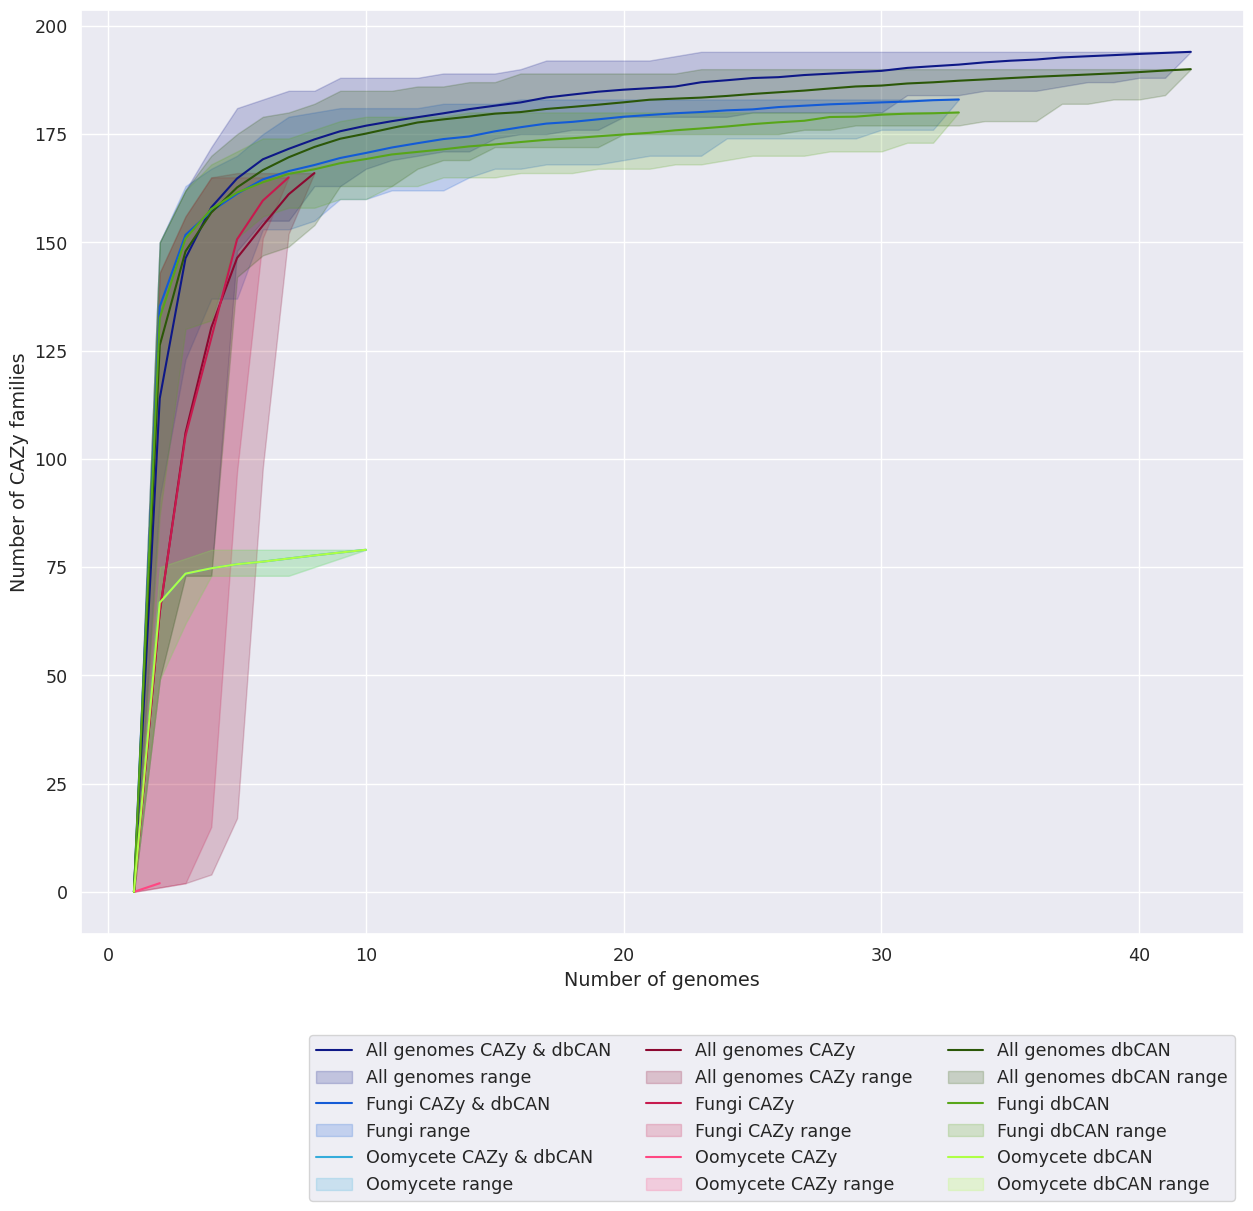

In [74]:
plt.figure(figsize=(15,12))
# consus data set
plt.plot(
    num_genomes,
    all_y,
    color='#0e1887',  # dark blue
)
plt.fill_between(num_genomes, all_y1, all_y2, color='#0e1887', alpha=.2);

plt.plot(
    num_genomes,
    fungi_y,
    color='#135bd6',  # mid blue
);
plt.fill_between(fungi_genomes, fungi_y1, fungi_y2, color='#135bd6', alpha=.2);

plt.plot(
    num_genomes,
    oomycete_y,
    color='#35acdb',  # light blue
);
plt.fill_between(oomycete_genomes, oomycete_y1, oomycete_y2, color='#35acdb', alpha=.2);

# cazy
plt.plot(
    num_genomes,
    c_all_y,
    color='#8c0830',  # dark pink
)
plt.fill_between(c_num_genomes, c_all_y1, c_all_y2, color='#8c0830', alpha=.2);

plt.plot(
    num_genomes,
    c_fungi_y,
    color='#c71a4e', # mid pink
);
plt.fill_between(c_fungi_genomes, c_fungi_y1, c_fungi_y2, color='#c71a4e', alpha=.2);

plt.plot(
    num_genomes,
    c_oomycete_y,
    color='#ff4782',  # light pink
);
plt.fill_between(c_oomycete_genomes, c_oomycete_y1, c_oomycete_y2, color='#ff4782', alpha=.2);

# dbcan
plt.plot(
    num_genomes,
    d_all_y,
    color='#2b5708',
)
plt.fill_between(d_num_genomes, d_all_y1, d_all_y2, color='#2b5708', alpha=.2);

plt.plot(
    num_genomes,
    d_fungi_y,
    color='#58a619',
);
plt.fill_between(d_fungi_genomes, d_fungi_y1, d_fungi_y2, color='#58a619', alpha=.2);

plt.plot(
    num_genomes,
    oomycete_y,
    color='#aeff45',
);
plt.fill_between(d_oomycete_genomes, oomycete_y1, oomycete_y2, color='#aeff45', alpha=.2);

plt.xlabel('Number of genomes');
plt.ylabel('Number of CAZy families');
plt.legend(
    labels=[
    'All genomes CAZy & dbCAN',
    'All genomes range',
    'Fungi CAZy & dbCAN',
    'Fungi range',
    'Oomycete CAZy & dbCAN',
    'Oomycete range',
    'All genomes CAZy',
    'All genomes CAZy range',
    'Fungi CAZy',
    'Fungi CAZy range',
    'Oomycete CAZy',
    'Oomycete CAZy range',
    'All genomes dbCAN',
    'All genomes dbCAN range',
    'Fungi dbCAN',
    'Fungi dbCAN range',
    'Oomycete dbCAN', 
    'Oomycete dbCAN range',
],
           bbox_to_anchor=(1,-0.1),
           ncols=3,
          );
plt.savefig(
    '../results/rarefaction.pdf',
    bbox_inches='tight',
    format='pdf'
)

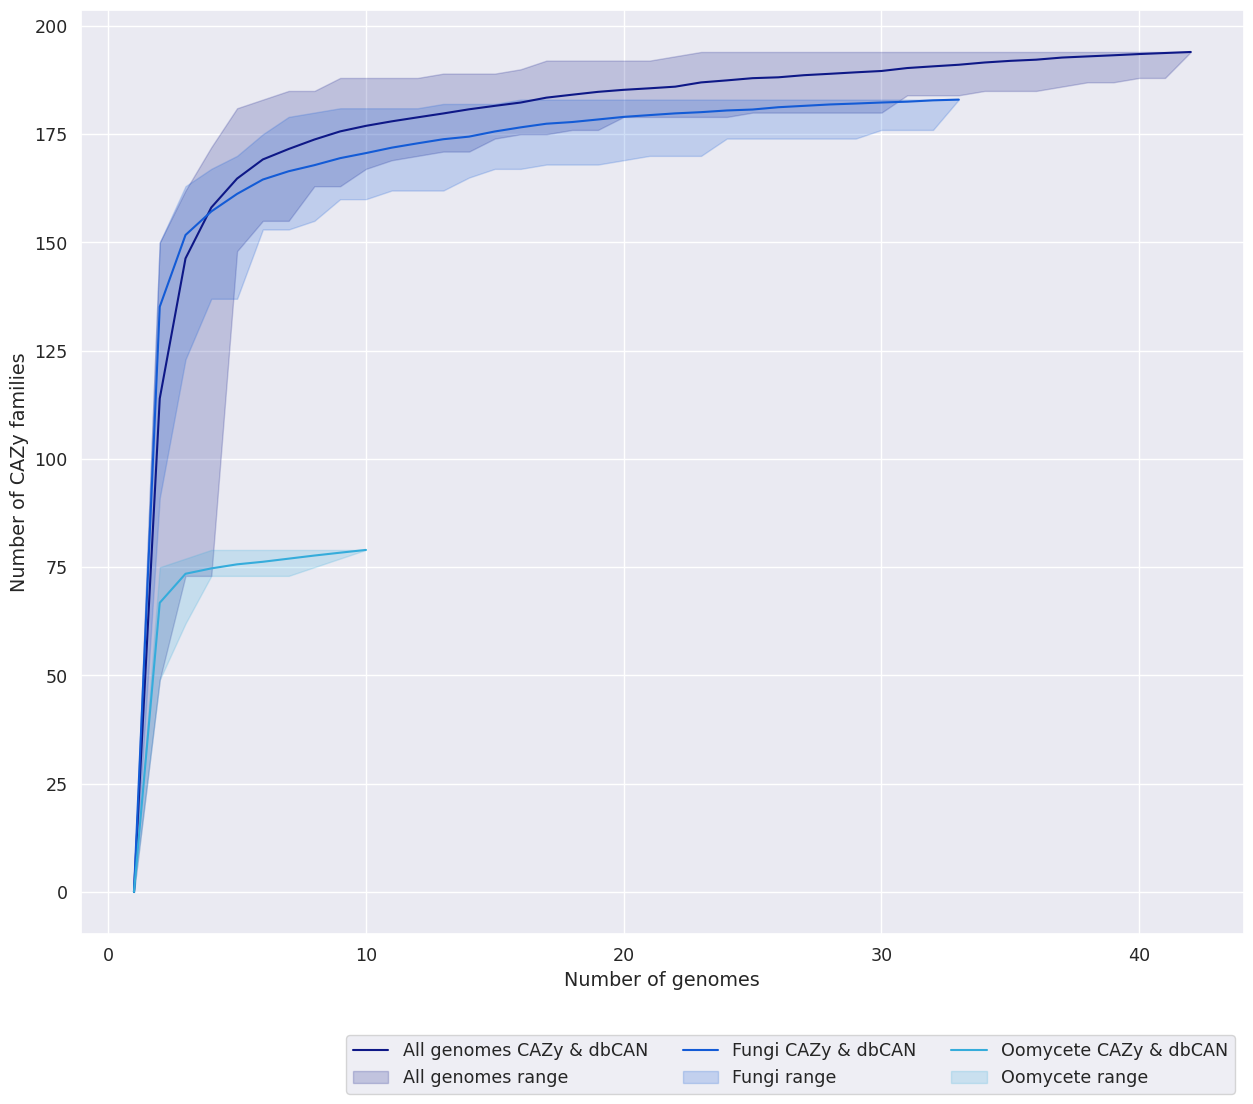

In [75]:
plt.figure(figsize=(15,12))
# consus data set
plt.plot(
    num_genomes,
    all_y,
    color='#0e1887',  # dark blue
)
plt.fill_between(num_genomes, all_y1, all_y2, color='#0e1887', alpha=.2);

plt.plot(
    num_genomes,
    fungi_y,
    color='#135bd6',  # mid blue
);
plt.fill_between(fungi_genomes, fungi_y1, fungi_y2, color='#135bd6', alpha=.2);

plt.plot(
    num_genomes,
    oomycete_y,
    color='#35acdb',  # light blue
);
plt.fill_between(oomycete_genomes, oomycete_y1, oomycete_y2, color='#35acdb', alpha=.2);

plt.xlabel('Number of genomes');
plt.ylabel('Number of CAZy families');
plt.legend(
    labels=[
    'All genomes CAZy & dbCAN',
    'All genomes range',
    'Fungi CAZy & dbCAN',
    'Fungi range',
    'Oomycete CAZy & dbCAN',
    'Oomycete range',
],
           bbox_to_anchor=(1,-0.1),
           ncols=3,
          );
plt.savefig(
    '../results/rarefaction-CAZy-dbcan.pdf',
    bbox_inches='tight',
    format='pdf'
)

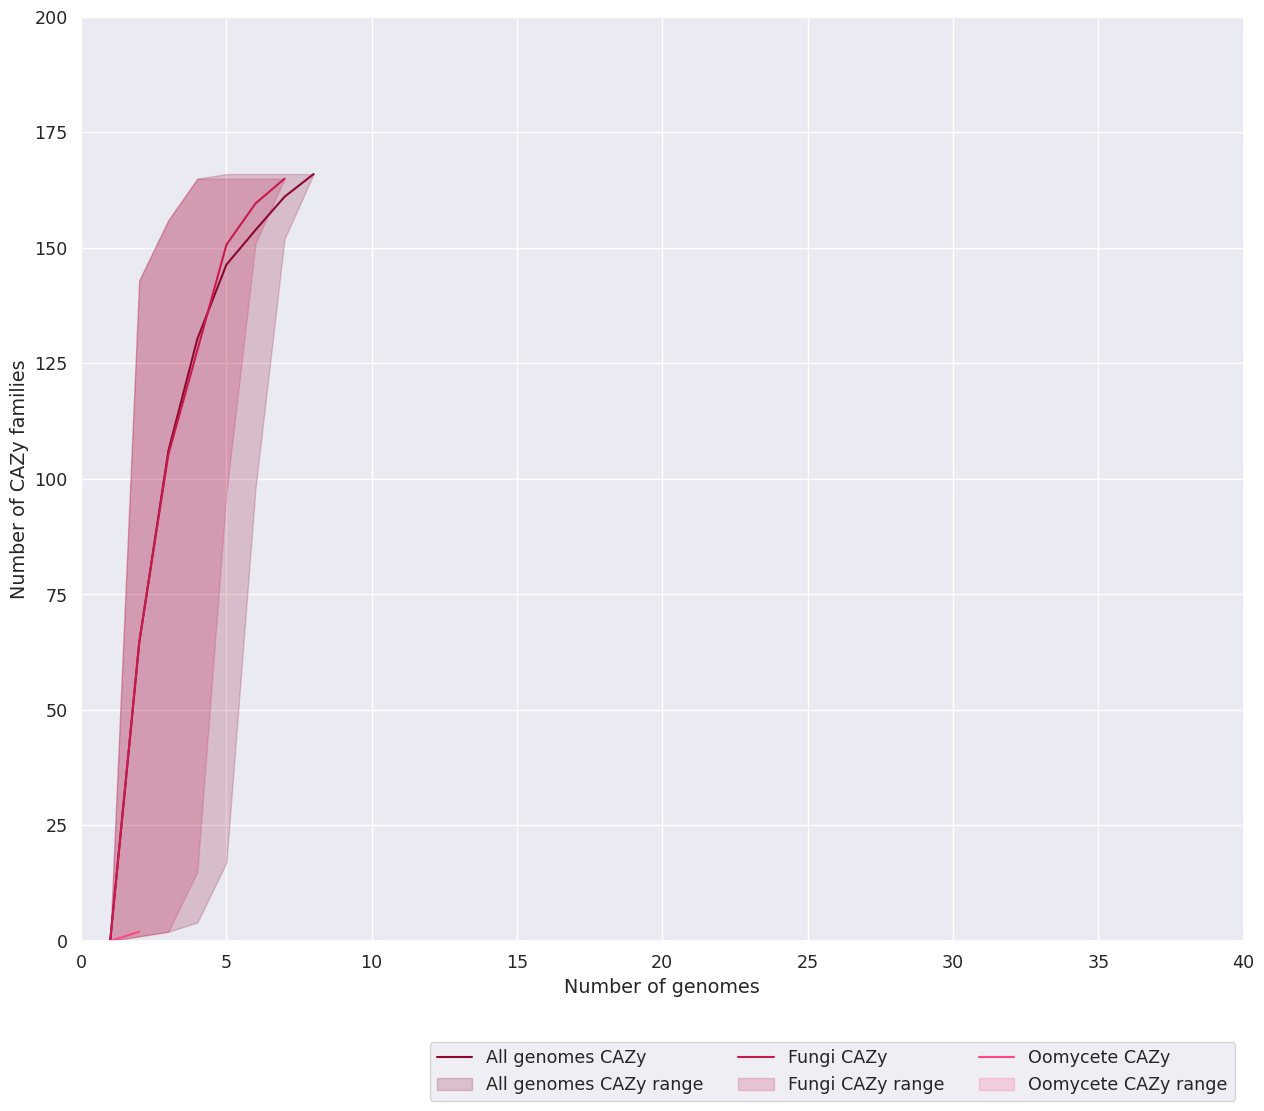

In [76]:
plt.figure(figsize=(15,12))
# consus data set
plt.axis([0, 40, 0, 200])
# cazy
plt.plot(
    num_genomes,
    c_all_y,
    color='#8c0830',  # dark pink
)
plt.fill_between(c_num_genomes, c_all_y1, c_all_y2, color='#8c0830', alpha=.2);

plt.plot(
    num_genomes,
    c_fungi_y,
    color='#c71a4e', # mid pink
);
plt.fill_between(c_fungi_genomes, c_fungi_y1, c_fungi_y2, color='#c71a4e', alpha=.2);

plt.plot(
    num_genomes,
    c_oomycete_y,
    color='#ff4782',  # light pink
);
plt.fill_between(c_oomycete_genomes, c_oomycete_y1, c_oomycete_y2, color='#ff4782', alpha=.2);

plt.xlabel('Number of genomes');
plt.ylabel('Number of CAZy families');
plt.legend(
    labels=[

    'All genomes CAZy',
    'All genomes CAZy range',
    'Fungi CAZy',
    'Fungi CAZy range',
    'Oomycete CAZy',
    'Oomycete CAZy range',

],
           bbox_to_anchor=(1,-0.1),
           ncols=3,
          );
plt.savefig(
    '../results/rarefaction-cazy.pdf',
    bbox_inches='tight',
    format='pdf'
)

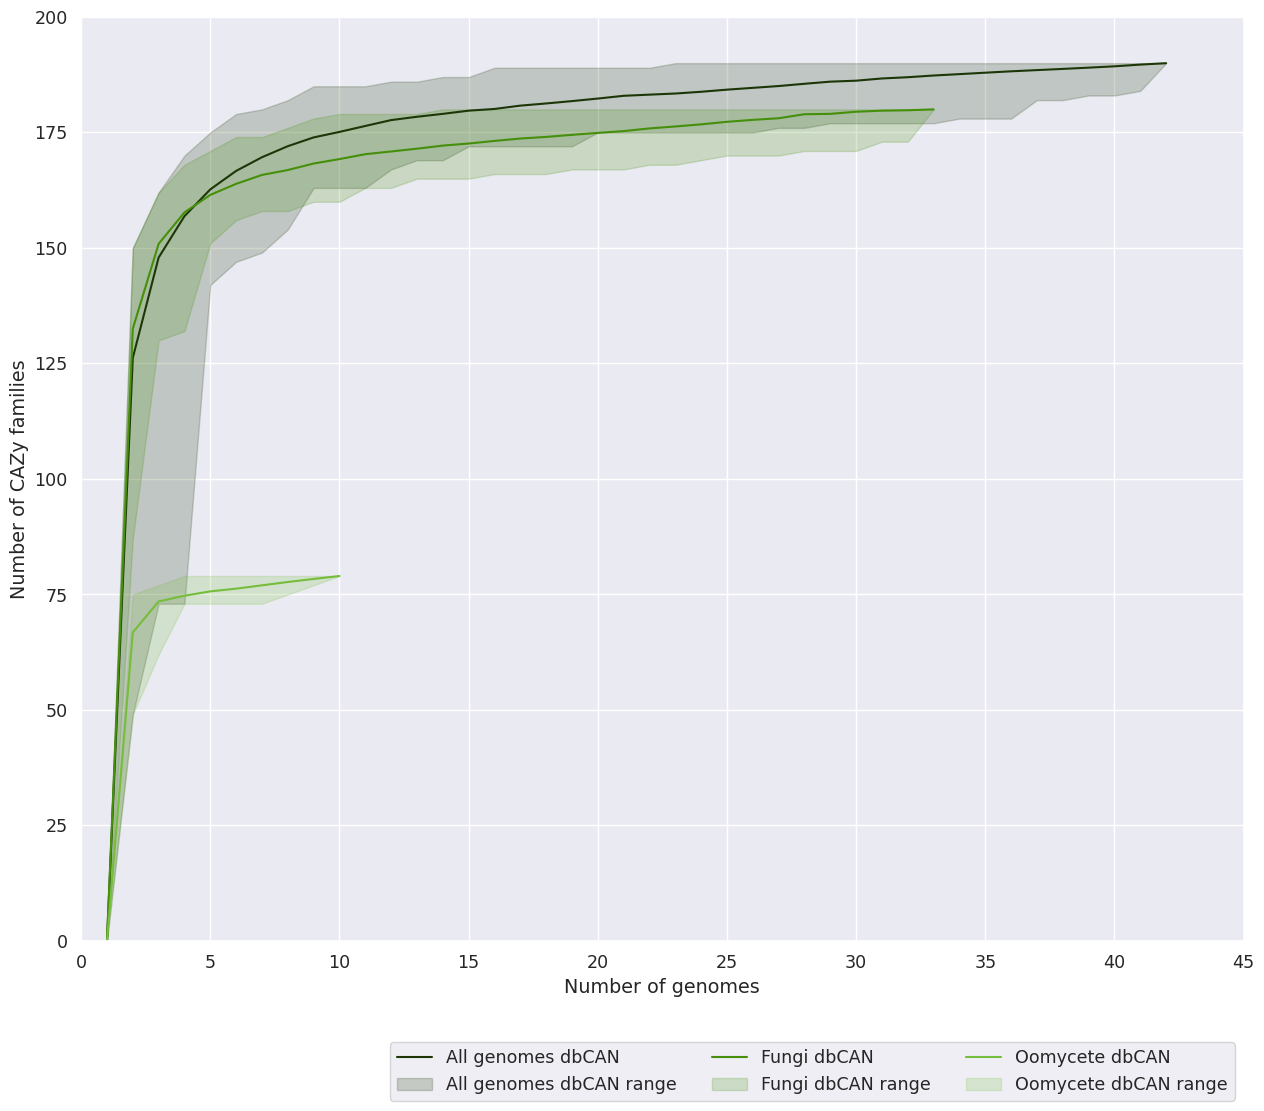

In [77]:
plt.figure(figsize=(15,12))
plt.axis([0, 45, 0, 200])
# consus data set
# dbcan
plt.plot(
    num_genomes,
    d_all_y,
    color='#1c3607',
)
plt.fill_between(d_num_genomes, d_all_y1, d_all_y2, color='#1c3607', alpha=.2);

plt.plot(
    num_genomes,
    d_fungi_y,
    color='#458f0a',
);
plt.fill_between(d_fungi_genomes, d_fungi_y1, d_fungi_y2, color='#458f0a', alpha=.2);

plt.plot(
    num_genomes,
    oomycete_y,
    color='#75bd3a',
);
plt.fill_between(d_oomycete_genomes, oomycete_y1, oomycete_y2, color='#75bd3a', alpha=.2);

plt.xlabel('Number of genomes');
plt.ylabel('Number of CAZy families');
plt.legend(
    labels=[
    'All genomes dbCAN',
    'All genomes dbCAN range',
    'Fungi dbCAN',
    'Fungi dbCAN range',
    'Oomycete dbCAN', 
    'Oomycete dbCAN range',
],
           bbox_to_anchor=(1,-0.1),
           ncols=3,
          );
plt.savefig(
    '../results/rarefaction-dbacn.pdf',
    bbox_inches='tight',
    format='pdf'
)